# Importing needed libraries

In [1]:
!pip install torchmetrics
!git clone https://github.com/m0hssn/Metrica.git
from Metrica.metrica import Metrica

import numpy as np
import pandas as pd
from collections import Counter
import seaborn as sns
from scipy import stats

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchmetrics import Metric
import torchmetrics

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score, average_precision_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize

from tqdm import tqdm
import sqlite3
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import itertools

import warnings
warnings.filterwarnings('ignore')

Cloning into 'Metrica'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 19 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), 6.64 KiB | 1.11 MiB/s, done.


In [2]:
df_drug = pd.read_pickle('/kaggle/input/dpsp-interaction/df.pkl')
conn = sqlite3.connect("/kaggle/input/dpsp-interaction/event.db")
extraction = pd.read_sql('select * from extraction;', conn)
extraction.drop(columns=['index'], inplace = True)
df_drug.drop(columns=['id', 'index'], inplace = True)

In [3]:
df_drug

,side,target,enzyme,pathway,smile,name
0,C1096328|C0162830|C1611725|C0541767|C0242973|C...,P14780|Q00653|P01375|P01579|P33673,P33261|P05181,hsa:4318|hsa:4791|hsa:7124|hsa:3458,9|10|14|18|19|20|178|181|283|284|285|286|299|3...,Glucosamine
1,C0015371|C0949040|C0856054|C0231926|C1608969|C...,Q02641,P08684,hsa:782,9|10|11|12|13|14|15|16|18|19|20|129|131|132|17...,Azelnidipine
2,C0341697|C0035232|C0855476|C0162119|C1142166|C...,P05093,P08684|Q06520|P10635|P10632|P05177|P33261|P11712,hsa:1586,9|10|11|12|14|18|143|147|178|179|182|183|184|1...,Abiraterone
3,C1737214|C0015376|C0576091|C1536116|C0679254|C...,Q14524|P35499|Q12809,P10635|P11712,hsa:6331|hsa:6329|hsa:3757,9|10|11|12|14|15|18|19|23|24|25|178|180|181|18...,Flecainide
4,C0423602|C0239557|C0031924|C0947912|C0600125|C...,P30542|P29274|Q07343|P21817|BE0004922|P78527|O...,P20815|P05177|P24462|P08684|P05181|P10632|P117...,hsa:134|hsa:135|hsa:5142|hsa:6261|hsa:5591|hsa...,9|10|11|14|15|16|18|19|143|148|149|178|183|184...,Caffeine
...,...,...,...,...,...,...
567,C0155867|C0341697|C0231341|C0853557|C0159060|C...,P30536|P14867|P18505|Q8N1C3|O14764|P78334,P08684,hsa:706|hsa:2554|hsa:2560|hsa:2565|hsa:2563|hs...,9|10|11|12|14|15|18|19|37|178|182|183|184|185|...,Ketazolam
568,C0241148|C0040440|C1096403|C0011253|C0001416|C...,P20648|P10636,P33261|P11712|P08684|P04798|P05177|Q16678|P332...,hsa:495|hsa:4137,9|10|11|12|14|15|18|19|23|24|33|143|148|149|17...,Lansoprazole
569,C0030283|C0856054|C0853557|C0426597|C0026636|C...,P25101|P24530,P08684|P11712,hsa:1909|hsa:1910,9|10|11|12|14|15|16|18|19|20|33|178|182|183|18...,Bosentan
570,C0238097|C1095952|C0558401|C0341217|C0154446|C...,O43526|O43525|P56696|Q9NR82,P22309|P35503|P22310|O60656|P11509|P11245,hsa:3785|hsa:3786|hsa:9132|hsa:56479,9|10|11|12|14|15|18|19|23|178|182|185|189|283|...,Ezogabine


In [7]:
# Display the first few rows and a summary of the dataframe
df_info = df_drug.info()
print('\
DataFrame info:')
print(df_info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 0 to 571
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   side     572 non-null    object
 1   target   572 non-null    object
 2   enzyme   572 non-null    object
 3   pathway  572 non-null    object
 4   smile    572 non-null    object
 5   name     572 non-null    object
dtypes: object(6)
memory usage: 26.9+ KB
DataFrame info:
None


In [4]:
smile_df = df_drug[['name','smile']].copy()
pathway_df = df_drug[['name','pathway']].copy()
enzyme_df = df_drug[['name','enzyme']].copy()
target_df = df_drug[['name','target']].copy()
side_df = df_drug[['name','side']].copy()

In [5]:
smile_df

,name,smile
0,Glucosamine,9|10|14|18|19|20|178|181|283|284|285|286|299|3...
1,Azelnidipine,9|10|11|12|13|14|15|16|18|19|20|129|131|132|17...
2,Abiraterone,9|10|11|12|14|18|143|147|178|179|182|183|184|1...
3,Flecainide,9|10|11|12|14|15|18|19|23|24|25|178|180|181|18...
4,Caffeine,9|10|11|14|15|16|18|19|143|148|149|178|183|184...
...,...,...
567,Ketazolam,9|10|11|12|14|15|18|19|37|178|182|183|184|185|...
568,Lansoprazole,9|10|11|12|14|15|18|19|23|24|33|143|148|149|17...
569,Bosentan,9|10|11|12|14|15|16|18|19|20|33|178|182|183|18...
570,Ezogabine,9|10|11|12|14|15|18|19|23|178|182|185|189|283|...


In [6]:
data = {'your_column_name': ['9|10|14|18|19|20|178|181|283|284|285|286|299|3', '15|25|30|40|50|60', '100|200|300']}
df = pd.DataFrame(data)

# Function to encode each value
def encode_values(value):
    # Split the string into a list of values
    values_list = value.split('|')
    
    # Encode each value (you can replace this with your encoding logic)
    encoded_values = [int(val) for val in values_list]
    
    return encoded_values

# Apply the function to your column
df['encoded_column'] = df['your_column_name'].apply(encode_values)

# Display the result
df

,your_column_name,encoded_column
0,9|10|14|18|19|20|178|181|283|284|285|286|299|3,"[9, 10, 14, 18, 19, 20, 178, 181, 283, 284, 28..."
1,15|25|30|40|50|60,"[15, 25, 30, 40, 50, 60]"
2,100|200|300,"[100, 200, 300]"


In [7]:
def encode_values(value):
    # Split the string into a list of values
    values_list = value.split('|')
    
    # Encode each value (you can replace this with your encoding logic)
    encoded_values = [val for val in values_list]
    
    return encoded_values

# Apply the function to your column
df_drug['clean_smile'] = df_drug['smile'].apply(encode_values)
df_drug['clean_pathway'] = df_drug['pathway'].apply(encode_values)
df_drug['clean_enzyme'] = df_drug['enzyme'].apply(encode_values)
df_drug['clean_target'] = df_drug['target'].apply(encode_values)
df_drug['clean_side'] = df_drug['side'].apply(encode_values)

df_drug

,side,target,enzyme,pathway,smile,name,clean_smile,clean_pathway,clean_enzyme,clean_target,clean_side
0,C1096328|C0162830|C1611725|C0541767|C0242973|C...,P14780|Q00653|P01375|P01579|P33673,P33261|P05181,hsa:4318|hsa:4791|hsa:7124|hsa:3458,9|10|14|18|19|20|178|181|283|284|285|286|299|3...,Glucosamine,"[9, 10, 14, 18, 19, 20, 178, 181, 283, 284, 28...","[hsa:4318, hsa:4791, hsa:7124, hsa:3458]","[P33261, P05181]","[P14780, Q00653, P01375, P01579, P33673]","[C1096328, C0162830, C1611725, C0541767, C0242..."
1,C0015371|C0949040|C0856054|C0231926|C1608969|C...,Q02641,P08684,hsa:782,9|10|11|12|13|14|15|16|18|19|20|129|131|132|17...,Azelnidipine,"[9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 12...",[hsa:782],[P08684],[Q02641],"[C0015371, C0949040, C0856054, C0231926, C1608..."
2,C0341697|C0035232|C0855476|C0162119|C1142166|C...,P05093,P08684|Q06520|P10635|P10632|P05177|P33261|P11712,hsa:1586,9|10|11|12|14|18|143|147|178|179|182|183|184|1...,Abiraterone,"[9, 10, 11, 12, 14, 18, 143, 147, 178, 179, 18...",[hsa:1586],"[P08684, Q06520, P10635, P10632, P05177, P3326...",[P05093],"[C0341697, C0035232, C0855476, C0162119, C1142..."
3,C1737214|C0015376|C0576091|C1536116|C0679254|C...,Q14524|P35499|Q12809,P10635|P11712,hsa:6331|hsa:6329|hsa:3757,9|10|11|12|14|15|18|19|23|24|25|178|180|181|18...,Flecainide,"[9, 10, 11, 12, 14, 15, 18, 19, 23, 24, 25, 17...","[hsa:6331, hsa:6329, hsa:3757]","[P10635, P11712]","[Q14524, P35499, Q12809]","[C1737214, C0015376, C0576091, C1536116, C0679..."
4,C0423602|C0239557|C0031924|C0947912|C0600125|C...,P30542|P29274|Q07343|P21817|BE0004922|P78527|O...,P20815|P05177|P24462|P08684|P05181|P10632|P117...,hsa:134|hsa:135|hsa:5142|hsa:6261|hsa:5591|hsa...,9|10|11|14|15|16|18|19|143|148|149|178|183|184...,Caffeine,"[9, 10, 11, 14, 15, 16, 18, 19, 143, 148, 149,...","[hsa:134, hsa:135, hsa:5142, hsa:6261, hsa:559...","[P20815, P05177, P24462, P08684, P05181, P1063...","[P30542, P29274, Q07343, P21817, BE0004922, P7...","[C0423602, C0239557, C0031924, C0947912, C0600..."
...,...,...,...,...,...,...,...,...,...,...,...
567,C0155867|C0341697|C0231341|C0853557|C0159060|C...,P30536|P14867|P18505|Q8N1C3|O14764|P78334,P08684,hsa:706|hsa:2554|hsa:2560|hsa:2565|hsa:2563|hs...,9|10|11|12|14|15|18|19|37|178|182|183|184|185|...,Ketazolam,"[9, 10, 11, 12, 14, 15, 18, 19, 37, 178, 182, ...","[hsa:706, hsa:2554, hsa:2560, hsa:2565, hsa:25...",[P08684],"[P30536, P14867, P18505, Q8N1C3, O14764, P78334]","[C0155867, C0341697, C0231341, C0853557, C0159..."
568,C0241148|C0040440|C1096403|C0011253|C0001416|C...,P20648|P10636,P33261|P11712|P08684|P04798|P05177|Q16678|P332...,hsa:495|hsa:4137,9|10|11|12|14|15|18|19|23|24|33|143|148|149|17...,Lansoprazole,"[9, 10, 11, 12, 14, 15, 18, 19, 23, 24, 33, 14...","[hsa:495, hsa:4137]","[P33261, P11712, P08684, P04798, P05177, Q1667...","[P20648, P10636]","[C0241148, C0040440, C1096403, C0011253, C0001..."
569,C0030283|C0856054|C0853557|C0426597|C0026636|C...,P25101|P24530,P08684|P11712,hsa:1909|hsa:1910,9|10|11|12|14|15|16|18|19|20|33|178|182|183|18...,Bosentan,"[9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 33, 17...","[hsa:1909, hsa:1910]","[P08684, P11712]","[P25101, P24530]","[C0030283, C0856054, C0853557, C0426597, C0026..."
570,C0238097|C1095952|C0558401|C0341217|C0154446|C...,O43526|O43525|P56696|Q9NR82,P22309|P35503|P22310|O60656|P11509|P11245,hsa:3785|hsa:3786|hsa:9132|hsa:56479,9|10|11|12|14|15|18|19|23|178|182|185|189|283|...,Ezogabine,"[9, 10, 11, 12, 14, 15, 18, 19, 23, 178, 182, ...","[hsa:3785, hsa:3786, hsa:9132, hsa:56479]","[P22309, P35503, P22310, O60656, P11509, P11245]","[O43526, O43525, P56696, Q9NR82]","[C0238097, C1095952, C0558401, C0341217, C0154..."


In [8]:
df_exploded = df_drug.explode('clean_smile')

# Get unique values
smile_unique_values = df_exploded['clean_smile'].unique()

print(smile_unique_values)

len(smile_unique_values)

['9' '10' '14' '18' '19' '20' '178' '181' '283' '284' '285' '286' '299'
 '308' '332' '338' '339' '340' '341' '344' '345' '346' '347' '351' '352'
 '365' '366' '367' '380' '393' '405' '406' '528' '563' '566' '567' '571'
 '582' '592' '614' '615' '617' '637' '638' '639' '643' '661' '662' '663'
 '679' '680' '681' '682' '683' '689' '690' '691' '701' '703' '11' '12'
 '13' '15' '16' '129' '131' '132' '182' '183' '184' '185' '189' '192'
 '196' '199' '301' '333' '335' '355' '356' '370' '371' '374' '375' '376'
 '377' '384' '390' '391' '392' '395' '401' '416' '420' '423' '430' '434'
 '437' '440' '441' '443' '446' '449' '452' '454' '455' '464' '470' '490'
 '502' '514' '516' '520' '524' '535' '540' '545' '546' '549' '552' '553'
 '556' '558' '560' '564' '570' '573' '578' '579' '584' '594' '595' '599'
 '600' '603' '607' '608' '613' '618' '619' '628' '633' '634' '640' '654'
 '656' '659' '660' '664' '665' '666' '668' '671' '673' '677' '678' '684'
 '688' '692' '693' '694' '696' '697' '698' '700' '704' '7

583

In [9]:
df_exploded = df_drug.explode('clean_pathway')

# Get unique values
smile_unique_values = df_exploded['clean_pathway'].unique()

print(smile_unique_values)

len(smile_unique_values)

['hsa:4318' 'hsa:4791' 'hsa:7124' 'hsa:3458' 'hsa:782' 'hsa:1586'
 'hsa:6331' 'hsa:6329' 'hsa:3757' 'hsa:134' 'hsa:135' 'hsa:5142'
 'hsa:6261' 'hsa:5591' 'hsa:5293' 'hsa:5290' 'hsa:5291' 'hsa:472'
 'hsa:2977' 'hsa:2147' 'hsa:1813' 'hsa:1812' 'hsa:1816' 'hsa:1814'
 'hsa:1815' 'hsa:3356' 'hsa:3358' 'hsa:3269' 'hsa:1128' 'hsa:1129'
 'hsa:1131' 'hsa:1132' 'hsa:1133' 'hsa:148' 'hsa:147' 'hsa:146' 'hsa:150'
 'hsa:151' 'hsa:152' 'hsa:2908' 'hsa:5241' 'hsa:5321' 'hsa:4306' 'hsa:819'
 'hsa:5535' 'hsa:5478' 'hsa:10105' 'hsa:116443' 'hsa:5743' 'hsa:5742'
 'hsa:5139' 'hsa:140' 'hsa:3066' 'hsa:1584' 'hsa:2230' 'hsa:2099'
 'hsa:367' 'hsa:2100' 'hsa:8856' 'hsa:1137' 'hsa:10499' 'hsa:2852'
 'hsa:4508' 'hsa:8678' 'hsa:3294' 'hsa:2104' 'hsa:5422' 'hsa:6240'
 'hsa:2939' 'hsa:54106' 'hsa:2903' 'hsa:2904' 'hsa:3359' 'hsa:2902'
 'hsa:3716' 'hsa:3717' 'hsa:2185' 'hsa:3718' 'hsa:6336' 'hsa:1786'
 'hsa:6256' 'hsa:3274' 'hsa:11255' 'hsa:59340' 'hsa:6571' 'hsa:43'
 'hsa:4846' 'hsa:4843' 'hsa:3778' 'hsa:3779' 'hs

957

In [10]:
df_drug['clean_pathway'] = df_drug['clean_pathway'].apply(lambda x: [item[4:] for item in x])


In [11]:
df_drug['clean_pathway']

0                               [4318, 4791, 7124, 3458]
1                                                  [782]
2                                                 [1586]
3                                     [6331, 6329, 3757]
4      [134, 135, 5142, 6261, 5591, 5293, 5290, 5291,...
                             ...                        
567                  [706, 2554, 2560, 2565, 2563, 2564]
568                                          [495, 4137]
569                                         [1909, 1910]
570                            [3785, 3786, 9132, 56479]
571                                          [238, 4233]
Name: clean_pathway, Length: 572, dtype: object

In [12]:
df_exploded = df_drug.explode('clean_enzyme')

# Get unique values
smile_unique_values = df_exploded['clean_enzyme'].unique()

print(smile_unique_values)

len(smile_unique_values)

['P33261' 'P05181' 'P08684' 'Q06520' 'P10635' 'P10632' 'P05177' 'P11712'
 'P20815' 'P24462' 'P04798' 'Q16678' 'P20711' 'P27338' 'P05164' 'P22309'
 'P27707' 'P20813' 'P11509' 'P32320' 'O60656' 'P35503' 'Q9HAW8' 'P16662'
 'P50135' 'P06276' 'P15538' 'P11511' 'P21397' 'P31513' 'P19099' 'P05093'
 'P47989' 'P16435' 'P19801' 'Q9TRC7' 'Q9HAW7' 'P19224' 'Q9HAW9' 'P23141'
 'O00748' 'P16152' 'Q15166' 'P13584' 'P22310' 'P11245' 'P9WJI5' 'Q14097'
 'P33260' 'Q6LAP9' 'P54855' 'P21964' 'P09172' 'P51589' 'Q92820' 'P42898'
 'P05108' 'Q01740' 'P23219' 'P19971' 'Q12882' 'Q16831' 'O95045' 'P04818'
 'P11172' 'Q06203' 'O43174' 'Q16850' 'P78329' 'Q9NYA1' 'Q9HCS2' 'Q96EY8'
 'P22033' 'Q99707' 'Q05599' 'P21589' 'P32321' 'Q13867' 'P06133' 'Q13393'
 'P24752' 'F1T0I5' 'P04040' 'P35354' 'F5GY58' 'O00519' 'P00390' 'P07203'
 'P04035' 'P14902' 'P09917' 'P16050' 'Q02083' 'Q08257' 'Q6IQ20' 'P04054'
 'P00441' 'P17405' 'P26439' 'P52209' 'P33402' 'O76074' 'P22303' 'Q06278'
 'P51580' 'Q9HB55' 'P15104' 'P00734' 'P30711' 'P092

202

In [13]:
df_exploded = df_drug.explode('clean_target')

# Get unique values
smile_unique_values = df_exploded['clean_target'].unique()

print(smile_unique_values)

len(smile_unique_values)

['P14780' 'Q00653' 'P01375' ... 'P53985' 'P56696' 'Q9NR82']


1162

In [14]:
df_exploded = df_drug.explode('clean_side')

# Get unique values
smile_unique_values = df_exploded['clean_side'].unique()

print(smile_unique_values)

len(smile_unique_values)

['C1096328' 'C0162830' 'C1611725' ... 'C0852902' 'C0038005' 'C0192423']


9991

In [15]:
def find_longest_shortest_lists(column, col_name):
    max_length = 0
    min_length = float('inf')
    longest_list = None
    shortest_list = None

    for value in column:
        if value:
            length = len(value)
            if length > max_length:
                max_length = length
                longest_list = value
            if length < min_length:
                min_length = length
                shortest_list = value
    print(f"Longest list in {col_name}: {longest_list}")
    print(f"Shortest list in {col_name}: {shortest_list}")
    print(f"Length of longest list: {max_length}")
    print(f"Length of shortest list: {min_length}")
    print('*********************************************')

# Example usage
find_longest_shortest_lists(df_exploded['clean_enzyme'], 'clean_enzyme')
find_longest_shortest_lists(df_exploded['clean_side'], 'clean_side')
find_longest_shortest_lists(df_exploded['clean_target'], 'clean_target')
find_longest_shortest_lists(df_exploded['clean_pathway'], 'clean_pathway')
find_longest_shortest_lists(df_exploded['clean_smile'], 'clean_smile')

Longest list in clean_enzyme: ['P11712', 'P33261', 'P10635', 'P08684', 'P20815', 'P24752', 'F1T0I5', 'P04040', 'P23219', 'P35354', 'P24462', 'P04798', 'P05177', 'Q16678', 'F5GY58', 'O00519', 'P00390', 'P07203', 'P04035', 'P14902', 'P09917', 'P16050', 'Q02083', 'Q08257', 'Q6IQ20', 'P04054', 'P05093', 'P00441', 'P17405']
Shortest list in clean_enzyme: ['P08684']
Length of longest list: 29
Length of shortest list: 1
*********************************************
Longest list in clean_side: C1096328
Shortest list in clean_side: C1096328
Length of longest list: 8
Length of shortest list: 8
*********************************************
Longest list in clean_target: ['P43405', 'P0DMS8', 'Q99870', 'O00519', 'Q99808', 'P22309', 'O76074', 'P09917', 'P25774', 'P07711', 'P00519', 'P62344', 'P9WI81', 'Q9UK32', 'P29597', 'Q8NI60', 'P23458', 'P08581', 'Q8IY84', 'Q9P289', 'P17612', 'Q9Y6E0', 'Q13188', 'P42680', 'Q9BYT3', 'Q8TDR2', 'Q9NRP7', 'Q15208', 'Q9Y2H1', 'Q9UEW8', 'Q7L7X3', 'Q9UL54', 'Q9H2K8', 'Q

In [16]:
def feature_extractor(df, f_list):
    for feature in f_list:
        unique = set('|'.join(df[feature].values.tolist()).split('|'))

        for side in unique:
            df[side] = 0

        for index, row in df.iterrows():
            for side in row[feature].split('|'):
                df.at[index, side] = 1
    df.drop(columns=f_list, inplace=True)
    return df

feature_extractor(df_drug, ['target', 'enzyme', 'smile', 'pathway', 'side'])

,name,clean_smile,clean_pathway,clean_enzyme,clean_target,clean_side,O14717,O43451,Q00536,P08172,...,C0038273,C0042903,C0349667,C1696575,C0852973,C0221016,C1112175,C0235296,C0919884,C0948930
0,Glucosamine,"[9, 10, 14, 18, 19, 20, 178, 181, 283, 284, 28...","[4318, 4791, 7124, 3458]","[P33261, P05181]","[P14780, Q00653, P01375, P01579, P33673]","[C1096328, C0162830, C1611725, C0541767, C0242...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Azelnidipine,"[9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 12...",[782],[P08684],[Q02641],"[C0015371, C0949040, C0856054, C0231926, C1608...",0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,Abiraterone,"[9, 10, 11, 12, 14, 18, 143, 147, 178, 179, 18...",[1586],"[P08684, Q06520, P10635, P10632, P05177, P3326...",[P05093],"[C0341697, C0035232, C0855476, C0162119, C1142...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Flecainide,"[9, 10, 11, 12, 14, 15, 18, 19, 23, 24, 25, 17...","[6331, 6329, 3757]","[P10635, P11712]","[Q14524, P35499, Q12809]","[C1737214, C0015376, C0576091, C1536116, C0679...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Caffeine,"[9, 10, 11, 14, 15, 16, 18, 19, 143, 148, 149,...","[134, 135, 5142, 6261, 5591, 5293, 5290, 5291,...","[P20815, P05177, P24462, P08684, P05181, P1063...","[P30542, P29274, Q07343, P21817, BE0004922, P7...","[C0423602, C0239557, C0031924, C0947912, C0600...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Ketazolam,"[9, 10, 11, 12, 14, 15, 18, 19, 37, 178, 182, ...","[706, 2554, 2560, 2565, 2563, 2564]",[P08684],"[P30536, P14867, P18505, Q8N1C3, O14764, P78334]","[C0155867, C0341697, C0231341, C0853557, C0159...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
568,Lansoprazole,"[9, 10, 11, 12, 14, 15, 18, 19, 23, 24, 33, 14...","[495, 4137]","[P33261, P11712, P08684, P04798, P05177, Q1667...","[P20648, P10636]","[C0241148, C0040440, C1096403, C0011253, C0001...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
569,Bosentan,"[9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 33, 17...","[1909, 1910]","[P08684, P11712]","[P25101, P24530]","[C0030283, C0856054, C0853557, C0426597, C0026...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
570,Ezogabine,"[9, 10, 11, 12, 14, 15, 18, 19, 23, 178, 182, ...","[3785, 3786, 9132, 56479]","[P22309, P35503, P22310, O60656, P11509, P11245]","[O43526, O43525, P56696, Q9NR82]","[C0238097, C1095952, C0558401, C0341217, C0154...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
df_drug.drop(columns=['clean_smile','clean_pathway','clean_enzyme','clean_target','clean_side'], inplace=True)

In [18]:
feature_extractor(smile_df, ['smile'])
feature_extractor(pathway_df, ['pathway'])
feature_extractor(target_df, ['target'])
feature_extractor(enzyme_df, ['enzyme'])
feature_extractor(side_df, ['side'])

,name,C0854693,C0151694,C3665346,C0152078,C1696849,C0232600,C1504448,C0278835,C2242548,...,C0038273,C0042903,C0349667,C1696575,C0852973,C0221016,C1112175,C0235296,C0919884,C0948930
0,Glucosamine,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Azelnidipine,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,Abiraterone,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Flecainide,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Caffeine,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Ketazolam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
568,Lansoprazole,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
569,Bosentan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
570,Ezogabine,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
df_drug

,name,O14717,O43451,Q00536,P08172,O00238,P00533,F1L7U3,Q01959,P22694,...,C0038273,C0042903,C0349667,C1696575,C0852973,C0221016,C1112175,C0235296,C0919884,C0948930
0,Glucosamine,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Azelnidipine,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,Abiraterone,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Flecainide,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Caffeine,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Ketazolam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
568,Lansoprazole,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
569,Bosentan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
570,Ezogabine,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
extraction['side'] = extraction['mechanism'] + extraction['action']
extraction.drop(columns=['mechanism', 'action'], inplace=True)

le = preprocessing.LabelEncoder()
extraction['side'] = le.fit_transform(extraction['side'])

In [21]:
extraction

,drugA,drugB,side
0,Abemaciclib,Amiodarone,4
1,Abemaciclib,Apalutamide,14
2,Abemaciclib,Aprepitant,15
3,Abemaciclib,Atomoxetine,0
4,Abemaciclib,Bortezomib,0
...,...,...,...
37259,Nefazodone,Netupitant,15
37260,Nefazodone,Nicardipine,0
37261,Neratinib,Netupitant,15
37262,Netupitant,Nicardipine,15


In [22]:
def EDA_maker(dataset):
    dataset = dataset.apply(pd.to_numeric, errors='coerce')
    column_names = dataset.columns
    column_counts = dataset.sum()

    average_count = column_counts.mean()

    # Display the average count
    print(f'Average Count of true values: {average_count}')
    
    plt.figure(figsize=(10, 6))  # Optional: Set the figure size
    column_counts.plot(kind='bar', color='skyblue', alpha=0.7)

    # Add labels and a title
    plt.xlabel('Columns')
    plt.ylabel('Count of values')
    plt.title('Count of values in Each Column')

    # Show the plot
    plt.show()

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

def counter_plot(dataset, column_name):
    dataset = dataset.apply(pd.to_numeric, errors='coerce')
    class_counts = dataset[column_name].value_counts()

    # Create a dictionary to store the class counts
    class_counts_dict = class_counts.to_dict()

    plt.figure(figsize=(10, 6))  # Optional: Set the figure size
    class_counts.plot(kind='bar', color='skyblue', alpha=0.7)

    # Add labels and a title
    plt.xlabel('c')
    plt.ylabel('Count')
    plt.title('number of sample for each side effect')

    # Show the plot
    plt.show()

    # Return the class counts as a dictionary
    return class_counts_dict

In [24]:
set(extraction['side'].unique())

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64}

In [25]:
extraction

,drugA,drugB,side
0,Abemaciclib,Amiodarone,4
1,Abemaciclib,Apalutamide,14
2,Abemaciclib,Aprepitant,15
3,Abemaciclib,Atomoxetine,0
4,Abemaciclib,Bortezomib,0
...,...,...,...
37259,Nefazodone,Netupitant,15
37260,Nefazodone,Nicardipine,0
37261,Neratinib,Netupitant,15
37262,Netupitant,Nicardipine,15


In [26]:
df_drug

,name,O14717,O43451,Q00536,P08172,O00238,P00533,F1L7U3,Q01959,P22694,...,C0038273,C0042903,C0349667,C1696575,C0852973,C0221016,C1112175,C0235296,C0919884,C0948930
0,Glucosamine,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Azelnidipine,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,Abiraterone,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Flecainide,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Caffeine,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Ketazolam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
568,Lansoprazole,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
569,Bosentan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
570,Ezogabine,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# EDA

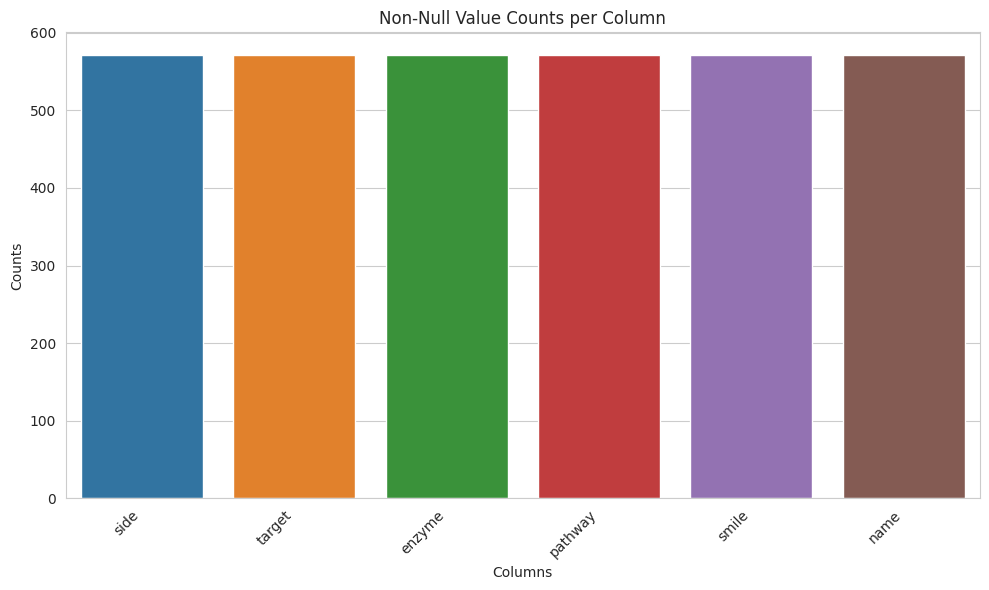

Unique value counts for categorical columns:
side: 572
target: 454
enzyme: 378
pathway: 442
name: 572


In [5]:
# Set the aesthetic style of the plots
sns.set_style('whitegrid')

# Plotting the non-null value counts for each column
df_non_null_counts = df_drug.notnull().sum()
plt.figure(figsize=(10, 6))
sns.barplot(x=df_non_null_counts.index, y=df_non_null_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title('Non-Null Value Counts per Column')
plt.ylabel('Counts')
plt.xlabel('Columns')
plt.tight_layout()
plt.show()

# Unique value counts for categorical columns
categorical_columns = ['side', 'target', 'enzyme', 'pathway', 'name']
unique_counts = {col: df_drug[col].nunique() for col in categorical_columns}
print('Unique value counts for categorical columns:')
for col, count in unique_counts.items():
    print(f'{col}: {count}')

### side for pair drugs in a sample of data

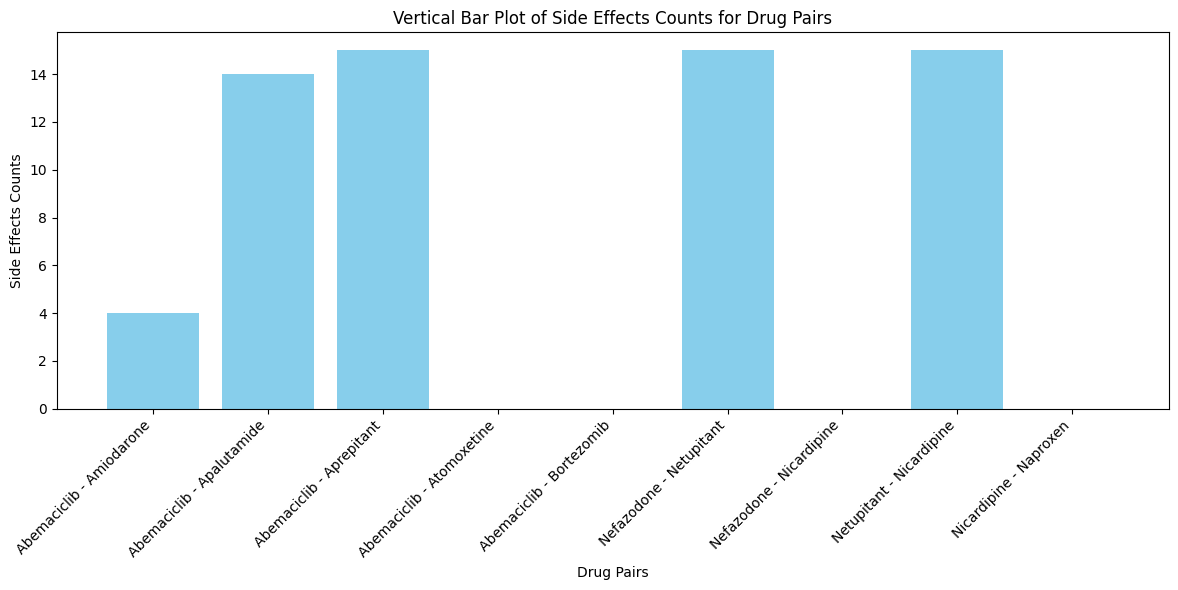

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data creation (replace this with your actual data loading)
data = {
    'drugA': ['Abemaciclib', 'Abemaciclib', 'Abemaciclib', 'Abemaciclib', 'Abemaciclib', 'Nefazodone', 'Nefazodone', 'Neratinib', 'Netupitant', 'Nicardipine'],
    'drugB': ['Amiodarone', 'Apalutamide', 'Aprepitant', 'Atomoxetine', 'Bortezomib', 'Netupitant', 'Nicardipine', 'Netupitant', 'Nicardipine', 'Naproxen'],
    'side': [4, 14, 15, 0, 0, 15, 0, 15, 15, 0]
}

df = pd.DataFrame(data)

# Sample data creation for drug dataset (replace this with your actual data loading)
data_drug = {
    'name': ['Abemaciclib', 'Amiodarone', 'Apalutamide', 'Aprepitant', 'Atomoxetine', 'Bortezomib', 'Nefazodone', 'Netupitant', 'Nicardipine', 'Naproxen'],
    'P00325': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    # ... include other columns as needed
}

df2 = pd.DataFrame(data_drug)

# Merge the datasets on drug names after normalizing the case
merged_df = pd.merge(df, df2, left_on=df['drugA'].str.lower(), right_on=df2['name'].str.lower(), how='inner')

# Group by drug pairs and sum the side effects counts
grouped_df = merged_df.groupby(['drugA', 'drugB']).sum()['side'].reset_index()

# Create a vertical bar plot
plt.figure(figsize=(12, 6))
plt.bar(grouped_df['drugA'] + ' - ' + grouped_df['drugB'], grouped_df['side'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Vertical Bar Plot of Side Effects Counts for Drug Pairs')
plt.xlabel('Drug Pairs')
plt.ylabel('Side Effects Counts')
plt.tight_layout()
plt.show()


### distribution of side count for each of pair drugs in whole dataset

In [28]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Merge the datasets on drug names after normalizing the case
# merged_df = pd.merge(extraction, df_drug, left_on=extraction['drugA'].str.lower(), right_on=df_drug['name'].str.lower(), how='inner')

# # Group by drug pairs and sum the side effects counts
# grouped_df = merged_df.groupby(['drugA', 'drugB']).sum()['side'].reset_index()

# # Create a vertical bar plot
# plt.figure(figsize=(12, 6))
# plt.bar(grouped_df['drugA'] + ' - ' + grouped_df['drugB'], grouped_df['side'], color='skyblue')
# plt.xticks(rotation=45, ha='right')
# plt.title('Vertical Bar Plot of Side Effects Counts for Drug Pairs')
# plt.xlabel('Drug Pairs')
# plt.ylabel('Side Effects Counts')
# plt.tight_layout()
# plt.show()


### to check top 50 Side Effects Counts for Drug Pairs

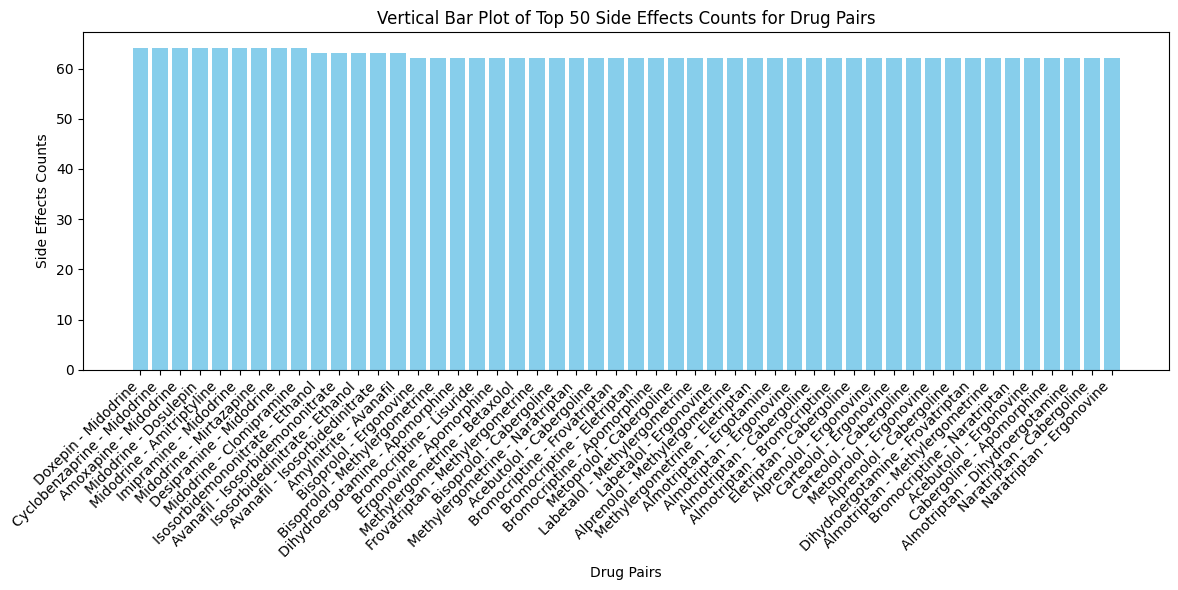

In [29]:
merged_df = pd.merge(extraction, df_drug, left_on=extraction['drugA'].str.lower(), right_on=df_drug['name'].str.lower(), how='inner')

# Group by drug pairs and sum the side effects counts
grouped_df = merged_df.groupby(['drugA', 'drugB']).sum()['side'].reset_index()

grouped_df_sorted = grouped_df.sort_values(by='side', ascending=False)

top_50_df = grouped_df_sorted.head(50)

# Create a vertical bar plot for the top 30 side effects counts
plt.figure(figsize=(12, 6))
plt.bar(top_50_df['drugA'] + ' - ' + top_50_df['drugB'], top_50_df['side'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Vertical Bar Plot of Top 50 Side Effects Counts for Drug Pairs')
plt.xlabel('Drug Pairs')
plt.ylabel('Side Effects Counts')
plt.tight_layout()
plt.show()

In [30]:
top_50_df

,drugA,drugB,side
17019,Doxepin,Midodrine,64
12504,Cyclobenzaprine,Midodrine,64
1814,Amoxapine,Midodrine,64
35247,Midodrine,Dosulepin,64
35235,Midodrine,Amitriptyline,64
26957,Imipramine,Midodrine,64
35254,Midodrine,Mirtazapine,64
13875,Desipramine,Midodrine,64
35242,Midodrine,Clomipramine,64
28228,Isosorbidemononitrate,Ethanol,63


This code is generating a vertical bar plot showing the side effects counts for different drug pairs. Let's break down the code and understand the result - The code merges the two datasets (df and df_drug) based on drug names (drugA and name) after normalizing the case. It ensures that the drug names are matched even if the case (uppercase/lowercase) is different - The x-axis represents drug pairs (drugA - drugB), and the y-axis represents the summed side effects counts.
Each bar in the plot corresponds to a drug pair, and its height represents the total side effects count.The resulting plot visually represents the side effects counts for different drug pairs. Each bar in the plot corresponds to a unique drug pair, providing a visual comparison of their side effects.

In [31]:
set(top_50_df.drugA)

{'Acebutolol',
 'Almotriptan',
 'Alprenolol',
 'Amoxapine',
 'Amylnitrite',
 'Avanafil',
 'Bisoprolol',
 'Bromocriptine',
 'Cabergoline',
 'Carteolol',
 'Cyclobenzaprine',
 'Desipramine',
 'Dihydroergotamine',
 'Doxepin',
 'Eletriptan',
 'Ergonovine',
 'Frovatriptan',
 'Imipramine',
 'Isosorbidedinitrate',
 'Isosorbidemononitrate',
 'Labetalol',
 'Methylergometrine',
 'Metoprolol',
 'Midodrine',
 'Naratriptan'}

### check info about drugs with the most side effect

> #### check their side

In [32]:
drugs_of_interest = {'Acebutolol','Alprenolol', 'Amoxapine','Amylnitrite','Avanafil','Betaxolol', 
                     'Bisoprolol','Bromocriptine', 'Cabergoline', 'Carteolol', 'Carvedilol',
                     'Cyclobenzaprine', 'Desipramine', 'Dihydroergotamine','Doxepin', 'Ergonovine',
                     'Ergotamine', 'Frovatriptan','Imipramine', 'Isosorbidedinitrate',
                     'Isosorbidemononitrate','Labetalol', 'Lisuride', 'Methylergometrine',
                     'Midodrine', 'Naratriptan'}

# Dictionary to store the result
result_dict = {}

# Iterate over each drug
for drug in drugs_of_interest:
    # Filter the DataFrame for the specified drug and get columns with value 1
    columns_with_value_1 = side_df.loc[side_df['name'] == drug, side_df.columns[1:]].columns[side_df.loc[side_df['name'] == drug, side_df.columns[1:]].eq(1).any()]

    # Add to the dictionary
    result_dict[drug] = list(columns_with_value_1)

# Display the result
for drug, columns in result_dict.items():
    print(f"{drug}: {columns}")

Carteolol: ['C0392618', 'C3665347', 'C0185134', 'C1735340', 'C0235431', 'C0013378', 'C0080233', 'C0239429', 'C0948425', 'C0520966', 'C0235146', 'C0086132', 'C1262141', 'C0178298', 'C0013609', 'C0858621', 'C1869096', 'C0015397', 'C0085616', 'C0239940', 'C0332543', 'C0021053', 'C0920251', 'C0241950', 'C0162830', 'C0853141', 'C0026826', 'C0151889', 'C0858833', 'C0265110', 'C0004936', 'C0241379', 'C0699828', 'C0948013', 'C0919887', 'C0858911', 'C0851354', 'C1510410', 'C0233479', 'C0948715', 'C0232487', 'C0000729', 'C0017178', 'C1536020', 'C0849916', 'C0686377', 'C0151785', 'C1443060', 'C0236068', 'C0234458', 'C0005940', 'C1141938', 'C0947846', 'C0023510', 'C0851748', 'C0155626', 'C0521592', 'C2242503', 'C0235198', 'C2830004', 'C0154038', 'C0011331', 'C0392703', 'C0020580', 'C0235266', 'C0149504', 'C0948361', 'C0476281', 'C0024633', 'C0011548', 'C0023066', 'C0042401', 'C1869041', 'C0155018', 'C0241697', 'C0852016', 'C0853692', 'C1328320', 'C1142288', 'C1096730', 'C0232431', 'C0877282', 'C00

In [33]:
# Extract the columns for each drug in a list
columns_per_drug = [set(result_dict[drug]) for drug in drugs_of_interest]

# Find the common columns using set intersection
common_columns = set.intersection(*columns_per_drug)

# Display the common columns
print("Common Columns:", common_columns)

Common Columns: set()


> ### check their target

In [34]:
drugs_of_interest = {'Acebutolol','Alprenolol', 'Amoxapine','Amylnitrite','Avanafil','Betaxolol', 
                     'Bisoprolol','Bromocriptine', 'Cabergoline', 'Carteolol', 'Carvedilol',
                     'Cyclobenzaprine', 'Desipramine', 'Dihydroergotamine','Doxepin', 'Ergonovine',
                     'Ergotamine', 'Frovatriptan','Imipramine', 'Isosorbidedinitrate',
                     'Isosorbidemononitrate','Labetalol', 'Lisuride', 'Methylergometrine',
                     'Midodrine', 'Naratriptan'}

# Dictionary to store the result
result_dict = {}

# Iterate over each drug
for drug in drugs_of_interest:
    # Filter the DataFrame for the specified drug and get columns with value 1
    columns_with_value_1 = target_df.loc[target_df['name'] == drug, target_df.columns[1:]].columns[target_df.loc[target_df['name'] == drug, target_df.columns[1:]].eq(1).any()]

    # Add to the dictionary
    result_dict[drug] = list(columns_with_value_1)

# Display the result
for drug, columns in result_dict.items():
    print(f"{drug}: {columns}")

Carteolol: ['P07550', 'P08588']
Dihydroergotamine: ['P28221', 'P41595', 'P08913', 'P28222']
Ergotamine: ['P28221', 'P23975', 'P18089', 'P25100', 'BE0004889', 'P41595', 'P08913', 'P35348', 'P35368', 'P28222', 'P28335', 'P30939', 'P28223', 'P14416', 'P08908']
Isosorbidemononitrate: ['P33402']
Imipramine: ['P08172', 'Q01959', 'P08173', 'P23975', 'P11229', 'P25100', 'BE0004889', 'P31645', 'P35367', 'P08912', 'P50406', 'P19652', 'P35348', 'P35368', 'O95259', 'P28335', 'P34969', 'P28223', 'Q9NZV8', 'P14416', 'P08908', 'P20309', 'Q9UK17', 'Q12809']
Alprenolol: ['P07550', 'P08908', 'P08588', 'P13945']
Avanafil: ['O76074']
Cabergoline: ['P07550', 'P18825', 'P28221', 'P18089', 'P25100', 'BE0004889', 'P41595', 'P21918', 'P35462', 'P08913', 'P35348', 'P35368', 'P21917', 'P28222', 'P28335', 'P34969', 'P28223', 'P21728', 'P14416', 'P08908', 'P08588']
Betaxolol: ['P07550', 'P08588']
Lisuride: ['P18825', 'P28221', 'P18089', 'P41595', 'P21918', 'P35462', 'P08913', 'P21917', 'P28222', 'P28335', 'P34969'

In [35]:
# Extract the columns for each drug in a list
columns_per_drug = [set(result_dict[drug]) for drug in drugs_of_interest]

# Find the common columns using set intersection
common_columns = set.intersection(*columns_per_drug)

# Display the common columns
print("Common Columns:", common_columns)

Common Columns: set()


> ### check their pathway

In [36]:
drugs_of_interest = {'Acebutolol','Alprenolol', 'Amoxapine','Amylnitrite','Avanafil','Betaxolol', 
                     'Bisoprolol','Bromocriptine', 'Cabergoline', 'Carteolol', 'Carvedilol',
                     'Cyclobenzaprine', 'Desipramine', 'Dihydroergotamine','Doxepin', 'Ergonovine',
                     'Ergotamine', 'Frovatriptan','Imipramine', 'Isosorbidedinitrate',
                     'Isosorbidemononitrate','Labetalol', 'Lisuride', 'Methylergometrine',
                     'Midodrine', 'Naratriptan'}

# Dictionary to store the result
result_dict = {}

# Iterate over each drug
for drug in drugs_of_interest:
    # Filter the DataFrame for the specified drug and get columns with value 1
    columns_with_value_1 = pathway_df.loc[pathway_df['name'] == drug, pathway_df.columns[1:]].columns[pathway_df.loc[pathway_df['name'] == drug, pathway_df.columns[1:]].eq(1).any()]

    # Add to the dictionary
    result_dict[drug] = list(columns_with_value_1)

# Display the result
for drug, columns in result_dict.items():
    print(f"{drug}: {columns}")

Carteolol: ['hsa:153', 'hsa:154']
Dihydroergotamine: ['hsa:3351', 'hsa:150', 'hsa:3357', 'hsa:3352']
Ergotamine: ['hsa:3350', 'hsa:1813', 'hsa:146', 'hsa:3351', 'hsa:150', 'hsa:3358', 'hsa:3357', 'hsa:148', 'hsa:147', 'hsa:3356', 'hsa:6530', 'hsa:3352', 'hsa:3355', 'hsa:151']
Isosorbidemononitrate: ['hsa:2977']
Imipramine: ['hsa:3350', 'hsa:1133', 'hsa:3362', 'hsa:1813', 'hsa:5005', 'hsa:146', 'hsa:3757', 'hsa:1132', 'hsa:3751', 'hsa:1128', 'hsa:1129', 'hsa:3358', 'hsa:3363', 'hsa:1131', 'hsa:3756', 'hsa:148', 'hsa:3269', 'hsa:6531', 'hsa:147', 'hsa:3356', 'hsa:6532', 'hsa:6530', 'hsa:3752']
Alprenolol: ['hsa:3350', 'hsa:153', 'hsa:154', 'hsa:155']
Avanafil: ['hsa:8654']
Cabergoline: ['hsa:3350', 'hsa:1813', 'hsa:153', 'hsa:152', 'hsa:146', 'hsa:3351', 'hsa:154', 'hsa:150', 'hsa:3358', 'hsa:3363', 'hsa:3357', 'hsa:1814', 'hsa:1812', 'hsa:148', 'hsa:1816', 'hsa:147', 'hsa:3356', 'hsa:1815', 'hsa:3352', 'hsa:151']
Betaxolol: ['hsa:153', 'hsa:154']
Lisuride: ['hsa:3350', 'hsa:1813', 'hsa:

In [37]:
# Extract the columns for each drug in a list
columns_per_drug = [set(result_dict[drug]) for drug in drugs_of_interest]

# Find the common columns using set intersection
common_columns = set.intersection(*columns_per_drug)

# Display the common columns
print("Common Columns:", common_columns)

Common Columns: set()


> ### check their smile

In [38]:
drugs_of_interest = {'Acebutolol','Alprenolol', 'Amoxapine','Amylnitrite','Avanafil','Betaxolol', 
                     'Bisoprolol','Bromocriptine', 'Cabergoline', 'Carteolol', 'Carvedilol',
                     'Cyclobenzaprine', 'Desipramine', 'Dihydroergotamine','Doxepin', 'Ergonovine',
                     'Ergotamine', 'Frovatriptan','Imipramine', 'Isosorbidedinitrate',
                     'Isosorbidemononitrate','Labetalol', 'Lisuride', 'Methylergometrine',
                     'Midodrine', 'Naratriptan'}

# Dictionary to store the result
result_dict = {}

# Iterate over each drug
for drug in drugs_of_interest:
    # Filter the DataFrame for the specified drug and get columns with value 1
    columns_with_value_1 = smile_df.loc[smile_df['name'] == drug, smile_df.columns[1:]].columns[smile_df.loc[smile_df['name'] == drug, smile_df.columns[1:]].eq(1).any()]

    # Add to the dictionary
    result_dict[drug] = list(columns_with_value_1)

# Display the result
for drug, columns in result_dict.items():
    print(f"{drug}: {columns}")

Carteolol: ['14', '628', '689', '582', '11', '284', '392', '645', '9', '434', '178', '659', '637', '756', '606', '449', '524', '470', '657', '604', '626', '618', '742', '651', '381', '613', '451', '595', '437', '308', '443', '600', '677', '393', '384', '599', '502', '464', '286', '10', '340', '564', '585', '668', '702', '299', '365', '430', '495', '578', '565', '688', '552', '579', '695', '540', '346', '541', '707', '632', '498', '535', '691', '640', '12', '377', '607', '571', '592', '634', '183', '446', '439', '594', '805', '655', '708', '416', '545', '567', '339', '406', '376', '182', '680', '18', '666', '608', '574', '665', '660', '703', '476', '336', '405', '692', '542', '641', '683', '566', '356', '633', '351', '520', '185', '333', '684', '556', '664', '662', '819', '355', '490', '603', '341', '548', '710', '370', '371', '638', '285', '709', '821', '19', '589', '570', '184', '344', '573', '693', '705', '652', '549', '528', '332', '619', '15', '420', '516', '366', '614', '663', '62

In [39]:
# Extract the columns for each drug in a list
columns_per_drug = [set(result_dict[drug]) for drug in drugs_of_interest]

# Find the common columns using set intersection
common_columns = set.intersection(*columns_per_drug)

# Display the common columns
print("Common Columns:", common_columns)

Common Columns: {'284', '9', '14', '344', '283', '10', '582', '332'}


> ### ckeck their enzyme

In [40]:
drugs_of_interest = {'Acebutolol','Alprenolol', 'Amoxapine','Amylnitrite','Avanafil','Betaxolol', 
                     'Bisoprolol','Bromocriptine', 'Cabergoline', 'Carteolol', 'Carvedilol',
                     'Cyclobenzaprine', 'Desipramine', 'Dihydroergotamine','Doxepin', 'Ergonovine',
                     'Ergotamine', 'Frovatriptan','Imipramine', 'Isosorbidedinitrate',
                     'Isosorbidemononitrate','Labetalol', 'Lisuride', 'Methylergometrine',
                     'Midodrine', 'Naratriptan'}
# Dictionary to store the result
result_dict = {}

# Iterate over each drug
for drug in drugs_of_interest:
    # Filter the DataFrame for the specified drug and get columns with value 1
    columns_with_value_1 = enzyme_df.loc[enzyme_df['name'] == drug, enzyme_df.columns[1:]].columns[enzyme_df.loc[enzyme_df['name'] == drug, enzyme_df.columns[1:]].eq(1).any()]

    # Add to the dictionary
    result_dict[drug] = list(columns_with_value_1)

# Display the result
for drug, columns in result_dict.items():
    print(f"{drug}: {columns}")

Carteolol: ['P10635']
Dihydroergotamine: ['P08684']
Ergotamine: ['P05177', 'P08684']
Isosorbidemononitrate: ['P08684']
Imipramine: ['P24462', 'P20813', 'P33261', 'P10635', 'P05181', 'P05177', 'P08684', 'P33260']
Alprenolol: ['P10635']
Avanafil: ['P08684']
Cabergoline: ['P08684']
Betaxolol: ['P10635', 'P05177']
Lisuride: ['P10635', 'P08684']
Cyclobenzaprine: ['P10635', 'P05177', 'P08684']
Acebutolol: ['P10635']
Amoxapine: ['P10635']
Carvedilol: ['P47989', 'P11712', 'P10635', 'P04798', 'P23219', 'P05181', 'P05177', 'P08684']
Amylnitrite: ['P05091']
Labetalol: ['P10635']
Desipramine: ['P11509', 'P20813', 'P33261', 'P10635', 'P05181', 'P05177', 'P08684', 'P33260']
Ergonovine: ['P08684']
Bromocriptine: ['P05177', 'P08684']
Bisoprolol: ['P10635', 'P08684']
Doxepin: ['P11712', 'P33261', 'P10635', 'P05177', 'P08684']
Isosorbidedinitrate: ['P05181', 'P08684']
Frovatriptan: ['P05177']
Naratriptan: ['P21397']
Methylergometrine: ['P08684']
Midodrine: ['P10635']


In [41]:
# Extract the columns for each drug in a list
columns_per_drug = [set(result_dict[drug]) for drug in drugs_of_interest]

# Find the common columns using set intersection
common_columns = set.intersection(*columns_per_drug)

# Display the common columns
print("Common Columns:", common_columns)

Common Columns: set()


### the 30 drugs with the most side effect counts in the pie chart plot

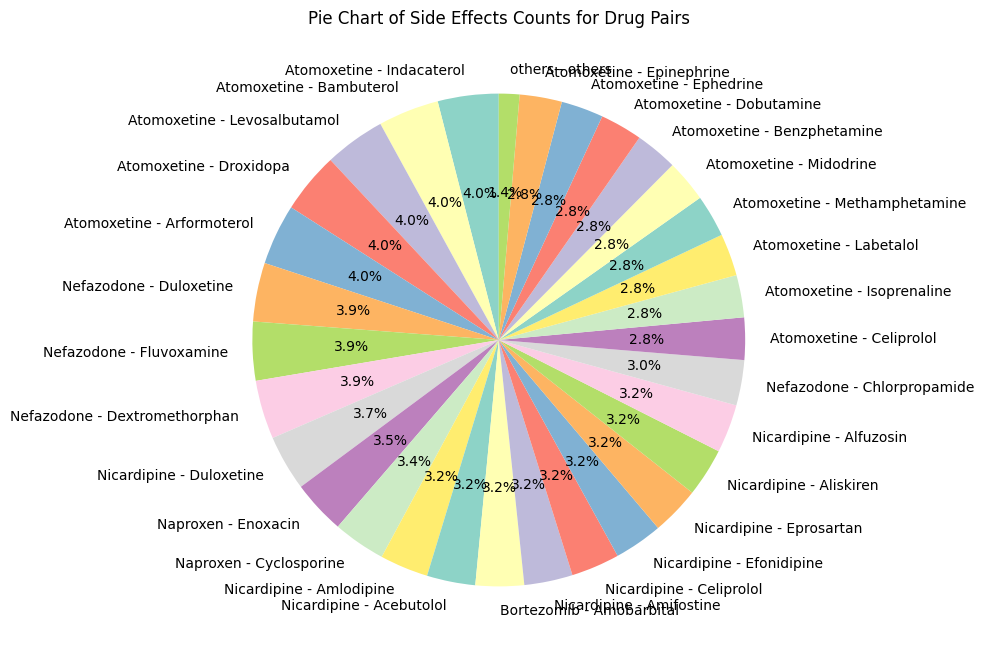

In [42]:
data = {
    'drugA': ['Atomoxetine', 'Atomoxetine', 'Atomoxetine', 'Atomoxetine', 'Atomoxetine', 'Nefazodone',
              'Nefazodone', 'Nefazodone', 'Nicardipine', 'Naproxen', 'Naproxen', 'Nicardipine',
              'Nicardipine', 'Bortezomib', 'Nicardipine', 'Nicardipine', 'Nicardipine', 'Nicardipine',
              'Nicardipine', 'Nicardipine', 'Nefazodone', 'Atomoxetine', 'Atomoxetine', 'Atomoxetine',
              'Atomoxetine', 'Atomoxetine', 'Atomoxetine', 'Atomoxetine', 'Atomoxetine', 'Atomoxetine',
             'others'],
    'drugB': ['Indacaterol', 'Bambuterol', 'Levosalbutamol', 'Droxidopa', 'Arformoterol',
              'Duloxetine', 'Fluvoxamine', 'Dextromethorphan', 'Duloxetine', 'Enoxacin', 'Cyclosporine',
              'Amlodipine', 'Acebutolol', 'Amobarbital', 'Amifostine', 'Celiprolol', 'Efonidipine',
              'Eprosartan', 'Aliskiren', 'Alfuzosin', 'Chlorpropamide', 'Celiprolol', 'Isoprenaline',
              'Labetalol', 'Methamphetamine', 'Midodrine', 'Benzphetamine', 'Dobutamine', 'Ephedrine',
              'Epinephrine', 'others'],
    'side': [59, 59, 59, 59, 59, 57, 57, 57, 54, 52, 51, 47, 47, 47, 47, 47, 47, 47, 47, 47, 44, 41,
             41, 41, 41, 41, 41, 41, 41, 41,20]
}

df = pd.DataFrame(data)

# Create a pie chart for the 'side' column
plt.figure(figsize=(8, 8))
plt.pie(df['side'], labels=df['drugA'] + ' - ' + df['drugB'], autopct='%1.1f%%', startangle=90, colors=plt.cm.Set3.colors)
plt.title('Pie Chart of Side Effects Counts for Drug Pairs')
plt.show()

### the 30 drugs with the most side effect counts in the horizontal bar plot

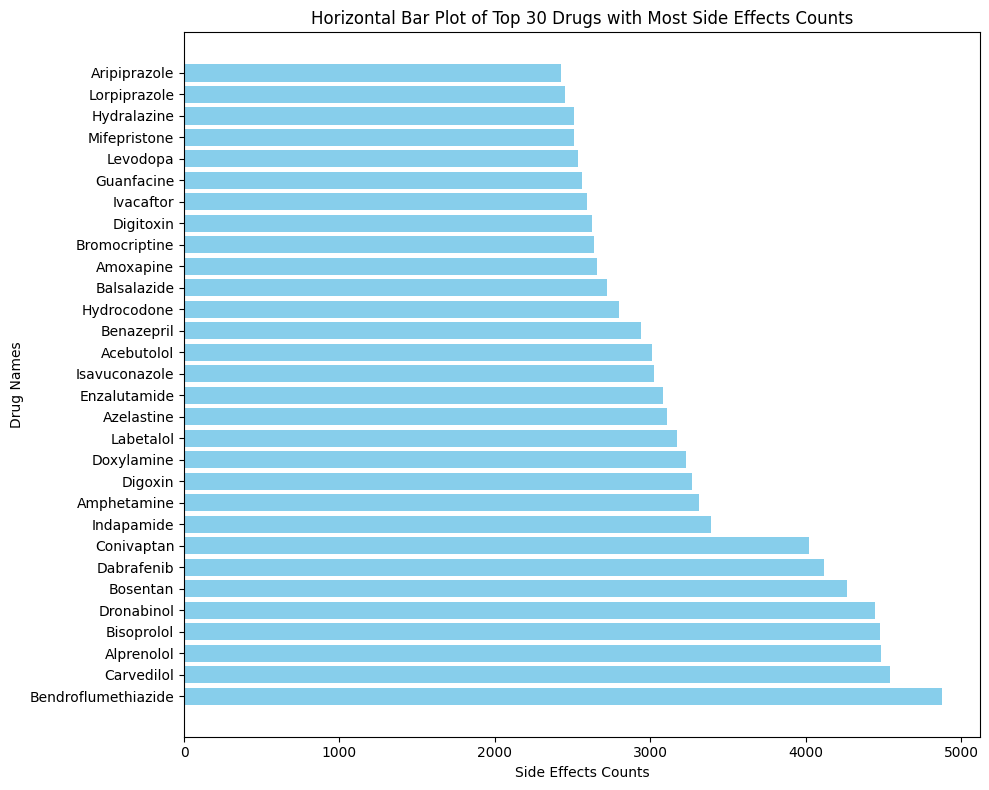

In [43]:
merged_df = pd.merge(extraction, df_drug, left_on=extraction['drugA'].str.lower(), right_on=df_drug['name'].str.lower(), how='inner')

grouped_df_drug = merged_df.groupby('name').sum()['side'].reset_index()

# Sort the DataFrame by 'side' column in descending order
grouped_df_drug_sorted = grouped_df_drug.sort_values(by='side', ascending=False)

# Select the top 30 rows
top_30_drugs = grouped_df_drug_sorted.head(30)

# Create a horizontal bar plot for the top 30 drugs with most side effects counts
plt.figure(figsize=(10, 8))
plt.barh(top_30_drugs['name'], top_30_drugs['side'], color='skyblue')
plt.xlabel('Side Effects Counts')
plt.ylabel('Drug Names')
plt.title('Horizontal Bar Plot of Top 30 Drugs with Most Side Effects Counts')
plt.tight_layout()
plt.show()

### horizontal bar plot with the 30 drugs having the least side effects counts

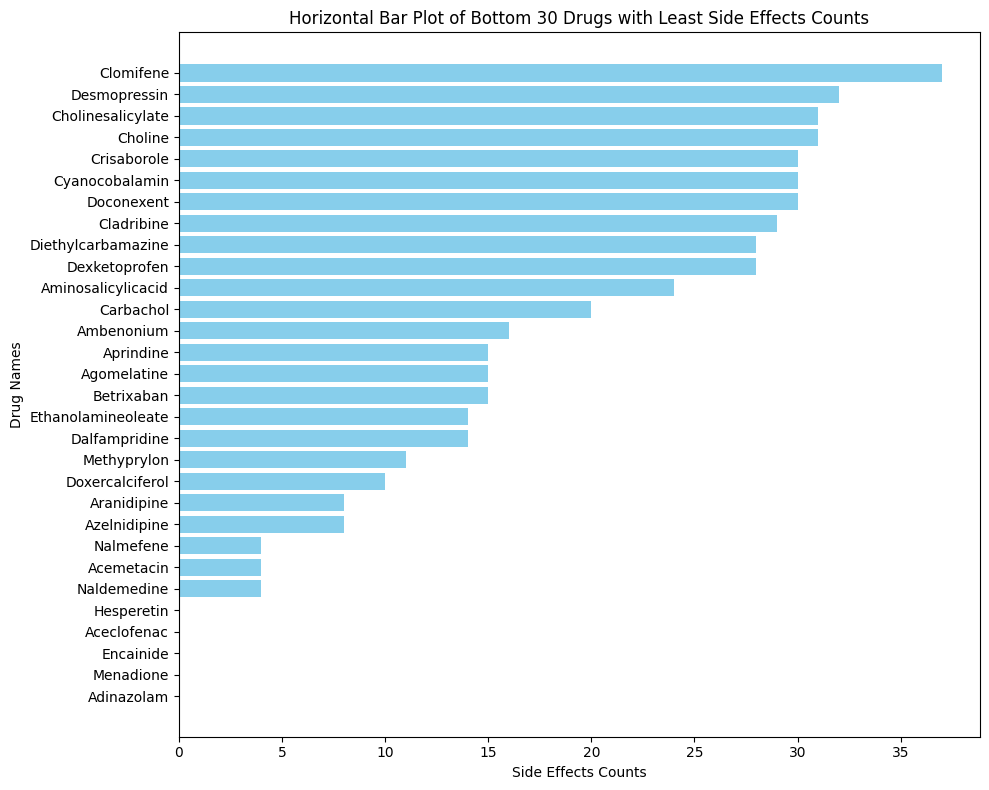

In [44]:
grouped_df_drug_sorted = grouped_df_drug.sort_values(by='side', ascending=True)

# Select the top 30 rows
bottom_30_drugs = grouped_df_drug_sorted.head(30)

# Create a horizontal bar plot for the bottom 30 drugs with least side effects counts
plt.figure(figsize=(10, 8))
plt.barh(bottom_30_drugs['name'], bottom_30_drugs['side'], color='skyblue')
plt.xlabel('Side Effects Counts')
plt.ylabel('Drug Names')
plt.title('Horizontal Bar Plot of Bottom 30 Drugs with Least Side Effects Counts')
plt.tight_layout()
plt.show()

### stacked area chart for Side Effects Counts for Drug Pairs

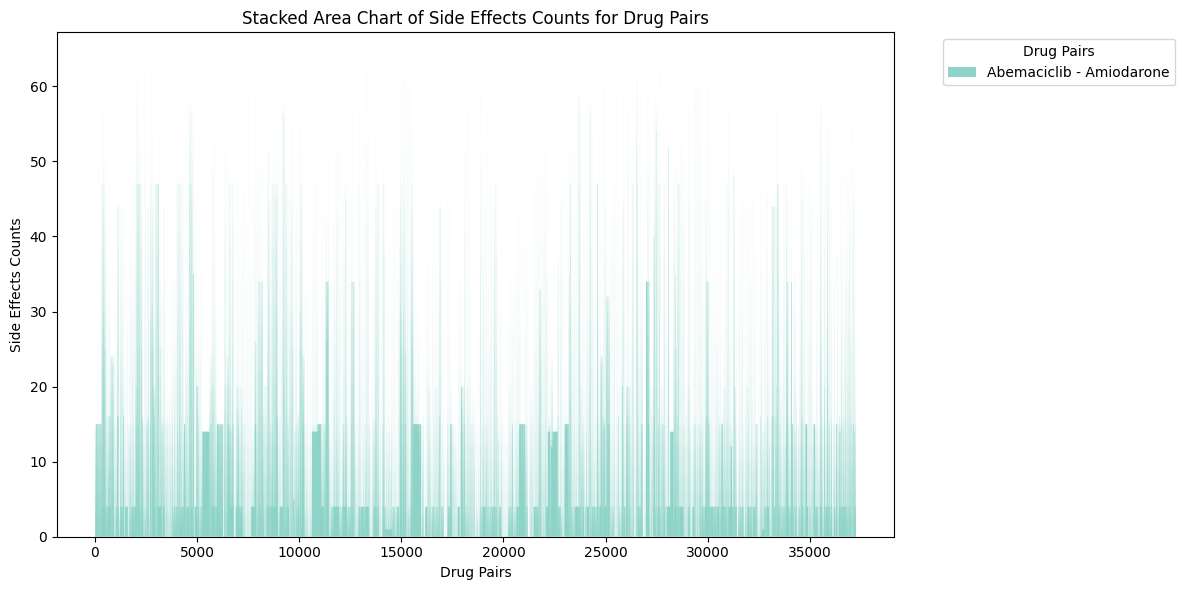

In [45]:
df = extraction
# Create a stacked area chart
plt.figure(figsize=(12, 6))

# Set numerical values for drug pairs
df['value'] = range(1, len(df) + 1)

# Create stacked area chart
plt.stackplot(df['value'], df['side'], labels=df['drugA'] + ' - ' + df['drugB'], colors=plt.cm.Set3.colors)

# Add labels and a legend
plt.xlabel('Drug Pairs')
plt.ylabel('Side Effects Counts')
plt.title('Stacked Area Chart of Side Effects Counts for Drug Pairs')
plt.legend(title='Drug Pairs', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


### plotting the distrubution of presence of proteins P11712 and Q14524 for each drug

In [46]:
# Aggregating side effects for each drug in the first dataset
df_side_effects_agg = extraction.groupby('drugA').agg({'side': 'sum'}).reset_index()

# Merging the aggregated side effects data with the second dataset based on drug names
df_merged = pd.merge(df_side_effects_agg, df_drug, left_on='drugA', right_on='name', how='inner')

# Dropping duplicate columns
df_merged.drop(columns=['name'], inplace=True)

print('Merged Data:')
df_merged.head()

Merged Data:


,drugA,side,O14717,O43451,Q00536,P08172,O00238,P00533,F1L7U3,Q01959,...,C0038273,C0042903,C0349667,C1696575,C0852973,C0221016,C1112175,C0235296,C0919884,C0948930
0,Abemaciclib,126,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Abiraterone,2298,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Acebutolol,3011,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Aceclofenac,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,Acemetacin,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


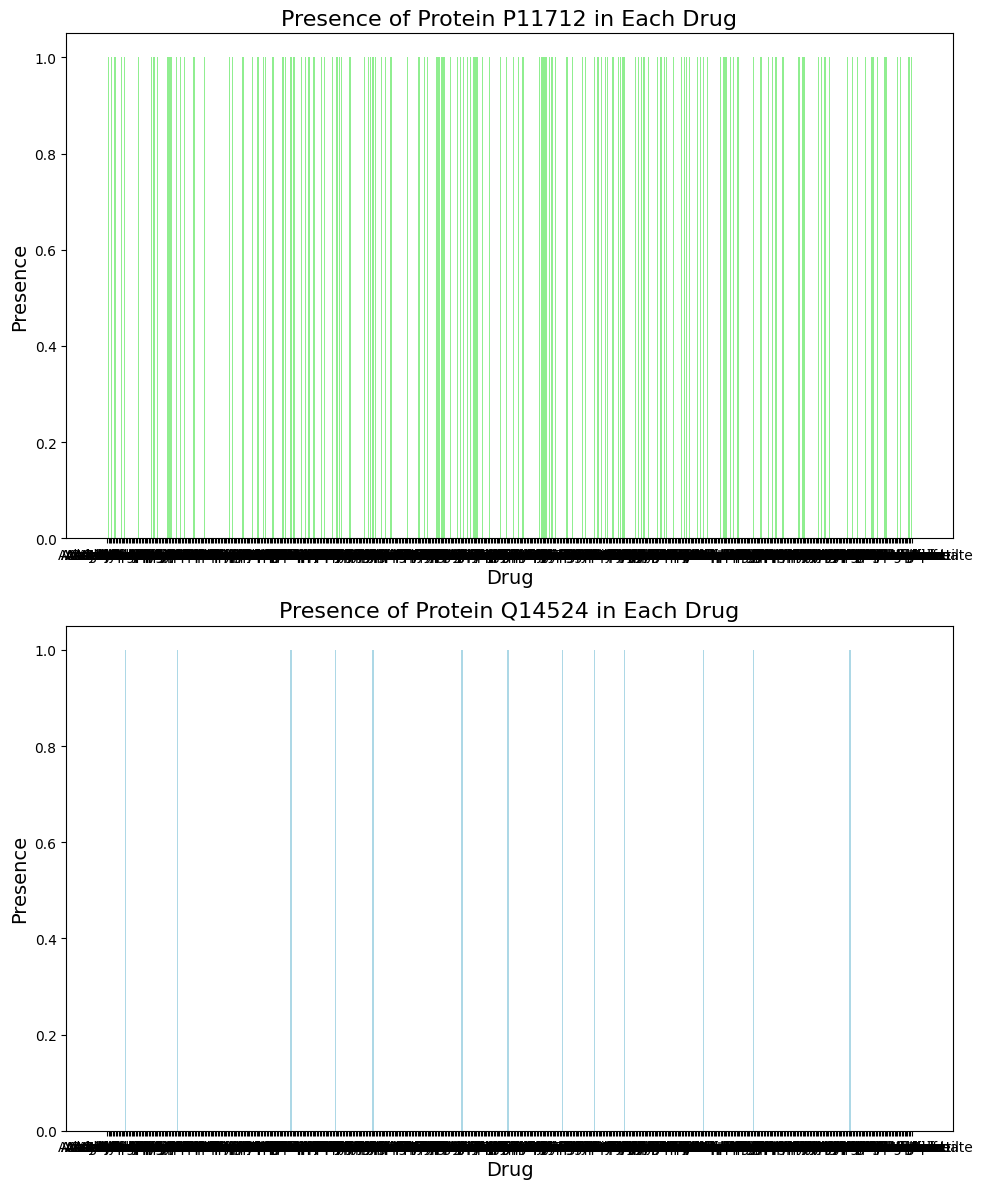

In [47]:
# Plotting the presence of proteins P00325 and Q16512 for each drug
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Plot for P00325
axs[0].bar(df_merged['drugA'], df_merged['P11712'], color='lightgreen')
axs[0].set_title('Presence of Protein P11712 in Each Drug', fontsize=16)
axs[0].set_xlabel('Drug', fontsize=14)
axs[0].set_ylabel('Presence', fontsize=14)

# Plot for Q16512
axs[1].bar(df_merged['drugA'], df_merged['Q14524'], color='lightblue')
axs[1].set_title('Presence of Protein Q14524 in Each Drug', fontsize=16)
axs[1].set_xlabel('Drug', fontsize=14)
axs[1].set_ylabel('Presence', fontsize=14)

plt.tight_layout()
plt.show()

### Features with more than 5 drugs having value 1

In [48]:
# Select only the columns containing protein presence values (assuming they are all numeric columns)
presence_columns = df_drug.columns[df_drug.columns.str.startswith('P') | df_drug.columns.str.startswith('Q')]

# Count the number of drugs with value 1 in each column
count_per_column = df_drug[presence_columns].sum()

# Select columns where the count is greater than 5
columns_with_more_than_5_drugs = count_per_column[count_per_column > 5].index

# Display the result
print("Columns with more than 5 drugs having value 1:")
len(columns_with_more_than_5_drugs)


Columns with more than 5 drugs having value 1:


126

In [49]:
columns_with_more_than_5_drugs

Index(['P08172', 'P00533', 'Q01959', 'P04150', 'P19793', 'P07550', 'P18825',
       'P47869', 'P43681', 'P06401',
       ...
       'P10635', 'Q02928', 'P06133', 'P20815', 'P04798', 'P05181', 'P22310',
       'P35503', 'P33260', 'Q06278'],
      dtype='object', length=126)

### Features with more than 10 drugs having value 1

In [50]:
columns_with_more_than_10_drugs = count_per_column[count_per_column > 10].index

# Display the result
print("Columns with more than 10 drugs having value 1:")
len(columns_with_more_than_10_drugs)

Columns with more than 10 drugs having value 1:


70

### Features with more than 100 drugs having value 1

In [51]:
columns_with_more_than_100_drugs = count_per_column[count_per_column > 100].index

# Display the result
print("Columns with more than 100 drugs having value 1:")
len(columns_with_more_than_100_drugs)

Columns with more than 100 drugs having value 1:


7

In [52]:
columns_with_more_than_100_drugs

Index(['P10632', 'P33261', 'P05177', 'P08684', 'P11712', 'P10635', 'P20815'], dtype='object')

In [53]:
drugs_in_P20815 = df_drug.loc[df_drug['P20815'] == 1, 'name']

# Display the result
print("Drugs with value 1 in column 'P20815':")
drugs_in_P20815

Drugs with value 1 in column 'P20815':


4                   Caffeine
6                 Argatroban
8      Fluticasonepropionate
9               Cyclosporine
14                 Estradiol
               ...          
530                Ibrutinib
535         Estradiolacetate
556         Deutetrabenazine
560                Cisapride
571               Crizotinib
Name: name, Length: 102, dtype: object

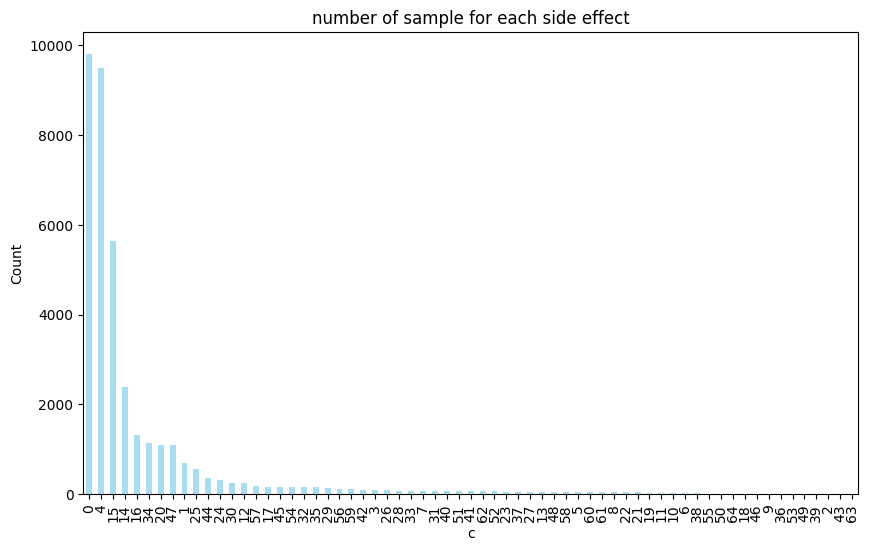

In [55]:
class_counts_dict = counter_plot(extraction,'side')

##### 5 most common side effects are 0, 4, 15, 14, 16

> #### analyse side effect 0

##### most common drugs 

In [56]:
class_0_data = extraction[extraction['side'] == 0]

# Group by drug and calculate the mean side effect value for each drug
mean_side_effect_per_drug = class_0_data.groupby('drugA')['side'].mean().reset_index()

# Sort the drugs based on mean side effect value in descending order
top_5_drugs = mean_side_effect_per_drug.sort_values(by='side', ascending=False).head(5)

# Display the top 5 drugs
print("Top 5 drugs for side effect class 0:")
print(top_5_drugs[['drugA', 'side']])

Top 5 drugs for side effect class 0:
           drugA  side
386  Nicardipine   0.0
0    Abemaciclib   0.0
1    Abiraterone   0.0
347    Mestranol   0.0
348    Methadone   0.0


##### common features in these drugs

In [57]:
drugs_of_interest = {'Abemaciclib','Isoniazid', 'Hexobarbital','Hesperetin','Halothane'}

# Dictionary to store the result
result_dict = {}

# Iterate over each drug
for drug in drugs_of_interest:
    # Filter the DataFrame for the specified drug and get columns with value 1
    columns_with_value_1 = side_df.loc[side_df['name'] == drug, side_df.columns[1:]].columns[side_df.loc[side_df['name'] == drug, side_df.columns[1:]].eq(1).any()]

    # Add to the dictionary
    result_dict[drug] = list(columns_with_value_1)

# Extract the columns for each drug in a list
columns_per_drug = [set(result_dict[drug]) for drug in drugs_of_interest]

# Find the common columns using set intersection
common_columns = set.intersection(*columns_per_drug)

# Display the common columns
print("Common sides:", common_columns)

Common sides: {'C0235874', 'C0151905'}


In [58]:
result_dict = {}

# Iterate over each drug
for drug in drugs_of_interest:
    # Filter the DataFrame for the specified drug and get columns with value 1
    columns_with_value_1 = target_df.loc[target_df['name'] == drug, target_df.columns[1:]].columns[target_df.loc[target_df['name'] == drug, target_df.columns[1:]].eq(1).any()]

    # Add to the dictionary
    result_dict[drug] = list(columns_with_value_1)

# Extract the columns for each drug in a list
columns_per_drug = [set(result_dict[drug]) for drug in drugs_of_interest]

# Find the common columns using set intersection
common_columns = set.intersection(*columns_per_drug)

# Display the common columns
print("Common targets:", common_columns)

Common targets: set()


In [59]:
result_dict = {}

# Iterate over each drug
for drug in drugs_of_interest:
    # Filter the DataFrame for the specified drug and get columns with value 1
    columns_with_value_1 = pathway_df.loc[pathway_df['name'] == drug, pathway_df.columns[1:]].columns[pathway_df.loc[pathway_df['name'] == drug, pathway_df.columns[1:]].eq(1).any()]

    # Add to the dictionary
    result_dict[drug] = list(columns_with_value_1)

# Extract the columns for each drug in a list
columns_per_drug = [set(result_dict[drug]) for drug in drugs_of_interest]

# Find the common columns using set intersection
common_columns = set.intersection(*columns_per_drug)

# Display the common columns
print("Common pathway:", common_columns)

Common pathway: set()


In [60]:
result_dict = {}

# Iterate over each drug
for drug in drugs_of_interest:
    # Filter the DataFrame for the specified drug and get columns with value 1
    columns_with_value_1 = smile_df.loc[smile_df['name'] == drug, smile_df.columns[1:]].columns[smile_df.loc[smile_df['name'] == drug, smile_df.columns[1:]].eq(1).any()]

    # Add to the dictionary
    result_dict[drug] = list(columns_with_value_1)

# Extract the columns for each drug in a list
columns_per_drug = [set(result_dict[drug]) for drug in drugs_of_interest]

# Find the common columns using set intersection
common_columns = set.intersection(*columns_per_drug)

# Display the common columns
print("Common smile:", common_columns)

Common smile: {'344', '284', '9', '283'}


In [61]:
result_dict = {}

# Iterate over each drug
for drug in drugs_of_interest:
    # Filter the DataFrame for the specified drug and get columns with value 1
    columns_with_value_1 = enzyme_df.loc[enzyme_df['name'] == drug, enzyme_df.columns[1:]].columns[enzyme_df.loc[enzyme_df['name'] == drug, enzyme_df.columns[1:]].eq(1).any()]

    # Add to the dictionary
    result_dict[drug] = list(columns_with_value_1)

# Extract the columns for each drug in a list
columns_per_drug = [set(result_dict[drug]) for drug in drugs_of_interest]

# Find the common columns using set intersection
common_columns = set.intersection(*columns_per_drug)

# Display the common columns
print("Common enzyme:", common_columns)

Common enzyme: set()


> #### analyse class side effect 4

##### most common drugs 

In [62]:
class_0_data = extraction[extraction['side'] == 4]

# Group by drug and calculate the mean side effect value for each drug
mean_side_effect_per_drug = class_0_data.groupby('drugA')['side'].mean().reset_index()

# Sort the drugs based on mean side effect value in descending order
top_5_drugs = mean_side_effect_per_drug.sort_values(by='side', ascending=False).head(5)

# Display the top 5 drugs
print("Top 5 drugs for side effect class 4:")
print(top_5_drugs[['drugA', 'side']])

Top 5 drugs for side effect class 4:
           drugA  side
421  Nicardipine   4.0
0    Abemaciclib   4.0
1    Abiraterone   4.0
2     Acebutolol   4.0
3     Acemetacin   4.0


##### common features in these drugs

In [63]:
drugs_of_interest = {'Abemaciclib','Formoterol', 'Hydrocodone','Hydralazine','Homatropine'}

# Dictionary to store the result
result_dict = {}

# Iterate over each drug
for drug in drugs_of_interest:
    # Filter the DataFrame for the specified drug and get columns with value 1
    columns_with_value_1 = side_df.loc[side_df['name'] == drug, side_df.columns[1:]].columns[side_df.loc[side_df['name'] == drug, side_df.columns[1:]].eq(1).any()]

    # Add to the dictionary
    result_dict[drug] = list(columns_with_value_1)

# Extract the columns for each drug in a list
columns_per_drug = [set(result_dict[drug]) for drug in drugs_of_interest]

# Find the common columns using set intersection
common_columns = set.intersection(*columns_per_drug)

# Display the common columns
print("Common sides:", common_columns)

Common sides: set()


In [64]:
result_dict = {}

# Iterate over each drug
for drug in drugs_of_interest:
    # Filter the DataFrame for the specified drug and get columns with value 1
    columns_with_value_1 = target_df.loc[target_df['name'] == drug, target_df.columns[1:]].columns[target_df.loc[target_df['name'] == drug, target_df.columns[1:]].eq(1).any()]

    # Add to the dictionary
    result_dict[drug] = list(columns_with_value_1)

# Extract the columns for each drug in a list
columns_per_drug = [set(result_dict[drug]) for drug in drugs_of_interest]

# Find the common columns using set intersection
common_columns = set.intersection(*columns_per_drug)

# Display the common columns
print("Common targets:", common_columns)

Common targets: set()


In [65]:
result_dict = {}

# Iterate over each drug
for drug in drugs_of_interest:
    # Filter the DataFrame for the specified drug and get columns with value 1
    columns_with_value_1 = pathway_df.loc[pathway_df['name'] == drug, pathway_df.columns[1:]].columns[pathway_df.loc[pathway_df['name'] == drug, pathway_df.columns[1:]].eq(1).any()]

    # Add to the dictionary
    result_dict[drug] = list(columns_with_value_1)

# Extract the columns for each drug in a list
columns_per_drug = [set(result_dict[drug]) for drug in drugs_of_interest]

# Find the common columns using set intersection
common_columns = set.intersection(*columns_per_drug)

# Display the common columns
print("Common pathway:", common_columns)

Common pathway: set()


In [66]:
result_dict = {}

# Iterate over each drug
for drug in drugs_of_interest:
    # Filter the DataFrame for the specified drug and get columns with value 1
    columns_with_value_1 = smile_df.loc[smile_df['name'] == drug, smile_df.columns[1:]].columns[smile_df.loc[smile_df['name'] == drug, smile_df.columns[1:]].eq(1).any()]

    # Add to the dictionary
    result_dict[drug] = list(columns_with_value_1)

# Extract the columns for each drug in a list
columns_per_drug = [set(result_dict[drug]) for drug in drugs_of_interest]

# Find the common columns using set intersection
common_columns = set.intersection(*columns_per_drug)

# Display the common columns
print("Common smile:", common_columns)

Common smile: {'660', '430', '333', '14', '710', '683', '344', '283', '370', '371', '356', '446', '578', '182', '285', '564', '688', '384', '595', '441', '709', '708', '416', '599', '640', '556', '582', '11', '284', '603', '608', '552', '9', '584', '351', '668', '524', '679', '434', '332', '664', '677', '470', '355', '516', '178', '345', '520', '10', '490', '185', '618', '696', '592', '634', '678', '365', '570'}


In [67]:
result_dict = {}

# Iterate over each drug
for drug in drugs_of_interest:
    # Filter the DataFrame for the specified drug and get columns with value 1
    columns_with_value_1 = enzyme_df.loc[enzyme_df['name'] == drug, enzyme_df.columns[1:]].columns[enzyme_df.loc[enzyme_df['name'] == drug, enzyme_df.columns[1:]].eq(1).any()]

    # Add to the dictionary
    result_dict[drug] = list(columns_with_value_1)

# Extract the columns for each drug in a list
columns_per_drug = [set(result_dict[drug]) for drug in drugs_of_interest]

# Find the common columns using set intersection
common_columns = set.intersection(*columns_per_drug)

# Display the common columns
print("Common enzyme:", common_columns)

Common enzyme: set()


> #### analyse side effect 15

##### most common drugs 

In [68]:
class_0_data = extraction[extraction['side'] == 15]

# Group by drug and calculate the mean side effect value for each drug
mean_side_effect_per_drug = class_0_data.groupby('drugA')['side'].mean().reset_index()

# Sort the drugs based on mean side effect value in descending order
top_5_drugs = mean_side_effect_per_drug.sort_values(by='side', ascending=False).head(5)

# Display the top 5 drugs
print("Top 5 drugs for side effect class 4:")
print(top_5_drugs[['drugA', 'side']])

Top 5 drugs for side effect class 4:
             drugA  side
452    Nicardipine  15.0
0      Abemaciclib  15.0
1      Abiraterone  15.0
2       Acebutolol  15.0
3    Acenocoumarol  15.0


##### common features in these drugs

In [69]:
drugs_of_interest = {'Abemaciclib','Formoterol', 'Hydrocodone','Hydralazine','Homatropine'}

# Dictionary to store the result
result_dict = {}

# Iterate over each drug
for drug in drugs_of_interest:
    # Filter the DataFrame for the specified drug and get columns with value 1
    columns_with_value_1 = side_df.loc[side_df['name'] == drug, side_df.columns[1:]].columns[side_df.loc[side_df['name'] == drug, side_df.columns[1:]].eq(1).any()]

    # Add to the dictionary
    result_dict[drug] = list(columns_with_value_1)

# Extract the columns for each drug in a list
columns_per_drug = [set(result_dict[drug]) for drug in drugs_of_interest]

# Find the common columns using set intersection
common_columns = set.intersection(*columns_per_drug)

# Display the common columns
print("Common sides:", common_columns)

Common sides: set()


In [70]:
result_dict = {}

# Iterate over each drug
for drug in drugs_of_interest:
    # Filter the DataFrame for the specified drug and get columns with value 1
    columns_with_value_1 = target_df.loc[target_df['name'] == drug, target_df.columns[1:]].columns[target_df.loc[target_df['name'] == drug, target_df.columns[1:]].eq(1).any()]

    # Add to the dictionary
    result_dict[drug] = list(columns_with_value_1)

# Extract the columns for each drug in a list
columns_per_drug = [set(result_dict[drug]) for drug in drugs_of_interest]

# Find the common columns using set intersection
common_columns = set.intersection(*columns_per_drug)

# Display the common columns
print("Common targets:", common_columns)

Common targets: set()


In [71]:
result_dict = {}

# Iterate over each drug
for drug in drugs_of_interest:
    # Filter the DataFrame for the specified drug and get columns with value 1
    columns_with_value_1 = pathway_df.loc[pathway_df['name'] == drug, pathway_df.columns[1:]].columns[pathway_df.loc[pathway_df['name'] == drug, pathway_df.columns[1:]].eq(1).any()]

    # Add to the dictionary
    result_dict[drug] = list(columns_with_value_1)

# Extract the columns for each drug in a list
columns_per_drug = [set(result_dict[drug]) for drug in drugs_of_interest]

# Find the common columns using set intersection
common_columns = set.intersection(*columns_per_drug)

# Display the common columns
print("Common pathway:", common_columns)

Common pathway: set()


In [72]:
result_dict = {}

# Iterate over each drug
for drug in drugs_of_interest:
    # Filter the DataFrame for the specified drug and get columns with value 1
    columns_with_value_1 = smile_df.loc[smile_df['name'] == drug, smile_df.columns[1:]].columns[smile_df.loc[smile_df['name'] == drug, smile_df.columns[1:]].eq(1).any()]

    # Add to the dictionary
    result_dict[drug] = list(columns_with_value_1)

# Extract the columns for each drug in a list
columns_per_drug = [set(result_dict[drug]) for drug in drugs_of_interest]

# Find the common columns using set intersection
common_columns = set.intersection(*columns_per_drug)

# Display the common columns
print("Common smile:", common_columns)

Common smile: {'660', '430', '333', '14', '710', '683', '344', '283', '370', '371', '356', '446', '578', '182', '285', '564', '688', '384', '595', '441', '709', '708', '416', '599', '640', '556', '582', '11', '284', '603', '608', '552', '9', '584', '351', '668', '524', '679', '434', '332', '664', '677', '470', '355', '516', '178', '345', '520', '10', '490', '185', '618', '696', '592', '634', '678', '365', '570'}


In [73]:
result_dict = {}

# Iterate over each drug
for drug in drugs_of_interest:
    # Filter the DataFrame for the specified drug and get columns with value 1
    columns_with_value_1 = enzyme_df.loc[enzyme_df['name'] == drug, enzyme_df.columns[1:]].columns[enzyme_df.loc[enzyme_df['name'] == drug, enzyme_df.columns[1:]].eq(1).any()]

    # Add to the dictionary
    result_dict[drug] = list(columns_with_value_1)

# Extract the columns for each drug in a list
columns_per_drug = [set(result_dict[drug]) for drug in drugs_of_interest]

# Find the common columns using set intersection
common_columns = set.intersection(*columns_per_drug)

# Display the common columns
print("Common enzyme:", common_columns)

Common enzyme: set()


> #### analyse side effect 14

##### most common drugs 

In [74]:
class_0_data = extraction[extraction['side'] == 14]

# Group by drug and calculate the mean side effect value for each drug
mean_side_effect_per_drug = class_0_data.groupby('drugA')['side'].mean().reset_index()

# Sort the drugs based on mean side effect value in descending order
top_5_drugs = mean_side_effect_per_drug.sort_values(by='side', ascending=False).head(5)

# Display the top 5 drugs
print("Top 5 drugs for side effect class 4:")
print(top_5_drugs[['drugA', 'side']])

Top 5 drugs for side effect class 4:
             drugA  side
400    Nicardipine  14.0
0      Abemaciclib  14.0
1      Abiraterone  14.0
2       Acebutolol  14.0
3    Acetaminophen  14.0


##### common features in these drugs

In [75]:
drugs_of_interest = {'Abemaciclib','Formoterol', 'Hydrocodone','Hydralazine','Homatropine'}

# Dictionary to store the result
result_dict = {}

# Iterate over each drug
for drug in drugs_of_interest:
    # Filter the DataFrame for the specified drug and get columns with value 1
    columns_with_value_1 = side_df.loc[side_df['name'] == drug, side_df.columns[1:]].columns[side_df.loc[side_df['name'] == drug, side_df.columns[1:]].eq(1).any()]

    # Add to the dictionary
    result_dict[drug] = list(columns_with_value_1)

# Extract the columns for each drug in a list
columns_per_drug = [set(result_dict[drug]) for drug in drugs_of_interest]

# Find the common columns using set intersection
common_columns = set.intersection(*columns_per_drug)

# Display the common columns
print("Common sides:", common_columns)

Common sides: set()


In [76]:
result_dict = {}

# Iterate over each drug
for drug in drugs_of_interest:
    # Filter the DataFrame for the specified drug and get columns with value 1
    columns_with_value_1 = target_df.loc[target_df['name'] == drug, target_df.columns[1:]].columns[target_df.loc[target_df['name'] == drug, target_df.columns[1:]].eq(1).any()]

    # Add to the dictionary
    result_dict[drug] = list(columns_with_value_1)

# Extract the columns for each drug in a list
columns_per_drug = [set(result_dict[drug]) for drug in drugs_of_interest]

# Find the common columns using set intersection
common_columns = set.intersection(*columns_per_drug)

# Display the common columns
print("Common targets:", common_columns)

Common targets: set()


In [77]:
result_dict = {}

# Iterate over each drug
for drug in drugs_of_interest:
    # Filter the DataFrame for the specified drug and get columns with value 1
    columns_with_value_1 = pathway_df.loc[pathway_df['name'] == drug, pathway_df.columns[1:]].columns[pathway_df.loc[pathway_df['name'] == drug, pathway_df.columns[1:]].eq(1).any()]

    # Add to the dictionary
    result_dict[drug] = list(columns_with_value_1)

# Extract the columns for each drug in a list
columns_per_drug = [set(result_dict[drug]) for drug in drugs_of_interest]

# Find the common columns using set intersection
common_columns = set.intersection(*columns_per_drug)

# Display the common columns
print("Common pathway:", common_columns)

Common pathway: set()


In [78]:
result_dict = {}

# Iterate over each drug
for drug in drugs_of_interest:
    # Filter the DataFrame for the specified drug and get columns with value 1
    columns_with_value_1 = smile_df.loc[smile_df['name'] == drug, smile_df.columns[1:]].columns[smile_df.loc[smile_df['name'] == drug, smile_df.columns[1:]].eq(1).any()]

    # Add to the dictionary
    result_dict[drug] = list(columns_with_value_1)

# Extract the columns for each drug in a list
columns_per_drug = [set(result_dict[drug]) for drug in drugs_of_interest]

# Find the common columns using set intersection
common_columns = set.intersection(*columns_per_drug)

# Display the common columns
print("Common smile:", common_columns)

Common smile: {'660', '430', '333', '14', '710', '683', '344', '283', '370', '371', '356', '446', '578', '182', '285', '564', '688', '384', '595', '441', '709', '708', '416', '599', '640', '556', '582', '11', '284', '603', '608', '552', '9', '584', '351', '668', '524', '679', '434', '332', '664', '677', '470', '355', '516', '178', '345', '520', '10', '490', '185', '618', '696', '592', '634', '678', '365', '570'}


In [79]:
result_dict = {}

# Iterate over each drug
for drug in drugs_of_interest:
    # Filter the DataFrame for the specified drug and get columns with value 1
    columns_with_value_1 = enzyme_df.loc[enzyme_df['name'] == drug, enzyme_df.columns[1:]].columns[enzyme_df.loc[enzyme_df['name'] == drug, enzyme_df.columns[1:]].eq(1).any()]

    # Add to the dictionary
    result_dict[drug] = list(columns_with_value_1)

# Extract the columns for each drug in a list
columns_per_drug = [set(result_dict[drug]) for drug in drugs_of_interest]

# Find the common columns using set intersection
common_columns = set.intersection(*columns_per_drug)

# Display the common columns
print("Common enzyme:", common_columns)

Common enzyme: set()


> #### analyse side effect 16

##### most common drugs

In [80]:
class_0_data = extraction[extraction['side'] == 16]

# Group by drug and calculate the mean side effect value for each drug
mean_side_effect_per_drug = class_0_data.groupby('drugA')['side'].mean().reset_index()

# Sort the drugs based on mean side effect value in descending order
top_5_drugs = mean_side_effect_per_drug.sort_values(by='side', ascending=False).head(5)

# Display the top 5 drugs
print("Top 5 drugs for side effect class 4:")
print(top_5_drugs[['drugA', 'side']])

Top 5 drugs for side effect class 4:
           drugA  side
240  Miltefosine  16.0
241    Minaprine  16.0
242   Mirabegron  16.0
243  Mitiglinide  16.0
244     Morphine  16.0


##### common features in these drugs

In [81]:
drugs_of_interest = {'Abemaciclib','Formoterol', 'Hydrocodone','Hydralazine','Homatropine'}

# Dictionary to store the result
result_dict = {}

# Iterate over each drug
for drug in drugs_of_interest:
    # Filter the DataFrame for the specified drug and get columns with value 1
    columns_with_value_1 = side_df.loc[side_df['name'] == drug, side_df.columns[1:]].columns[side_df.loc[side_df['name'] == drug, side_df.columns[1:]].eq(1).any()]

    # Add to the dictionary
    result_dict[drug] = list(columns_with_value_1)

# Extract the columns for each drug in a list
columns_per_drug = [set(result_dict[drug]) for drug in drugs_of_interest]

# Find the common columns using set intersection
common_columns = set.intersection(*columns_per_drug)

# Display the common columns
print("Common sides:", common_columns)

Common sides: set()


In [82]:
result_dict = {}

# Iterate over each drug
for drug in drugs_of_interest:
    # Filter the DataFrame for the specified drug and get columns with value 1
    columns_with_value_1 = target_df.loc[target_df['name'] == drug, target_df.columns[1:]].columns[target_df.loc[target_df['name'] == drug, target_df.columns[1:]].eq(1).any()]

    # Add to the dictionary
    result_dict[drug] = list(columns_with_value_1)

# Extract the columns for each drug in a list
columns_per_drug = [set(result_dict[drug]) for drug in drugs_of_interest]

# Find the common columns using set intersection
common_columns = set.intersection(*columns_per_drug)

# Display the common columns
print("Common targets:", common_columns)

Common targets: set()


In [83]:
result_dict = {}

# Iterate over each drug
for drug in drugs_of_interest:
    # Filter the DataFrame for the specified drug and get columns with value 1
    columns_with_value_1 = pathway_df.loc[pathway_df['name'] == drug, pathway_df.columns[1:]].columns[pathway_df.loc[pathway_df['name'] == drug, pathway_df.columns[1:]].eq(1).any()]

    # Add to the dictionary
    result_dict[drug] = list(columns_with_value_1)

# Extract the columns for each drug in a list
columns_per_drug = [set(result_dict[drug]) for drug in drugs_of_interest]

# Find the common columns using set intersection
common_columns = set.intersection(*columns_per_drug)

# Display the common columns
print("Common pathway:", common_columns)

Common pathway: set()


In [84]:
result_dict = {}

# Iterate over each drug
for drug in drugs_of_interest:
    # Filter the DataFrame for the specified drug and get columns with value 1
    columns_with_value_1 = smile_df.loc[smile_df['name'] == drug, smile_df.columns[1:]].columns[smile_df.loc[smile_df['name'] == drug, smile_df.columns[1:]].eq(1).any()]

    # Add to the dictionary
    result_dict[drug] = list(columns_with_value_1)

# Extract the columns for each drug in a list
columns_per_drug = [set(result_dict[drug]) for drug in drugs_of_interest]

# Find the common columns using set intersection
common_columns = set.intersection(*columns_per_drug)

# Display the common columns
print("Common smile:", common_columns)

Common smile: {'660', '430', '333', '14', '710', '683', '344', '283', '370', '371', '356', '446', '578', '182', '285', '564', '688', '384', '595', '441', '709', '708', '416', '599', '640', '556', '582', '11', '284', '603', '608', '552', '9', '584', '351', '668', '524', '679', '434', '332', '664', '677', '470', '355', '516', '178', '345', '520', '10', '490', '185', '618', '696', '592', '634', '678', '365', '570'}


In [85]:
result_dict = {}

# Iterate over each drug
for drug in drugs_of_interest:
    # Filter the DataFrame for the specified drug and get columns with value 1
    columns_with_value_1 = enzyme_df.loc[enzyme_df['name'] == drug, enzyme_df.columns[1:]].columns[enzyme_df.loc[enzyme_df['name'] == drug, enzyme_df.columns[1:]].eq(1).any()]

    # Add to the dictionary
    result_dict[drug] = list(columns_with_value_1)

# Extract the columns for each drug in a list
columns_per_drug = [set(result_dict[drug]) for drug in drugs_of_interest]

# Find the common columns using set intersection
common_columns = set.intersection(*columns_per_drug)

# Display the common columns
print("Common enzyme:", common_columns)

Common enzyme: set()


Average Count of true values: 18.379812938425566


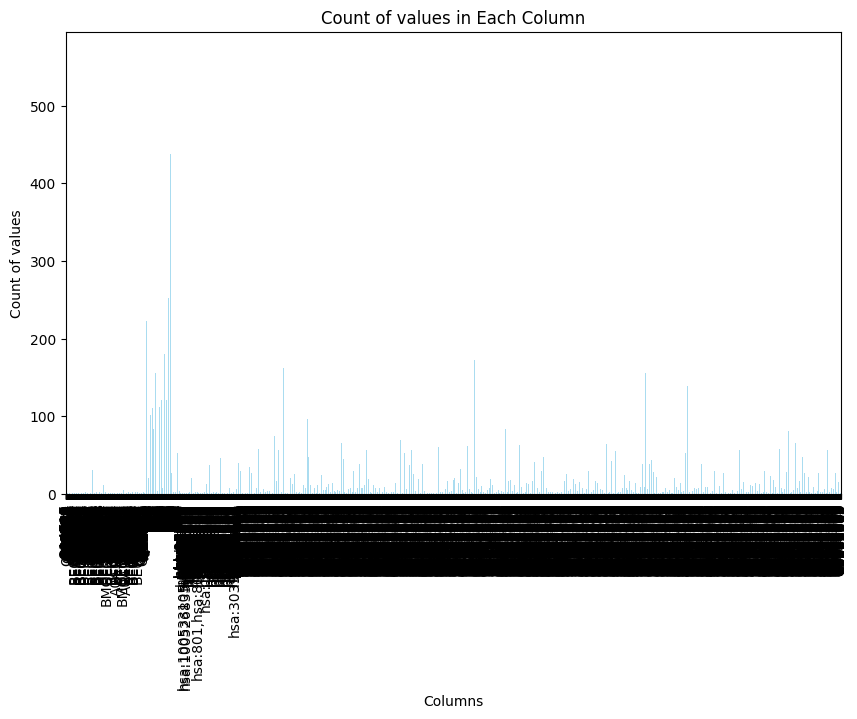

In [86]:
EDA_maker(df_drug)

### analyze outliers for drug info

In [87]:
summary_stats = df_drug.describe()
print(summary_stats)

           O14717      O43451      Q00536      P08172      O00238      P00533  \
count  572.000000  572.000000  572.000000  572.000000  572.000000  572.000000   
mean     0.001748    0.001748    0.001748    0.047203    0.001748    0.013986   
std      0.041812    0.041812    0.041812    0.212258    0.041812    0.117535   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

           F1L7U3      Q01959      P22694      Q15418  ...    C0038273  \
count  572.000000  572.000000  572.000000  572.000000  ...  572.000000   
mean     0.001748    0.038462    0.001748    0.001748  ...    0.020979   
std      0.041812    0.192476    0.041812    0.0

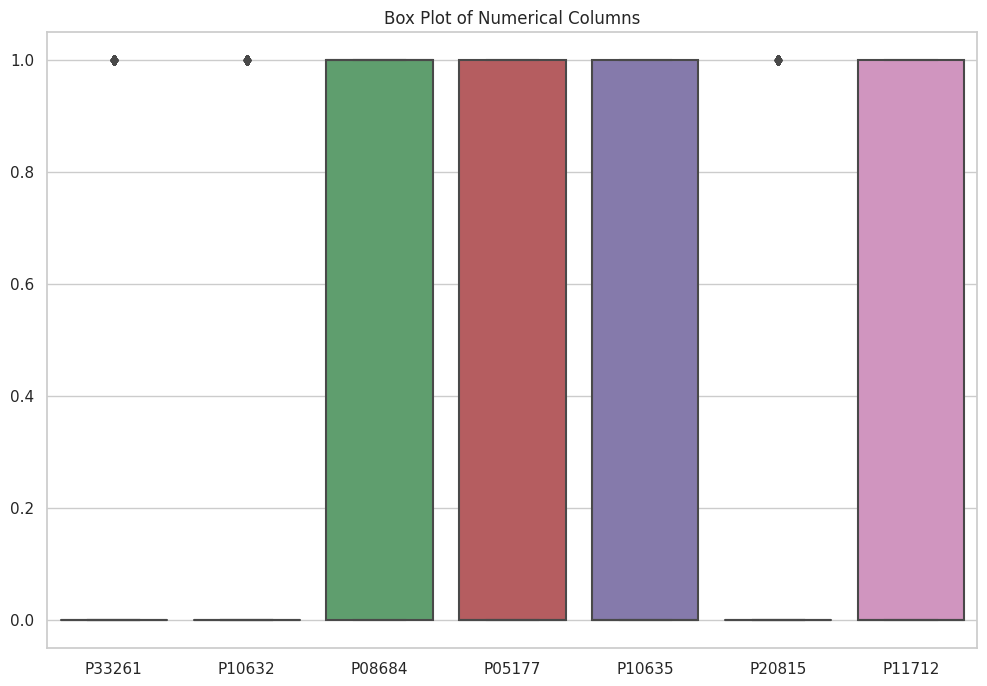

In [88]:
# we choose  most probable columns
NUMERICAL_COLUMNS = ['P33261', 'P10632', 'P08684', 'P05177', 'P10635', 'P20815', 'P11712']


sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_drug[NUMERICAL_COLUMNS])
plt.title("Box Plot of Numerical Columns")
plt.show()

In [89]:
z_scores = stats.zscore(df_drug[NUMERICAL_COLUMNS])
abs_z_scores = np.abs(z_scores)
outliers = (abs_z_scores > 3).all(axis=1)

# Display rows with outliers
df_drug[outliers]

,name,O14717,O43451,Q00536,P08172,O00238,P00533,F1L7U3,Q01959,P22694,...,C0038273,C0042903,C0349667,C1696575,C0852973,C0221016,C1112175,C0235296,C0919884,C0948930


In [90]:
df_drug[outliers]

,name,O14717,O43451,Q00536,P08172,O00238,P00533,F1L7U3,Q01959,P22694,...,C0038273,C0042903,C0349667,C1696575,C0852973,C0221016,C1112175,C0235296,C0919884,C0948930


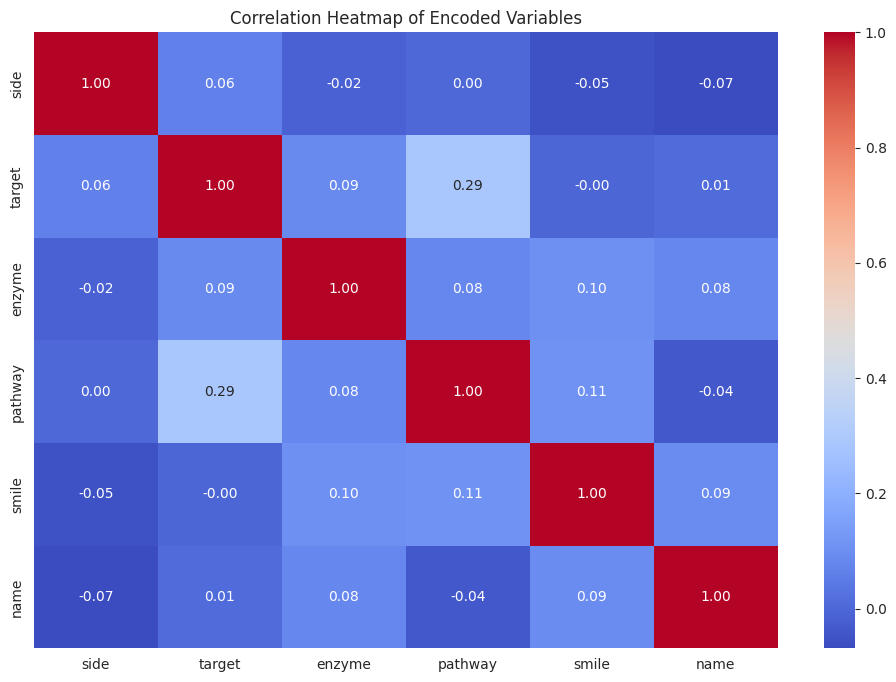

In [8]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encoding categorical variables to prepare for correlation analysis
le = LabelEncoder()
df_encoded = df_drug.apply(lambda col: le.fit_transform(col) if col.dtype == 'object' else col)

# Calculating correlation matrix
corr_matrix = df_encoded.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Encoded Variables')
plt.show()

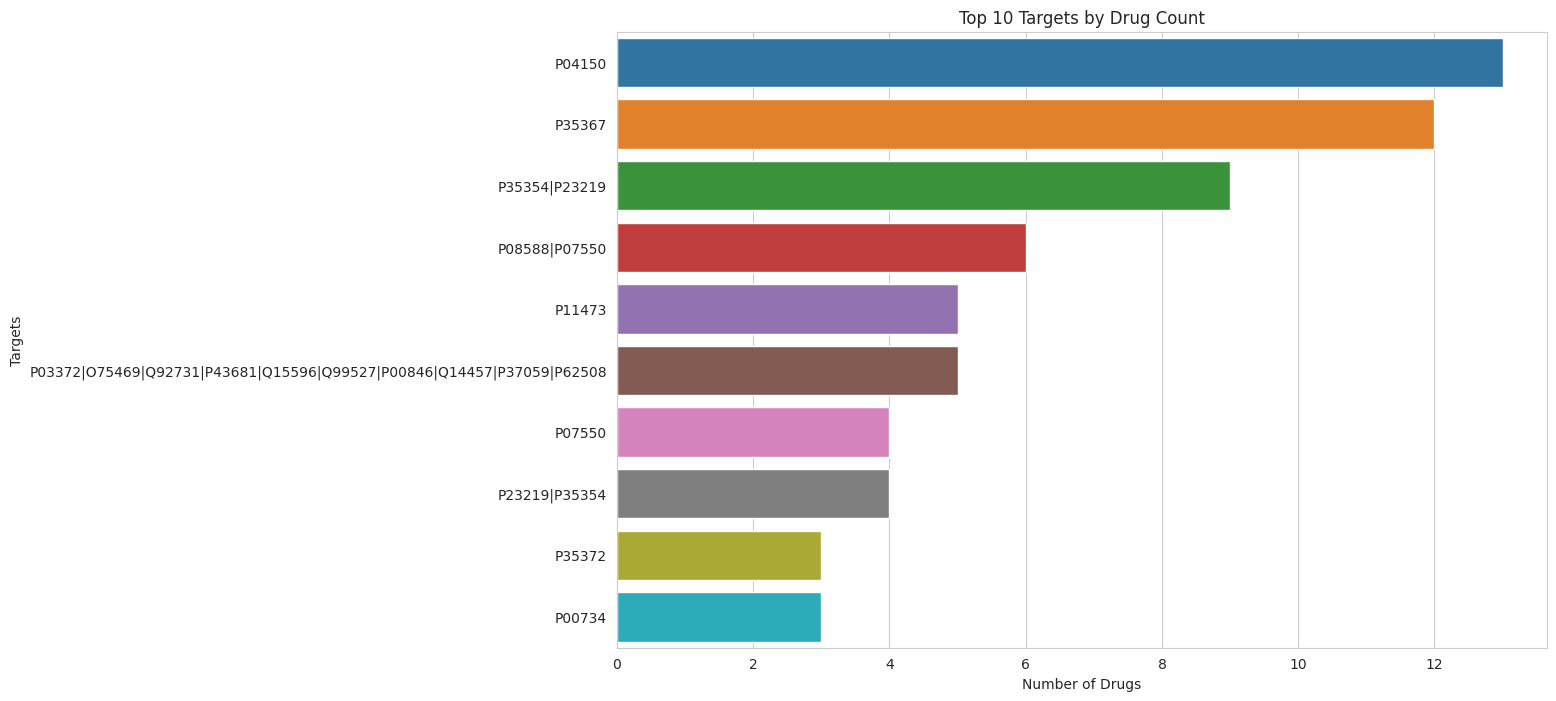

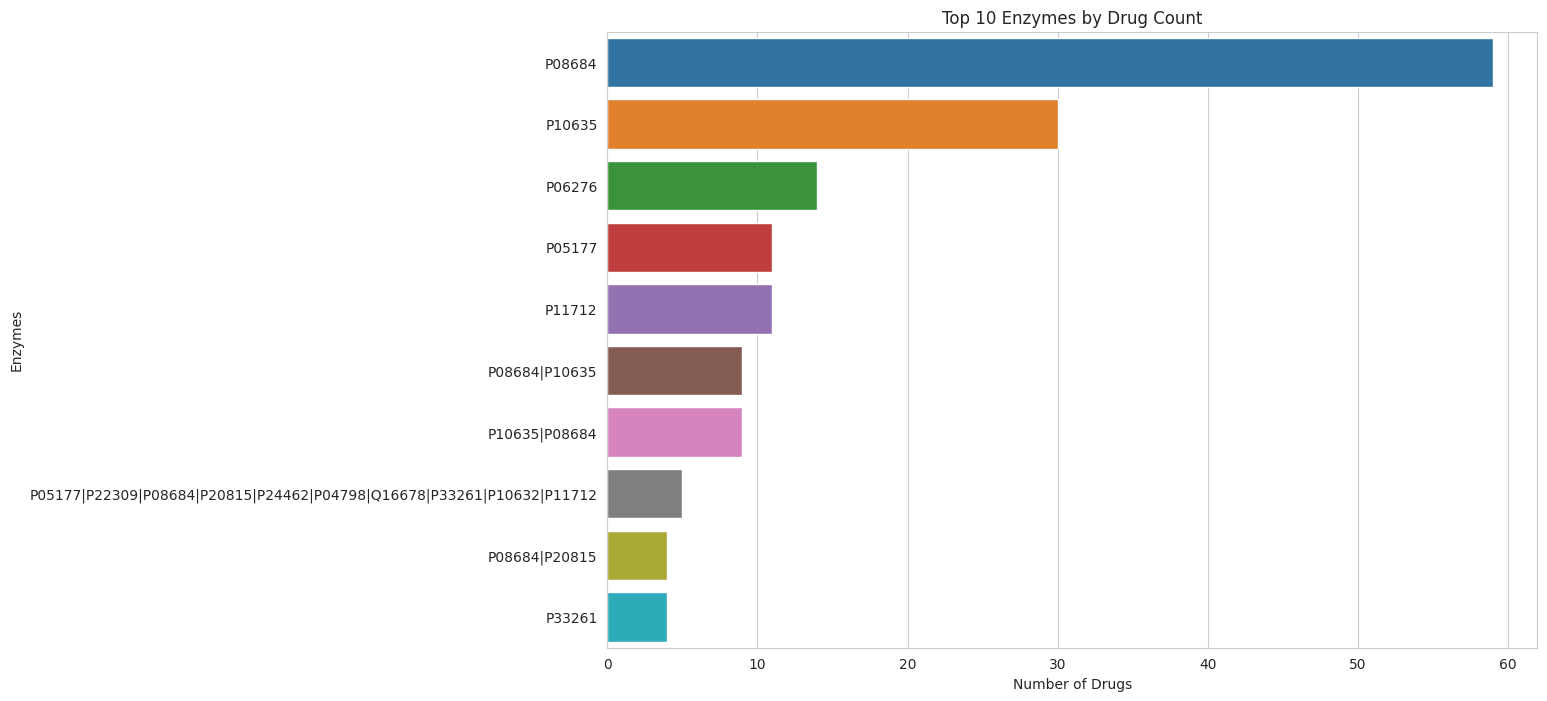

In [9]:
# Analyzing the distribution of drugs across different targets and enzymes
target_counts = df_drug['target'].value_counts().head(10)
enzyme_counts = df_drug['enzyme'].value_counts().head(10)

# Plotting the distribution of drugs across targets
plt.figure(figsize=(12, 8))
sns.barplot(x=target_counts.values, y=target_counts.index)
plt.title('Top 10 Targets by Drug Count')
plt.xlabel('Number of Drugs')
plt.ylabel('Targets')
plt.show()

# Plotting the distribution of drugs across enzymes
plt.figure(figsize=(12, 8))
sns.barplot(x=enzyme_counts.values, y=enzyme_counts.index)
plt.title('Top 10 Enzymes by Drug Count')
plt.xlabel('Number of Drugs')
plt.ylabel('Enzymes')
plt.show()

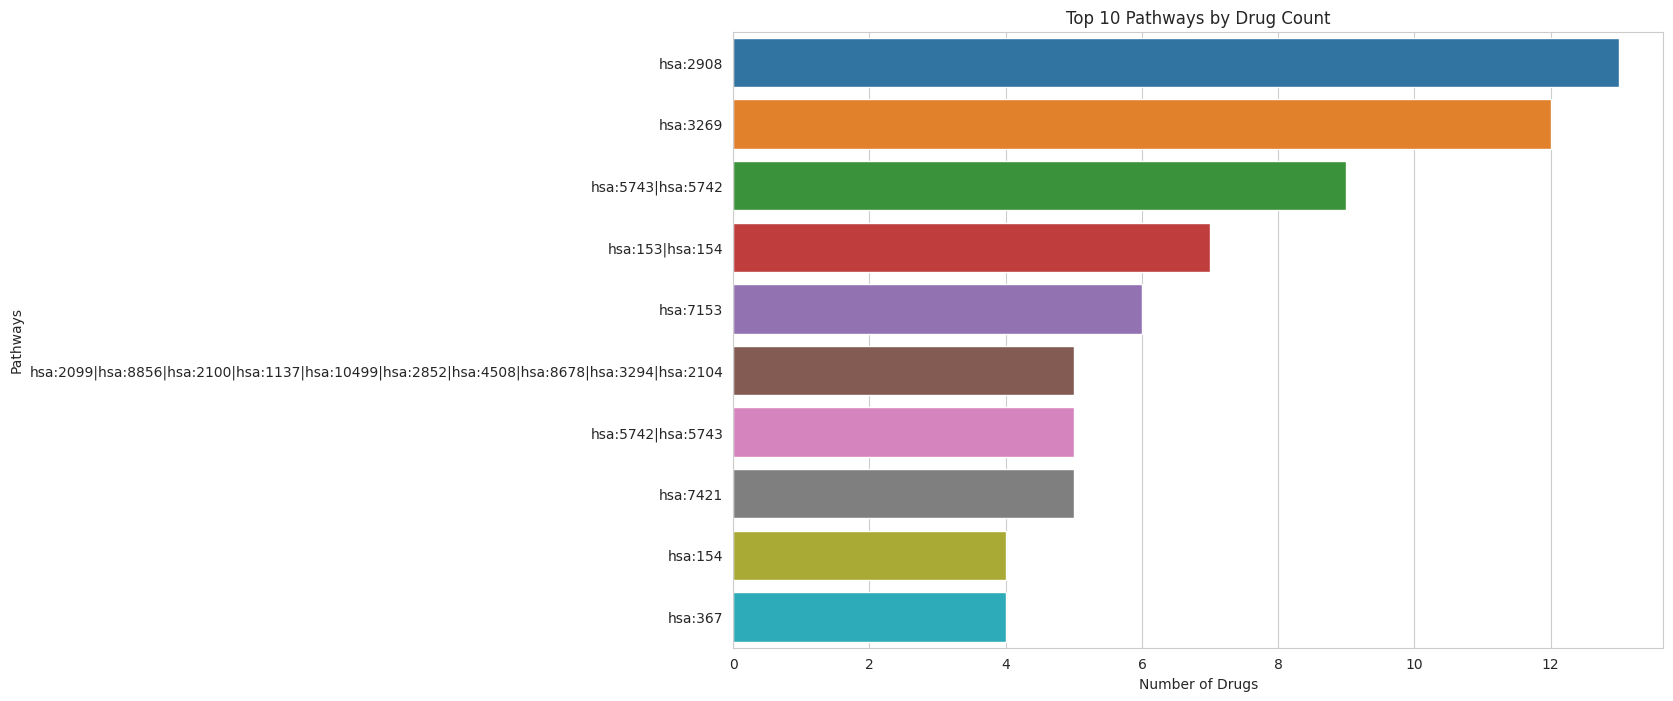

Unique SMILES strings count: 555


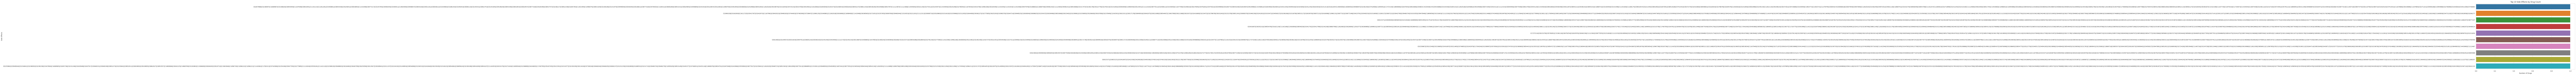

In [10]:
# Pathway Analysis: Identifying the most common pathways
pathway_counts = df_drug['pathway'].value_counts().head(10)

# Chemical Structure (SMILES) Analysis: Count of unique SMILES strings
unique_smiles_count = df_drug['smile'].nunique()

# Side Effects Analysis: Identifying common side effects
side_effects_counts = df_drug['side'].value_counts().head(10)

# Plotting the most common pathways
plt.figure(figsize=(12, 8))
sns.barplot(x=pathway_counts.values, y=pathway_counts.index)
plt.title('Top 10 Pathways by Drug Count')
plt.xlabel('Number of Drugs')
plt.ylabel('Pathways')
plt.show()

print('Unique SMILES strings count:', unique_smiles_count)

# Plotting the most common side effects
plt.figure(figsize=(12, 8))
sns.barplot(x=side_effects_counts.values, y=side_effects_counts.index)
plt.title('Top 10 Side Effects by Drug Count')
plt.xlabel('Number of Drugs')
plt.ylabel('Side Effects')
plt.show()

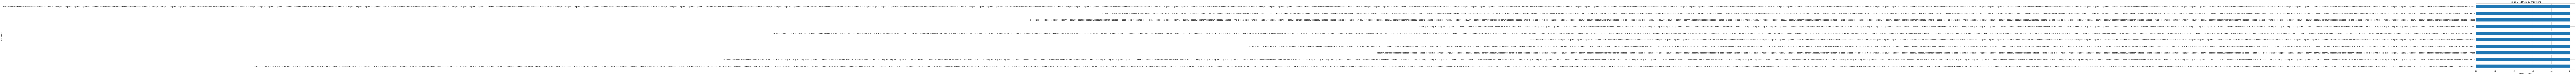

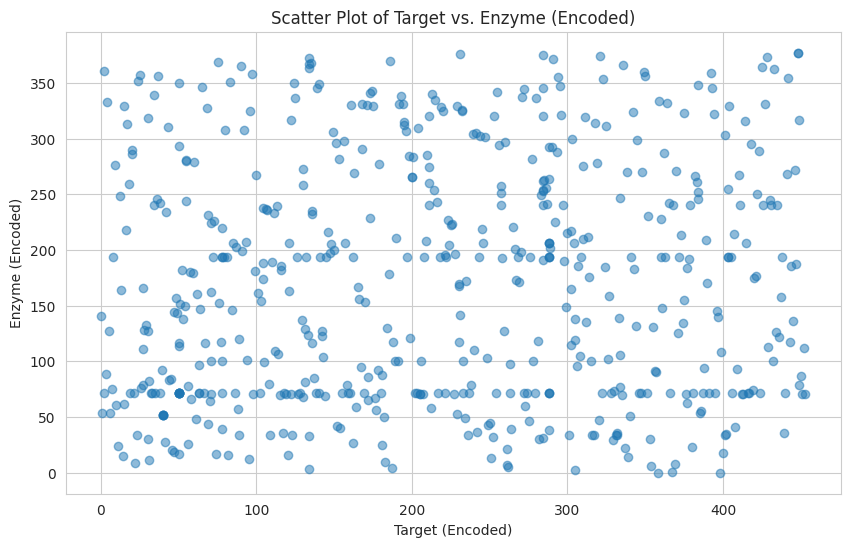

In [21]:
# Attempting to resolve the plotting issue and continue with EDA

# Re-plotting the most common side effects with a simpler approach to avoid rendering issues
plt.figure(figsize=(12, 8))
side_effects_counts.plot(kind='barh')
plt.title('Top 10 Side Effects by Drug Count')
plt.xlabel('Number of Drugs')
plt.ylabel('Side Effects')
plt.show()

# Scatter plot for Target vs. Enzyme (Encoded as numbers for visualization)
df_encoded = df_drug.copy()
df_encoded['target_encoded'] = df_encoded['target'].astype('category').cat.codes
df_encoded['enzyme_encoded'] = df_encoded['enzyme'].astype('category').cat.codes

plt.figure(figsize=(10, 6))
plt.scatter(df_encoded['target_encoded'], df_encoded['enzyme_encoded'], alpha=0.5)
plt.title('Scatter Plot of Target vs. Enzyme (Encoded)')
plt.xlabel('Target (Encoded)')
plt.ylabel('Enzyme (Encoded)')
plt.show()

### Approach 1.

In [23]:
df_drug = pd.read_pickle('/kaggle/input/dpsp-interaction/df.pkl')
conn = sqlite3.connect("/kaggle/input/dpsp-interaction/event.db")
extraction = pd.read_sql('select * from extraction;', conn)
extraction.drop(columns=['index'], inplace = True)
df_drug.drop(columns=['id', 'index'], inplace = True)

def feature_extractor(df, f_list):
    for feature in f_list:
        unique = set('|'.join(df[feature].values.tolist()).split('|'))

        for side in unique:
            df[side] = 0

        for index, row in df.iterrows():
            for side in row[feature].split('|'):
                df.at[index, side] = 1
    df.drop(columns=f_list, inplace=True)

feature_extractor(df_drug, ['target', 'enzyme', 'smile', 'pathway', 'side'])

extraction['side'] = extraction['mechanism'] + extraction['action']
extraction.drop(columns=['mechanism', 'action'], inplace=True)

le = preprocessing.LabelEncoder()
extraction['side'] = le.fit_transform(extraction['side'])

In [24]:
extraction

,drugA,drugB,side
0,Abemaciclib,Amiodarone,4
1,Abemaciclib,Apalutamide,14
2,Abemaciclib,Aprepitant,15
3,Abemaciclib,Atomoxetine,0
4,Abemaciclib,Bortezomib,0
...,...,...,...
37259,Nefazodone,Netupitant,15
37260,Nefazodone,Nicardipine,0
37261,Neratinib,Netupitant,15
37262,Netupitant,Nicardipine,15


In [25]:
df_drug

,name,P48448,Q96NX5,O14920,P78559,P42766,Q9Y5K3,Q9NPH2,Q14289,P29474,...,C0852970,C0679136,C1142366,C0155761,C0013504,C0152101,C0860155,C0920058,C0494164,C0271583
0,Glucosamine,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Azelnidipine,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Abiraterone,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Flecainide,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Caffeine,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Ketazolam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
568,Lansoprazole,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
569,Bosentan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
570,Ezogabine,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
class DDIDataset(Dataset):
    def __init__(self, df, extraction):
        self.df = df
        self.extraction = extraction.copy()
        self.extraction.rename(columns={'drugA':'drugB', 'drugB':'drugA'}, inplace=True)
        self.extraction = pd.concat([self.extraction, extraction], axis=0, ignore_index=True)

    def __len__(self):
        return len(self.extraction)

    def __getitem__(self, idx):
        drugA = torch.tensor(self.df[self.df['name'] == self.extraction.loc[idx]['drugA']].drop(columns=['name']).values.astype('float32'))
        drugB = torch.tensor(self.df[self.df['name'] == self.extraction.loc[idx]['drugB']].drop(columns=['name']).values.astype('float32'))
        return torch.cat([(drugA), (drugB)]).flatten(), self.extraction.loc[idx]['side']

In [27]:
d = DDIDataset(df_drug, extraction)

In [28]:
d = DDIDataset(df_drug, extraction)

sample_data, sample_label = d[0]  

print("Sample data shape:", sample_data.shape)
print("Sample label shape:", sample_label)

Input_size = sample_data.shape[0]
label_size = len(extraction['side'].unique())

Sample data shape: torch.Size([25658])
Sample label shape: 4


In [22]:
class AdversarialAutoencoder(nn.Module):
    def __init__(self, Input_size, label_size):
        super(AdversarialAutoencoder, self).__init__()
        self.input_size = Input_size
        self.label_size = label_size
        self.encoder = nn.Sequential(
            nn.Linear(self.input_size, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(4096, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(2048, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(4096, self.input_size),
            nn.Sigmoid()
        )
        

        self.classifier = nn.Sequential(
            nn.Linear(2048, 512 + 256),
            nn.BatchNorm1d(512 + 256),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(512 + 256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, self.label_size),
            nn.LogSoftmax()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        classification = self.classifier(encoded)

        return decoded, classification

In [30]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [31]:
def extract_pair_latent_representation(model, drug_pair):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    pair1 = drug_pair[0]
    pair2 = drug_pair[1]
    
    drugA = torch.tensor(df_drug[df_drug['name'] == pair1['drugA']].drop(columns=['name']).values.astype('float32'))
    drugB = torch.tensor(df_drug[df_drug['name'] == pair1['drugB']].drop(columns=['name']).values.astype('float32'))
    pairA = torch.cat([(drugA), (drugB)]).flatten()
    
    drugC = torch.tensor(df_drug[df_drug['name'] == pair2['drugA']].drop(columns=['name']).values.astype('float32'))
    drugD = torch.tensor(df_drug[df_drug['name'] == pair2['drugB']].drop(columns=['name']).values.astype('float32'))
    pairB = torch.cat([(drugC), (drugD)]).flatten()  
    
    pairA = pairA.to(device)
    pairB = pairB.to(device)
    
    with torch.no_grad():
        latentA = model.encoder(pairA.view(1, -1))
        latentB = model.encoder(pairB.view(1, -1))

    return latentA, latentB

In [155]:
from sklearn.metrics.pairwise import cosine_similarity
def create_similarity_matrix(model, drug_pairs):
    print('in csm ...')
    num_rows = int(len(drug_pairs) * 0.0001)
    
    
    
    # Select the first 10% of rows
    drug_pairs = drug_pairs.head(num_rows)
    num_pairs = len(drug_pairs)
    similarity_matrix = np.zeros((num_pairs, num_pairs))
    d = num_pairs*[0]
    s = []
    for i in range(num_pairs):
        s.append(d)
    similarity_sides = s
    for i, rowa in drug_pairs.iterrows():
        for j, rowb in drug_pairs.iterrows():
            latentA, latentB = extract_pair_latent_representation(model, [rowa, rowb])
            similarity_matrix[i, j] = cosine_similarity(latentA.to('cpu'), latentB.to('cpu'))
            similarity_sides[i][j] = [rowa['side'], rowb['side'], latentA.to('cpu'), latentB.to('cpu')]
    print(similarity_matrix.shape)
    print(similarity_sides)
    return similarity_matrix, np.array(similarity_sides)

In [156]:
def extract_similar_pairs(similarity_matrix, similarity_sides, threshold):
    print('in esp ...')
    similar_pairs_laten = []
    sides_compare = []
    compare_results = []
    for i in range(len(similarity_matrix)):
        for j in range(i + 1, len(similarity_matrix)):
            if similarity_matrix[i, j] >= threshold:
                sidea, sideb, latenta, latentb = similarity_sides[i][j]
                if latenta.tolist() not in similar_pairs_laten:
                    similar_pairs_laten.append(latenta.tolist())
                if latentb.tolist() not in similar_pairs_laten:
                    similar_pairs_laten.append(latentb.tolist())
                compare_results.append(f'pair{i} and pair{j} with similarity {similarity_matrix[i, j]} have sides in this order {sidea} , {sideb}')
    return np.array(similar_pairs_laten), compare_results

In [157]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_latent(latent_representations, method='pca'):
    print('in vl ...')
    if method == 'pca':
        reducer = PCA(n_components=3)
    elif method == 'tsne':
        reducer = TSNE(n_components=3, perplexity=2)
    
    latent_representations = latent_representations.reshape(latent_representations.shape[0], -1)
#     latent_representations.shape
    reduced_latent = reducer.fit_transform(latent_representations)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')  # Creating a 3D subplot

    # Use the first three components for the 3D scatter plot
    ax.scatter(reduced_latent[:, 0], reduced_latent[:, 1], reduced_latent[:, 2])
    ax.set_title(f'Latent Representations Visualization ({method.capitalize()})')

    plt.show()

In [29]:
def train_adversarial_autoencoder(model, train_loader, test_loader, decoder_criterion, classifier_criterion, adversarial_criterion, optimizer, scheduler, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    model = model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (training)", leave=False)
        running_loss = 0.0
        running_decoder_loss = 0.0
        running_classifier_loss = 0.0
        running_correct = 0
        running_total = 0
        
        test_metrica = Metrica(num_classes=65)
        for i, (inputs, labels) in enumerate(train_pbar):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            reconstructed_inputs, predicted_labels = model(inputs)
            decoder_loss = decoder_criterion(reconstructed_inputs, inputs)
            classifier_loss = classifier_criterion(predicted_labels, labels.long())
            
            loss = 0.5 * decoder_loss +  classifier_loss 

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_decoder_loss += decoder_loss.item()
            running_classifier_loss += classifier_loss.item()
            _, predicted = torch.max(predicted_labels.data, 1)
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()
            train_pbar.set_postfix({"loss": running_loss / (i+1),
                                    "decoder_loss": running_decoder_loss / (i+1),
                                    "classifier_loss": running_classifier_loss / (i+1),
                                    "accuracy": 100 * running_correct / running_total})


        epoch_loss = running_loss / len(train_loader)
        epoch_decoder_loss = running_decoder_loss / len(train_loader)
        epoch_classifier_loss = running_classifier_loss / len(train_loader)
        epoch_train_accuracy = 100 * running_correct / running_total
        train_pbar.set_postfix({"loss": epoch_loss,
                                "decoder_loss": epoch_decoder_loss,
                                "classifier_loss": epoch_classifier_loss,
                                "accuracy": epoch_train_accuracy})
        
        model.eval() 
        test_running_loss = 0.0
        test_running_correct = 0
        test_running_total = 0
        test_pbar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} (testing)", leave=False)
        with torch.no_grad():
            for inputs, labels in test_pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                reconstructed_inputs, predicted_labels = model(inputs)
                
                test_metrica.upgrade(predicted_labels, labels.long())
                
                decoder_loss = decoder_criterion(reconstructed_inputs, inputs)
                classifier_loss = classifier_criterion(predicted_labels, labels.long())
                loss = decoder_loss + classifier_loss
                # loss = classifier_loss
                test_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(predicted_labels.data, 1)
                test_running_total += labels.size(0)
                test_running_correct += (predicted == labels).sum().item()
            test_accuracy = 100 * test_running_correct / test_running_total
            test_loss = test_running_loss / len(test_loader.dataset)
        test_pbar.set_postfix({"loss": test_loss,
                               "accuracy": test_accuracy})
        scheduler.step(test_accuracy)
        print('Epoch [{}/{}], Train Loss: {:.4f}, Train Autoencoder Loss: {:.4f}, Train Classification Loss: {:.4f}, Train Accuracy: {:.2f}%, Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(epoch+1, num_epochs, epoch_loss, epoch_decoder_loss, epoch_classifier_loss, epoch_train_accuracy, test_loss, test_accuracy))
        
        test_metrica.print_metrics()
#         if test_accuracy > best_accuracy:
#             best_accuracy = test_accuracy
#             model_scripted = torch.jit.script(model) 
#             model_scripted.save("best_model_AAE_DDI1_fold1.pt")
        
    return test_metrica

In [159]:
# class_counts_dict

In [160]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Calculate class weights as the inverse of class frequencies
# total_samples = sum(class_counts_dict.values())-
# class_weights = {cls: total_samples / count for cls, count in class_counts_dict.items()}
# max_weight = max(class_weights.values())

# # Normalize class weights to be between 0 and 1
# class_weights = {cls: weight / max_weight for cls, weight in class_weights.items()}

# # Convert class weights to a tensor
# class_weights_tensor = torch.tensor([class_weights[cls] for cls in range(100)], dtype=torch.float).to(device)

In [161]:
# class_weights_tensor

In [164]:
class AdversarialAutoencoderTrainer:
    def __init__(self, df_drug, extraction, num_folds=5, batch_size=64, lr=3e-4, num_epochs=30, index=1):
        self.df_drug = df_drug
        self.extraction = extraction
        self.num_folds = num_folds
        self.batch_size = batch_size
        self.lr = lr
        self.num_epochs = num_epochs
        self.best_acc = 0
        self.index = index
        self.metrica = 0
        self.testloader = 0
        
    def train(self):
        kf = KFold(n_splits=self.num_folds, shuffle=True, random_state=42)
        fold = 1
        for train_index, test_index in kf.split(self.extraction):
            if fold == self.index:
                train_extraction = self.extraction.iloc[train_index]
                test_extraction = self.extraction.iloc[test_index]
            
                train_dataset = DDIDataset(self.df_drug, train_extraction)
                test_dataset = DDIDataset(self.df_drug, test_extraction)
                train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
                test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)
                model = AdversarialAutoencoder(Input_size, label_size)
                decoder_criterion = nn.L1Loss()
                adversarial_criterion = nn.BCELoss()
                classifier_criterion = nn.CrossEntropyLoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=self.lr)
                scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold=0.01, cooldown=2)
                self.test_loader = test_loader
                print("Training fold {}...".format(fold))
                self.best_acc, self.metrica = train_adversarial_autoencoder(model, train_loader, test_loader, decoder_criterion, classifier_criterion, adversarial_criterion, optimizer, scheduler, self.num_epochs, self.best_acc, 0.5, 1, 1)
#                 similarity_matrix, similarity_sides = create_similarity_matrix(model, self.extraction)
#                 similar_pairs_laten, compare_results = extract_similar_pairs(similarity_matrix, similarity_sides, 0.5)
#                 visualize_latent(similar_pairs_laten)
            fold += 1

In [165]:
trainer = AdversarialAutoencoderTrainer(df_drug, extraction, num_epochs=0, index=1)
trainer.train()

Training fold 1...
cuda


In [166]:
trainer.test_loader

In [167]:
class ClassificationMetrics:
    def __init__(self, TP, TN, FP, FN):
        self.TP = TP
        self.TN = TN
        self.FP = FP
        self.FN = FN

    def precision(self):
        return self.TP / (self.TP + self.FP) if (self.TP + self.FP) > 0 else 0

    def recall(self):
        return self.TP / (self.TP + self.FN) if (self.TP + self.FN) > 0 else 0

    def f1_score(self):
        p = self.precision()
        r = self.recall()
        return (2 * p * r) / (p + r) if (p + r) > 0 else 0

In [168]:
def perf_measure(y_org, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    lst_fp_equal=[]
    lst_tp_equal=[]
    for i in range(y_hat.shape[0]):
        for j in range(y_hat.shape[1]):
            if y_org[i,j]==y_hat[i,j]==1:
                TP += 1
                lst_tp_equal.append('item'+str(i)+','+str(j))
            if y_hat[i,j]==1 and y_org[i,j]!=y_hat[i,j]:
                FP += 1
                lst_fp_equal.append('item'+str(i)+','+ str(j))
            if y_org[i,j]==y_hat[i,j]==0:
                TN += 1
                #lst_tn_equal.append('item'+str(i)+','+str(j))
            if y_hat[i,j]==0 and y_org[i,j]!=y_hat[i,j]:
                FN += 1
                #lst_fn_equal.append('item'+str(i)+','+ str(j))

    return(TP, FP, TN, FN, lst_tp_equal,lst_fp_equal)

In [170]:
import csv
import os

def save_tocsv(metricas, metrics, file_path):
    my_list = [
    ['metricas_auprc_macro', 'metricas_auprc_weighted', 'metricas_auroc_macro', 'metricas_auroc_weighted', 
    'metricas_f1_macro', 'metricas_f1_weighted', 'metricas_f1_micro', 'metricas_recall_macro', 
     'metricas_recall_weighted', 'metricas_recall_micro', 'metricas_precision_macro', 'metricas_precision_weighted',
     'metricas_precision_micro', 'metrics_f1', 'metrics_recall', 'metrics_precision'],
    [metricas.AUPRC(average="macro"), metricas.AUPRC(average="weighted"), metricas.AUROC(average="macro"), 
    metricas.AUROC(average="weighted"), metricas.f1_score(average="macro"), metricas.f1_score(average="weighted"), 
    metricas.f1_score(average="micro"), metricas.recall_score(average="macro"), metricas.recall_score(average="weighted"), 
     metricas.recall_score(average="micro"), metricas.precision_score(average="macro"), metricas.precision_score(average="weighted"), 
     metricas.precision_score(average="micro"), metrics.f1_score(), metrics.recall(), metrics.precision()]
    ]
    
    # Check if the file already exists
    file_exists = os.path.isfile(file_path)
    # Writing to CSV file
    with open(file_path, 'a', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)

        # Writing each row in the list to the CSV file
        for row in my_list:
            csv_writer.writerow(row)

    print(f'The list has been saved to {file_path}')

In [169]:
def disply_scores(model_path, test_loader, num_classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AdversarialAutoencoder(Input_size , label_size)
    model = torch.jit.load(model_path)
    model.eval()
    model = model.to(device)
    metricas = Metrica(num_classes=num_classes, task="multiclass")
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for (inputs, labels) in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            reconstructed_inputs, predicted_labels, real_output, fake_output = model(inputs)
            _, predicted = torch.max(predicted_labels.data, 1)
            all_predictions.append(predicted.tolist())
            all_labels.append(labels.tolist())
            metricas.upgrade(predicted_labels, labels)
            
    flat_list_labels = list(itertools.chain.from_iterable(all_labels))
    flat_list_predictions = list(itertools.chain.from_iterable(all_predictions))
    
    class_id = []
    for i in range(num_classes):
        class_id.append(i)
    
    real_zero = label_binarize(flat_list_labels, classes= class_id)
    pred_zero = label_binarize(flat_list_predictions, classes= class_id)
    
    TP, FP, TN, FN, lst_tp_equal,lst_fp_equal = perf_measure(real_zero,pred_zero)
    print(TP, FP, TN, FN)
    metrics = ClassificationMetrics(TP, TN, FP, FN)
    # Specify the file name
    file_path = 'ACAE_DDI1_fold1.csv'
    save_tocsv(metricas, metrics, file_path)
    print(f'Model f1_score is :{metrics.f1_score()}')
    print(f'Model precision is :{metrics.precision()}')
    print(f'Model recall is :{metrics.recall()}')
    print(f'Model AUPRC is :{metricas.AUPRC(average="weighted")}')
    print(f'Model AUROC is :{metricas.AUROC(average="weighted")}')

In [172]:
# model_path = '/kaggle/working/best_model_AAE_DDI1_fold1.pt'
# disply_scores(model_path, trainer.test_loader, label_size)

In [173]:
results = pd.read_csv('/kaggle/input/results-for-approach1/predictions (9).csv')

In [177]:
results

,AccuracyFP,FN,metricas_auprc_macro,metricas_auprc_weighted,metricas_auroc_macro,metricas_auroc_weighted,metricas_f1_macro,metricas_f1_weighted,metricas_f1_micro,metricas_recall_macro,metricas_recall_weighted,metricas_recall_micro,metricas_precision_macro,metricas_precision_weighted,metricas_precision_micro,metrics_f1,metrics_recall,metrics_precision
0,93.361098,1098,0.871626,0.964615,0.932302,0.993509,0.830795,0.923168,0.923830,0.818746,0.923830,0.923830,0.859587,0.922903,0.923830,0.923858,0.923858,0.923858
1,93.761052,1052,0.880462,0.967150,0.933213,0.993965,0.836190,0.926653,0.927305,0.824976,0.927305,0.927305,0.863875,0.926501,0.927305,0.927331,0.927331,0.927331
2,93.561075,1075,0.876044,0.965883,0.932758,0.993737,0.833493,0.924911,0.925567,0.821861,0.925567,0.925567,0.861731,0.924702,0.925567,0.925594,0.925594,0.925594


### Approach 2.

In [2]:
from numpy.random import seed
seed(1)
import csv
import sqlite3
import time
import numpy as np
import pandas as pd
import pickle
from pandas import DataFrame
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
from keras.models import Model
from keras.layers import Dense, Dropout, Input, Activation, BatchNormalization
from keras.callbacks import EarlyStopping

2024-02-01 12:57:39.115511: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 12:57:39.115632: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 12:57:39.247896: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def DNN():
    train_input = Input(shape=(new_feature.shape[1],), name='Inputlayer')
    train_in = Dense(512, activation='relu')(train_input)
    train_in = BatchNormalization()(train_in)
    train_in = Dropout(droprate)(train_in)
    train_in = Dense(256, activation='sigmoid')(train_in)
    train_in = BatchNormalization()(train_in)
    train_in = Dropout(droprate)(train_in)
    train_in = Dense(128, activation='sigmoid')(train_in)
    train_in = BatchNormalization()(train_in)
    train_in = Dropout(droprate)(train_in)
    train_in = Dense(event_num)(train_in)
    out = Activation('softmax')(train_in)
    model = Model(train_input, out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [3]:
def prepare(df_drug, feature_list, vector_size,mechanism,action,drugA,drugB):
    d_label = {}
    d_feature = {}
    # Transfrom the interaction event to number
    # Splice the features
    d_event=[]
    for i in range(len(mechanism)):
        d_event.append(mechanism[i]+" "+action[i])
    label_value = 0
    count={}
    for i in d_event:
        if i in count:
            count[i]+=1
        else:
            count[i]=1
    list1 = sorted(count.items(), key=lambda x: x[1],reverse=True)
    for i in range(len(list1)):
        d_label[list1[i][0]]=i
    vector = np.zeros((len(np.array(df_drug['name']).tolist()), 0), dtype=float)
    for i in feature_list:
        vector = np.hstack((vector, feature_vector(i, df_drug, vector_size)))
    # Transfrom the drug ID to feature vector
    for i in range(len(np.array(df_drug['name']).tolist())):
        d_feature[np.array(df_drug['name']).tolist()[i]] = vector[i]
    # Use the dictionary to obtain feature vector and label
    new_feature = []
    new_label = []
    name_to_id = {}
    for i in range(len(d_event)):
        new_feature.append(d_feature[drugA[i]]+ d_feature[drugB[i]])
        new_label.append(d_label[d_event[i]])
    new_feature = np.array(new_feature)
    new_label = np.array(new_label)
    return (new_feature, new_label, event_num)

In [4]:
def feature_vector(feature_name, df, vector_size):
    # df are the 572 kinds of drugs
    # Jaccard Similarity
    def Jaccard(matrix):
        matrix = np.asarray(matrix)  # Convert np.matrix to np.array
        numerator = matrix @ matrix.T  # Use matrix multiplication (@) instead of element-wise multiplication (*)
        denominator = np.ones(np.shape(matrix)) @ matrix.T + matrix @ np.ones(np.shape(matrix.T)) - matrix @ matrix.T
        return numerator / denominator


    all_feature = []
    drug_list = np.array(df[feature_name]).tolist()
    # Features for each drug, for example, when feature_name is target, drug_list=["P30556|P05412","P28223|P46098|……"]
    for i in drug_list:
        for each_feature in i.split('|'):
            if each_feature not in all_feature:
                all_feature.append(each_feature)  # obtain all the features
    feature_matrix = np.zeros((len(drug_list), len(all_feature)), dtype=float)
    df_feature = DataFrame(feature_matrix, columns=all_feature)  # Consrtuct feature matrices
    for i in range(len(drug_list)):
        for each_feature in df[feature_name].iloc[i].split('|'):
            df_feature[each_feature].iloc[i] = 1
    sim_matrix = Jaccard(np.array(df_feature))

    sim_matrix1 = np.array(sim_matrix)
    count = 0
    pca = PCA(n_components=vector_size)  # PCA dimension
    pca.fit(sim_matrix)
    sim_matrix = pca.transform(sim_matrix)
    return sim_matrix

In [5]:
def get_index(label_matrix, event_num, seed, CV):
    index_all_class = np.zeros(len(label_matrix))
    for j in range(event_num):
        index = np.where(label_matrix == j)
        kf = KFold(n_splits=CV, shuffle=True, random_state=seed)
        k_num = 0
        for train_index, test_index in kf.split(range(len(index[0]))):
            index_all_class[index[0][test_index]] = k_num
            k_num += 1

    return index_all_class

In [6]:
def cross_validation(feature_matrix, label_matrix, event_num, seed, CV):
    all_eval_type = 11
    result_all = np.zeros((all_eval_type, 1), dtype=float)
    each_eval_type = 6
    result_eve = np.zeros((event_num, each_eval_type), dtype=float)
    y_true = np.array([])
    y_pred = np.array([])
    y_score = np.zeros((0, event_num), dtype=float)
    index_all_class = get_index(label_matrix, event_num, seed, CV)
    matrix = []
    if type(feature_matrix) != list:
        matrix.append(feature_matrix)
        feature_matrix = matrix
    for k in range(CV):
        train_index = np.where(index_all_class != k)
        test_index = np.where(index_all_class == k)
        pred = np.zeros((len(test_index[0]), event_num), dtype=float)
        # dnn=DNN()
        for i in range(len(feature_matrix)):
            x_train = feature_matrix[i][train_index]
            x_test = feature_matrix[i][test_index]
            y_train = label_matrix[train_index]
            # one-hot encoding
            y_train_one_hot = np.array(y_train)
            y_train_one_hot = (np.arange(y_train_one_hot.max() + 1) == y_train[:, None]).astype(dtype='float32')
            y_test = label_matrix[test_index]
            # one-hot encoding
            y_test_one_hot = np.array(y_test)
            y_test_one_hot = (np.arange(y_test_one_hot.max() + 1) == y_test[:, None]).astype(dtype='float32')
            
            dnn = DNN()
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
            dnn.fit(x_train, y_train_one_hot, batch_size=128, epochs=100, validation_data=(x_test, y_test_one_hot),
                    callbacks=[early_stopping])
            pred += dnn.predict(x_test)
                
        pred_score = pred / len(feature_matrix)
        pred_type = np.argmax(pred_score, axis=1)
        y_true = np.hstack((y_true, y_test))
        y_pred = np.hstack((y_pred, pred_type))
        y_score = np.row_stack((y_score, pred_score))
    result_all, positive_negative, result_eve = evaluate(y_pred, y_score, y_true, event_num)
    return result_all, positive_negative, result_eve

In [7]:
def evaluate(pred_type, pred_score, y_test, event_num):
    all_eval_type = 11
    result_all = np.zeros((all_eval_type, 1), dtype=float)
    each_eval_type = 6
    result_eve = np.zeros((event_num, each_eval_type), dtype=float)
    y_one_hot = label_binarize(y_test, classes=np.arange(event_num))
    pred_one_hot = label_binarize(pred_type, classes=np.arange(event_num))

    precision, recall, th = multiclass_precision_recall_curve(y_one_hot, pred_score)

    result_all[0] = accuracy_score(y_test, pred_type)
    result_all[1] = roc_aupr_score(y_one_hot, pred_score, average='micro')
    result_all[2] = roc_aupr_score(y_one_hot, pred_score, average='macro')
    result_all[3] = roc_auc_score(y_one_hot, pred_score, average='micro')
    result_all[4] = roc_auc_score(y_one_hot, pred_score, average='macro')
    result_all[5] = f1_score(y_test, pred_type, average='micro')
    result_all[6] = f1_score(y_test, pred_type, average='macro')
    result_all[7] = precision_score(y_test, pred_type, average='micro')
    result_all[8] = precision_score(y_test, pred_type, average='macro')
    result_all[9] = recall_score(y_test, pred_type, average='micro')
    result_all[10] = recall_score(y_test, pred_type, average='macro')
    positive_negative= np.hstack(self_metric_calculate(y_test, pred_type))
    for i in range(event_num):
        result_eve[i, 0] = accuracy_score(y_one_hot.take([i], axis=1).ravel(), pred_one_hot.take([i], axis=1).ravel())
        result_eve[i, 1] = roc_aupr_score(y_one_hot.take([i], axis=1).ravel(), pred_one_hot.take([i], axis=1).ravel(),
                                          average=None)
        result_eve[i, 2] = roc_auc_score(y_one_hot.take([i], axis=1).ravel(), pred_one_hot.take([i], axis=1).ravel(),
                                         average=None)
        result_eve[i, 3] = f1_score(y_one_hot.take([i], axis=1).ravel(), pred_one_hot.take([i], axis=1).ravel(),
                                    average='binary')
        result_eve[i, 4] = precision_score(y_one_hot.take([i], axis=1).ravel(), pred_one_hot.take([i], axis=1).ravel(),
                                           average='binary')
        result_eve[i, 5] = recall_score(y_one_hot.take([i], axis=1).ravel(), pred_one_hot.take([i], axis=1).ravel(),
                                        average='binary')
    return [result_all, positive_negative, result_eve]

In [8]:
def self_metric_calculate(y_true, pred_type):
    y_true = y_true.ravel()
    y_pred = pred_type.ravel()
    if y_true.ndim == 1:
        y_true = y_true.reshape((-1, 1))
    if y_pred.ndim == 1:
        y_pred = y_pred.reshape((-1, 1))
    y_true_c = y_true.take([0], axis=1).ravel()
    y_pred_c = y_pred.take([0], axis=1).ravel()
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    for i in range(len(y_true_c)):
        if (y_true_c[i] == 1) and (y_pred_c[i] == 1):
            TP += 1
        if (y_true_c[i] == 1) and (y_pred_c[i] == 0):
            FN += 1
        if (y_true_c[i] == 0) and (y_pred_c[i] == 1):
            FP += 1
        if (y_true_c[i] == 0) and (y_pred_c[i] == 0):
            TN += 1
    print("TP=", TP, "FN=", FN, "FP=", FP, "TN=", TN)
    #return (TP / (TP + FP), TP / (TP + FN))
    return(TP, TN, FP, FN)

In [9]:
def multiclass_precision_recall_curve(y_true, y_score):
    y_true = y_true.ravel()
    y_score = y_score.ravel()
    if y_true.ndim == 1:
        y_true = y_true.reshape((-1, 1))
    if y_score.ndim == 1:
        y_score = y_score.reshape((-1, 1))
    y_true_c = y_true.take([0], axis=1).ravel()
    y_score_c = y_score.take([0], axis=1).ravel()
    precision, recall, pr_thresholds = precision_recall_curve(y_true_c, y_score_c)
    return (precision, recall, pr_thresholds)

In [10]:
def roc_aupr_score(y_true, y_score, average="macro"):
    def _binary_roc_aupr_score(y_true, y_score):
        precision, recall, pr_thresholds = precision_recall_curve(y_true, y_score)
        return auc(recall, precision)

    def _average_binary_score(binary_metric, y_true, y_score, average):  # y_true= y_one_hot
        if average == "binary":
            return binary_metric(y_true, y_score)
        if average == "micro":
            y_true = y_true.ravel()
            y_score = y_score.ravel()
        if y_true.ndim == 1:
            y_true = y_true.reshape((-1, 1))
        if y_score.ndim == 1:
            y_score = y_score.reshape((-1, 1))
        n_classes = y_score.shape[1]
        score = np.zeros((n_classes,))
        for c in range(n_classes):
            y_true_c = y_true.take([c], axis=1).ravel()
            y_score_c = y_score.take([c], axis=1).ravel()
            score[c] = binary_metric(y_true_c, y_score_c)
        return np.average(score)

    return _average_binary_score(_binary_roc_aupr_score, y_true, y_score, average)

In [11]:
event_num = 65                                                                
droprate = 0.3                                                                
vector_size = 572                                                             
df_drug = pd.read_pickle('/kaggle/input/dpsp-interaction/df.pkl')                                            
conn = sqlite3.connect("/kaggle/input/dpsp-interaction/event.db")                                                             
feature_list=df_drug[["side", "target", "enzyme","pathway","smile"]]          
extraction = pd.read_sql('select * from extraction;', conn)
mechanism = extraction['mechanism']
action = extraction['action']
drugA = extraction['drugA']
drugB = extraction['drugB']

In [12]:
new_feature, new_label, event_num = prepare(df_drug, feature_list, vector_size, mechanism,action,drugA,drugB)

In [21]:
seed = 0
CV = 5
new_feature, new_label, event_num = prepare(df_drug, feature_list, vector_size, mechanism,action,drugA,drugB)
all_result, positive_negative, each_result = cross_validation(new_feature, new_label, event_num, seed, CV)

/tmp/ipykernel_34/541527005.py:22: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_feature[each_feature].iloc[i] = 1
/tmp/ipykernel_34/541527005.py:22: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are sett

Epoch 1/100
233/233 [==============================] - 4s 8ms/step - loss: 1.4817 - accuracy: 0.6648 - val_loss: 1.4365 - val_accuracy: 0.7510
Epoch 2/100
233/233 [==============================] - 1s 6ms/step - loss: 0.7622 - accuracy: 0.7937 - val_loss: 0.5499 - val_accuracy: 0.8423
Epoch 3/100
233/233 [==============================] - 1s 6ms/step - loss: 0.5740 - accuracy: 0.8312 - val_loss: 0.4554 - val_accuracy: 0.8575
Epoch 4/100
233/233 [==============================] - 1s 6ms/step - loss: 0.4751 - accuracy: 0.8556 - val_loss: 0.4009 - val_accuracy: 0.8758
Epoch 5/100
233/233 [==============================] - 1s 6ms/step - loss: 0.4004 - accuracy: 0.8759 - val_loss: 0.3529 - val_accuracy: 0.8944
Epoch 6/100
233/233 [==============================] - 1s 6ms/step - loss: 0.3478 - accuracy: 0.8897 - val_loss: 0.3339 - val_accuracy: 0.8950
Epoch 7/100
233/233 [==============================] - 1s 6ms/step - loss: 0.3012 - accuracy: 0.9058 - val_loss: 0.3224 - val_accuracy: 0.9010

In [22]:
all_result

array([[0.93285745],
       [0.97673638],
       [0.89226557],
       [0.99902387],
       [0.9941717 ],
       [0.93285745],
       [0.86206347],
       [0.93285745],
       [0.9111941 ],
       [0.93285745],
       [0.84043254]])

In [23]:
each_result

array([[0.96787784, 0.94619454, 0.96313208, 0.93984018, 0.92693566,
        0.95310907],
       [0.97898776, 0.96428251, 0.97138377, 0.95865237, 0.96144476,
        0.95587616],
       [0.97262774, 0.91645517, 0.9442242 , 0.90910711, 0.91481349,
        0.90347148],
       [0.9895073 , 0.92030618, 0.95203199, 0.91731867, 0.92573624,
        0.90905281],
       [0.9960015 , 0.94384209, 0.95753688, 0.94163729, 0.96857373,
        0.91615854],
       [0.99785316, 0.9655889 , 0.98776864, 0.96509599, 0.95344828,
        0.9770318 ],
       [0.99492808, 0.91529782, 0.95427716, 0.9139736 , 0.91689498,
        0.91107078],
       [0.99651138, 0.94086474, 0.96738899, 0.93992606, 0.94341373,
        0.93646409],
       [0.9935863 , 0.83499664, 0.92686279, 0.83298393, 0.80978261,
        0.85755396],
       [0.99922177, 0.97389672, 0.98709154, 0.97370807, 0.97282609,
        0.97459165],
       [0.99951696, 0.97515946, 0.98334412, 0.97493036, 0.98314607,
        0.96685083],
       [0.99838987, 0

In [24]:
# Assuming 'result_all' is your array of scores
result_all = np.array([[0.93285745],
                       [0.97673638],
                       [0.89226557],
                       [0.99902387],
                       [0.9941717 ],
                       [0.93285745],
                       [0.86206347],
                       [0.93285745],
                       [0.9111941 ],
                       [0.93285745],
                       [0.84043254]])

# Define the metrics and their corresponding values
metrics = ["Accuracy", "ROC AUPR (Micro)", "ROC AUPR (Macro)", 
           "ROC AUC (Micro)", "ROC AUC (Macro)", "F1 (Micro)", 
           "F1 (Macro)", "Precision (Micro)", "Precision (Macro)", 
           "Recall (Micro)", "Recall (Macro)"]

# Create a DataFrame
results_df = pd.DataFrame(result_all, columns=["Score"], index=metrics)

# Display the DataFrame
print(results_df)

                      Score
Accuracy           0.932857
ROC AUPR (Micro)   0.976736
ROC AUPR (Macro)   0.892266
ROC AUC (Micro)    0.999024
ROC AUC (Macro)    0.994172
F1 (Micro)         0.932857
F1 (Macro)         0.862063
Precision (Micro)  0.932857
Precision (Macro)  0.911194
Recall (Micro)     0.932857
Recall (Macro)     0.840433


In [53]:
new_feature.shape

(37264, 2860)

In [29]:
unique_numbers = np.unique(new_label)
print("Unique Numbers in new_label:", unique_numbers)

Unique Numbers in new_label: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64]


### Approach 3.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [14]:
train_data = torch.Tensor(new_feature)

In [15]:
train_label = torch.Tensor(new_label)

In [16]:
from torch.utils.data import Dataset, DataLoader

In [17]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [18]:
# Set up k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # You can adjust the number of splits

In [19]:
import torch.optim as optim

In [20]:
Input_size = 2860
label_size = 65

In [31]:
for fold, (train_idx, test_idx) in enumerate(kf.split(train_data)):
    print(f"Fold {fold + 1}")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Create DataLoader instances for training and testing
    train_dataset = CustomDataset(train_data[train_idx], train_label[train_idx])
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    test_dataset = CustomDataset(train_data[test_idx], train_label[test_idx])
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    # Create model and optimizers for each fold
    model = AdversarialAutoencoder(Input_size, label_size).to(device)
    decoder_criterion = nn.L1Loss()
    adversarial_criterion = nn.BCELoss()
    classifier_criterion = classifier_criterion = nn.CrossEntropyLoss(reduction='mean')
    optimizer = optim.Adam(model.parameters(), lr=3e-4) 
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold=0.01, cooldown=2)

    # Print some information
    print("Training fold {}...".format(fold))

    # Train and evaluate the model
    metrica = train_adversarial_autoencoder(model, train_loader, test_loader, decoder_criterion, classifier_criterion, adversarial_criterion, optimizer, scheduler, num_epochs=30)

Fold 1
Training fold 0...
cuda


Epoch [1/30], Train Loss: 1.2049, Train Autoencoder Loss: 0.0377, Train Classification Loss: 1.1860, Train Accuracy: 70.01%, Test Loss: 0.6655, Test Accuracy: 81.70%
F1 Score: 0.33612197637557983, Accuracy: 0.8169864416122437, Recall Score: 0.3463902175426483, Precision Score: 0.37787631154060364, AUROC: 0.9559236764907837, AUPRC: 0.5963130593299866


Epoch [2/30], Train Loss: 0.5678, Train Autoencoder Loss: 0.0335, Train Classification Loss: 0.5511, Train Accuracy: 83.49%, Test Loss: 0.4753, Test Accuracy: 86.73%
F1 Score: 0.5084978938102722, Accuracy: 0.8673017621040344, Recall Score: 0.5055047273635864, Precision Score: 0.5659670233726501, AUROC: 0.9740855693817139, AUPRC: 0.721688449382782


Epoch [3/30], Train Loss: 0.4169, Train Autoencoder Loss: 0.0330, Train Classification Loss: 0.4004, Train Accuracy: 87.57%, Test Loss: 0.4044, Test Accuracy: 88.42%
F1 Score: 0.5799242854118347, Accuracy: 0.8842077255249023, Recall Score: 0.5755724906921387, Precision Score: 0.6167999505996704, AUROC: 0.969538688659668, AUPRC: 0.8090755939483643


Epoch [4/30], Train Loss: 0.3241, Train Autoencoder Loss: 0.0325, Train Classification Loss: 0.3078, Train Accuracy: 90.19%, Test Loss: 0.3592, Test Accuracy: 89.84%
F1 Score: 0.661945641040802, Accuracy: 0.8984301686286926, Recall Score: 0.6585025191307068, Precision Score: 0.6933889389038086, AUROC: 0.9778909087181091, AUPRC: 0.8464850783348083


Epoch [5/30], Train Loss: 0.2656, Train Autoencoder Loss: 0.0321, Train Classification Loss: 0.2495, Train Accuracy: 91.62%, Test Loss: 0.3337, Test Accuracy: 90.39%
F1 Score: 0.6798141598701477, Accuracy: 0.9039313197135925, Recall Score: 0.6641044616699219, Precision Score: 0.7173739671707153, AUROC: 0.9757479429244995, AUPRC: 0.8788515329360962


Epoch [6/30], Train Loss: 0.2283, Train Autoencoder Loss: 0.0318, Train Classification Loss: 0.2124, Train Accuracy: 93.11%, Test Loss: 0.3162, Test Accuracy: 91.00%
F1 Score: 0.7515436410903931, Accuracy: 0.90996915102005, Recall Score: 0.7553003430366516, Precision Score: 0.7727932333946228, AUROC: 0.9816403985023499, AUPRC: 0.875428318977356


Epoch [7/30], Train Loss: 0.1998, Train Autoencoder Loss: 0.0314, Train Classification Loss: 0.1840, Train Accuracy: 93.86%, Test Loss: 0.3093, Test Accuracy: 91.43%
F1 Score: 0.7648180723190308, Accuracy: 0.9142627120018005, Recall Score: 0.7512302398681641, Precision Score: 0.8000151515007019, AUROC: 0.9782037138938904, AUPRC: 0.8776541352272034


Epoch [8/30], Train Loss: 0.1782, Train Autoencoder Loss: 0.0312, Train Classification Loss: 0.1627, Train Accuracy: 94.37%, Test Loss: 0.3026, Test Accuracy: 91.57%
F1 Score: 0.7731640934944153, Accuracy: 0.9157386422157288, Recall Score: 0.7767935395240784, Precision Score: 0.7861648201942444, AUROC: 0.9804684519767761, AUPRC: 0.9061309695243835


Epoch [9/30], Train Loss: 0.1511, Train Autoencoder Loss: 0.0309, Train Classification Loss: 0.1356, Train Accuracy: 95.53%, Test Loss: 0.2812, Test Accuracy: 92.65%
F1 Score: 0.8130851984024048, Accuracy: 0.926472544670105, Recall Score: 0.805073618888855, Precision Score: 0.8370097875595093, AUROC: 0.9819678664207458, AUPRC: 0.9034185409545898


Epoch [10/30], Train Loss: 0.1350, Train Autoencoder Loss: 0.0307, Train Classification Loss: 0.1197, Train Accuracy: 95.94%, Test Loss: 0.2964, Test Accuracy: 92.27%
F1 Score: 0.8178961873054504, Accuracy: 0.9227156639099121, Recall Score: 0.8036996126174927, Precision Score: 0.850275456905365, AUROC: 0.9810639023780823, AUPRC: 0.9178596138954163


Epoch [11/30], Train Loss: 0.1171, Train Autoencoder Loss: 0.0305, Train Classification Loss: 0.1018, Train Accuracy: 96.58%, Test Loss: 0.2882, Test Accuracy: 92.30%
F1 Score: 0.8367584347724915, Accuracy: 0.9229840040206909, Recall Score: 0.830584704875946, Precision Score: 0.8650010228157043, AUROC: 0.9812297224998474, AUPRC: 0.9125308394432068


Epoch [12/30], Train Loss: 0.1074, Train Autoencoder Loss: 0.0303, Train Classification Loss: 0.0922, Train Accuracy: 96.89%, Test Loss: 0.2788, Test Accuracy: 93.29%
F1 Score: 0.8187699317932129, Accuracy: 0.9329129457473755, Recall Score: 0.8059300780296326, Precision Score: 0.8540981411933899, AUROC: 0.9815070033073425, AUPRC: 0.9044792652130127


Epoch [13/30], Train Loss: 0.0630, Train Autoencoder Loss: 0.0300, Train Classification Loss: 0.0480, Train Accuracy: 98.52%, Test Loss: 0.2513, Test Accuracy: 94.30%
F1 Score: 0.8612643480300903, Accuracy: 0.9429759979248047, Recall Score: 0.858610987663269, Precision Score: 0.8763816356658936, AUROC: 0.9821568131446838, AUPRC: 0.917062520980835


Epoch [14/30], Train Loss: 0.0495, Train Autoencoder Loss: 0.0298, Train Classification Loss: 0.0346, Train Accuracy: 99.01%, Test Loss: 0.2467, Test Accuracy: 94.63%
F1 Score: 0.8758292198181152, Accuracy: 0.9463303089141846, Recall Score: 0.8706510663032532, Precision Score: 0.8984261751174927, AUROC: 0.9819403886795044, AUPRC: 0.9235451221466064


Epoch [15/30], Train Loss: 0.0457, Train Autoencoder Loss: 0.0297, Train Classification Loss: 0.0309, Train Accuracy: 99.04%, Test Loss: 0.2604, Test Accuracy: 94.43%
F1 Score: 0.8739515542984009, Accuracy: 0.9443176984786987, Recall Score: 0.8619012832641602, Precision Score: 0.903619647026062, AUROC: 0.981800377368927, AUPRC: 0.920806348323822


Epoch [16/30], Train Loss: 0.0510, Train Autoencoder Loss: 0.0296, Train Classification Loss: 0.0362, Train Accuracy: 98.85%, Test Loss: 0.2844, Test Accuracy: 93.95%
F1 Score: 0.8638617396354675, Accuracy: 0.9394874572753906, Recall Score: 0.8639581799507141, Precision Score: 0.8810900449752808, AUROC: 0.9815358519554138, AUPRC: 0.9151732325553894


Epoch [17/30], Train Loss: 0.0499, Train Autoencoder Loss: 0.0295, Train Classification Loss: 0.0351, Train Accuracy: 98.84%, Test Loss: 0.2709, Test Accuracy: 94.27%
F1 Score: 0.865279495716095, Accuracy: 0.9427076578140259, Recall Score: 0.8671976327896118, Precision Score: 0.8814666867256165, AUROC: 0.9800267815589905, AUPRC: 0.9121980667114258


Epoch [18/30], Train Loss: 0.0347, Train Autoencoder Loss: 0.0293, Train Classification Loss: 0.0201, Train Accuracy: 99.41%, Test Loss: 0.2494, Test Accuracy: 94.74%
F1 Score: 0.8695943355560303, Accuracy: 0.9474037289619446, Recall Score: 0.8566367030143738, Precision Score: 0.9012753963470459, AUROC: 0.9824419021606445, AUPRC: 0.9195858240127563


Epoch [19/30], Train Loss: 0.0294, Train Autoencoder Loss: 0.0293, Train Classification Loss: 0.0148, Train Accuracy: 99.58%, Test Loss: 0.2455, Test Accuracy: 95.12%
F1 Score: 0.880484402179718, Accuracy: 0.9511606097221375, Recall Score: 0.8794049024581909, Precision Score: 0.8961858153343201, AUROC: 0.9815613031387329, AUPRC: 0.9233847260475159


Epoch [20/30], Train Loss: 0.0280, Train Autoencoder Loss: 0.0292, Train Classification Loss: 0.0134, Train Accuracy: 99.63%, Test Loss: 0.2500, Test Accuracy: 94.86%
F1 Score: 0.8802699446678162, Accuracy: 0.948611319065094, Recall Score: 0.8846131563186646, Precision Score: 0.8928609490394592, AUROC: 0.981597363948822, AUPRC: 0.9235382080078125


Epoch [21/30], Train Loss: 0.0253, Train Autoencoder Loss: 0.0292, Train Classification Loss: 0.0107, Train Accuracy: 99.72%, Test Loss: 0.2523, Test Accuracy: 95.09%
F1 Score: 0.8786792755126953, Accuracy: 0.9508922696113586, Recall Score: 0.8637349605560303, Precision Score: 0.9105252623558044, AUROC: 0.9819426536560059, AUPRC: 0.9245963096618652


Epoch [22/30], Train Loss: 0.0284, Train Autoencoder Loss: 0.0291, Train Classification Loss: 0.0139, Train Accuracy: 99.59%, Test Loss: 0.2607, Test Accuracy: 95.02%
F1 Score: 0.8766176104545593, Accuracy: 0.9502213597297668, Recall Score: 0.8701223731040955, Precision Score: 0.90191251039505, AUROC: 0.9823272824287415, AUPRC: 0.9260415434837341


Epoch [23/30], Train Loss: 0.0230, Train Autoencoder Loss: 0.0290, Train Classification Loss: 0.0084, Train Accuracy: 99.77%, Test Loss: 0.2558, Test Accuracy: 95.08%
F1 Score: 0.8791400194168091, Accuracy: 0.9507580995559692, Recall Score: 0.8717727065086365, Precision Score: 0.9038484692573547, AUROC: 0.9821191430091858, AUPRC: 0.9223599433898926


Epoch [24/30], Train Loss: 0.0218, Train Autoencoder Loss: 0.0290, Train Classification Loss: 0.0073, Train Accuracy: 99.84%, Test Loss: 0.2556, Test Accuracy: 95.05%
F1 Score: 0.8883652091026306, Accuracy: 0.9504897594451904, Recall Score: 0.8835604190826416, Precision Score: 0.9060772657394409, AUROC: 0.9821299910545349, AUPRC: 0.9275220632553101


Epoch [25/30], Train Loss: 0.0218, Train Autoencoder Loss: 0.0290, Train Classification Loss: 0.0073, Train Accuracy: 99.82%, Test Loss: 0.2542, Test Accuracy: 95.37%
F1 Score: 0.8848691582679749, Accuracy: 0.9537099003791809, Recall Score: 0.8727612495422363, Precision Score: 0.9121249318122864, AUROC: 0.9821935892105103, AUPRC: 0.930239200592041


Epoch [26/30], Train Loss: 0.0204, Train Autoencoder Loss: 0.0290, Train Classification Loss: 0.0059, Train Accuracy: 99.90%, Test Loss: 0.2545, Test Accuracy: 95.18%
F1 Score: 0.8788192868232727, Accuracy: 0.9518314599990845, Recall Score: 0.8654999136924744, Precision Score: 0.9096773862838745, AUROC: 0.9819144606590271, AUPRC: 0.9246055483818054


Epoch [27/30], Train Loss: 0.0199, Train Autoencoder Loss: 0.0289, Train Classification Loss: 0.0054, Train Accuracy: 99.89%, Test Loss: 0.2601, Test Accuracy: 95.22%
F1 Score: 0.8876990079879761, Accuracy: 0.9522339701652527, Recall Score: 0.880914032459259, Precision Score: 0.9088050723075867, AUROC: 0.9824452996253967, AUPRC: 0.9306653738021851


Epoch [28/30], Train Loss: 0.0210, Train Autoencoder Loss: 0.0289, Train Classification Loss: 0.0066, Train Accuracy: 99.82%, Test Loss: 0.2573, Test Accuracy: 95.18%
F1 Score: 0.9064638614654541, Accuracy: 0.9518314599990845, Recall Score: 0.9039889574050903, Precision Score: 0.9232121706008911, AUROC: 0.9821831583976746, AUPRC: 0.9304876923561096


Epoch [29/30], Train Loss: 0.0199, Train Autoencoder Loss: 0.0289, Train Classification Loss: 0.0054, Train Accuracy: 99.87%, Test Loss: 0.2549, Test Accuracy: 95.29%
F1 Score: 0.8827847838401794, Accuracy: 0.9529048800468445, Recall Score: 0.8759257793426514, Precision Score: 0.9061977863311768, AUROC: 0.9817426800727844, AUPRC: 0.9321008324623108


Epoch [30/30], Train Loss: 0.0190, Train Autoencoder Loss: 0.0289, Train Classification Loss: 0.0046, Train Accuracy: 99.91%, Test Loss: 0.2576, Test Accuracy: 95.32%
F1 Score: 0.8763102293014526, Accuracy: 0.9531732201576233, Recall Score: 0.8669078946113586, Precision Score: 0.9049088954925537, AUROC: 0.9819022417068481, AUPRC: 0.9312909245491028
Fold 2
Training fold 1...
cuda


Epoch [1/30], Train Loss: 1.1733, Train Autoencoder Loss: 0.0378, Train Classification Loss: 1.1545, Train Accuracy: 70.77%, Test Loss: 0.6750, Test Accuracy: 81.99%
F1 Score: 0.3549243211746216, Accuracy: 0.8199383020401001, Recall Score: 0.3585822582244873, Precision Score: 0.4137841761112213, AUROC: 0.9184801578521729, AUPRC: 0.5707478523254395


Epoch [2/30], Train Loss: 0.5620, Train Autoencoder Loss: 0.0335, Train Classification Loss: 0.5453, Train Accuracy: 83.40%, Test Loss: 0.5020, Test Accuracy: 85.52%
F1 Score: 0.4985986351966858, Accuracy: 0.8552260994911194, Recall Score: 0.5137820839881897, Precision Score: 0.5276017189025879, AUROC: 0.9351788759231567, AUPRC: 0.7180456519126892


Epoch [3/30], Train Loss: 0.4132, Train Autoencoder Loss: 0.0330, Train Classification Loss: 0.3967, Train Accuracy: 87.24%, Test Loss: 0.4199, Test Accuracy: 88.21%
F1 Score: 0.6154491901397705, Accuracy: 0.8820608854293823, Recall Score: 0.6041725873947144, Precision Score: 0.6588014364242554, AUROC: 0.941644012928009, AUPRC: 0.8189497590065002


Epoch [4/30], Train Loss: 0.3286, Train Autoencoder Loss: 0.0325, Train Classification Loss: 0.3123, Train Accuracy: 89.73%, Test Loss: 0.3930, Test Accuracy: 88.64%
F1 Score: 0.6508268117904663, Accuracy: 0.8863545060157776, Recall Score: 0.6358099579811096, Precision Score: 0.7246876358985901, AUROC: 0.941685140132904, AUPRC: 0.8331931829452515


Epoch [5/30], Train Loss: 0.2650, Train Autoencoder Loss: 0.0321, Train Classification Loss: 0.2490, Train Accuracy: 91.75%, Test Loss: 0.3534, Test Accuracy: 90.03%
F1 Score: 0.7189403176307678, Accuracy: 0.9003086090087891, Recall Score: 0.6962149739265442, Precision Score: 0.7797268629074097, AUROC: 0.9457970857620239, AUPRC: 0.8782446384429932


Epoch [6/30], Train Loss: 0.2317, Train Autoencoder Loss: 0.0318, Train Classification Loss: 0.2158, Train Accuracy: 92.90%, Test Loss: 0.3361, Test Accuracy: 90.76%
F1 Score: 0.776455819606781, Accuracy: 0.907554030418396, Recall Score: 0.7622678875923157, Precision Score: 0.8052539825439453, AUROC: 0.9446411728858948, AUPRC: 0.8750831484794617


Epoch [7/30], Train Loss: 0.1928, Train Autoencoder Loss: 0.0314, Train Classification Loss: 0.1770, Train Accuracy: 94.22%, Test Loss: 0.3198, Test Accuracy: 91.49%
F1 Score: 0.7702220678329468, Accuracy: 0.9149335622787476, Recall Score: 0.7659147381782532, Precision Score: 0.8005048632621765, AUROC: 0.9469875693321228, AUPRC: 0.8698284029960632


Epoch [8/30], Train Loss: 0.1679, Train Autoencoder Loss: 0.0311, Train Classification Loss: 0.1523, Train Accuracy: 95.01%, Test Loss: 0.3215, Test Accuracy: 91.08%
F1 Score: 0.7649036645889282, Accuracy: 0.9107741713523865, Recall Score: 0.7668947577476501, Precision Score: 0.7850980758666992, AUROC: 0.9432925581932068, AUPRC: 0.8927463293075562


Epoch [9/30], Train Loss: 0.1482, Train Autoencoder Loss: 0.0309, Train Classification Loss: 0.1328, Train Accuracy: 95.52%, Test Loss: 0.3237, Test Accuracy: 91.43%
F1 Score: 0.7908719778060913, Accuracy: 0.9142627120018005, Recall Score: 0.7773033976554871, Precision Score: 0.8239420056343079, AUROC: 0.9456745982170105, AUPRC: 0.9026703238487244


Epoch [10/30], Train Loss: 0.1346, Train Autoencoder Loss: 0.0307, Train Classification Loss: 0.1193, Train Accuracy: 95.95%, Test Loss: 0.3220, Test Accuracy: 91.91%
F1 Score: 0.8044304847717285, Accuracy: 0.9190929532051086, Recall Score: 0.8004171252250671, Precision Score: 0.8347769379615784, AUROC: 0.9443655014038086, AUPRC: 0.9003527164459229


Epoch [11/30], Train Loss: 0.0794, Train Autoencoder Loss: 0.0303, Train Classification Loss: 0.0643, Train Accuracy: 97.93%, Test Loss: 0.2621, Test Accuracy: 93.87%
F1 Score: 0.8450342416763306, Accuracy: 0.9386824369430542, Recall Score: 0.8437758684158325, Precision Score: 0.8653024435043335, AUROC: 0.9452266097068787, AUPRC: 0.9283425211906433


Epoch [12/30], Train Loss: 0.0605, Train Autoencoder Loss: 0.0301, Train Classification Loss: 0.0455, Train Accuracy: 98.58%, Test Loss: 0.2728, Test Accuracy: 93.67%
F1 Score: 0.842832088470459, Accuracy: 0.9366698265075684, Recall Score: 0.8447055816650391, Precision Score: 0.8601146936416626, AUROC: 0.945258617401123, AUPRC: 0.9274378418922424


Epoch [13/30], Train Loss: 0.0576, Train Autoencoder Loss: 0.0299, Train Classification Loss: 0.0426, Train Accuracy: 98.72%, Test Loss: 0.2739, Test Accuracy: 93.92%
F1 Score: 0.8661631345748901, Accuracy: 0.9392191171646118, Recall Score: 0.85701984167099, Precision Score: 0.8987972736358643, AUROC: 0.9472953677177429, AUPRC: 0.9296950101852417


Epoch [14/30], Train Loss: 0.0574, Train Autoencoder Loss: 0.0298, Train Classification Loss: 0.0425, Train Accuracy: 98.69%, Test Loss: 0.2784, Test Accuracy: 93.57%
F1 Score: 0.8324418067932129, Accuracy: 0.9357305765151978, Recall Score: 0.8188601732254028, Precision Score: 0.8611263036727905, AUROC: 0.9443057775497437, AUPRC: 0.9321191906929016


Epoch [15/30], Train Loss: 0.0530, Train Autoencoder Loss: 0.0297, Train Classification Loss: 0.0381, Train Accuracy: 98.79%, Test Loss: 0.2956, Test Accuracy: 93.55%
F1 Score: 0.8521210551261902, Accuracy: 0.935462236404419, Recall Score: 0.8419044017791748, Precision Score: 0.8755168914794922, AUROC: 0.9466211795806885, AUPRC: 0.922896683216095


Epoch [16/30], Train Loss: 0.0384, Train Autoencoder Loss: 0.0296, Train Classification Loss: 0.0237, Train Accuracy: 99.30%, Test Loss: 0.2652, Test Accuracy: 94.03%
F1 Score: 0.8185911178588867, Accuracy: 0.940292477607727, Recall Score: 0.8139082193374634, Precision Score: 0.8361904621124268, AUROC: 0.9453113675117493, AUPRC: 0.9379885792732239


Epoch [17/30], Train Loss: 0.0330, Train Autoencoder Loss: 0.0295, Train Classification Loss: 0.0183, Train Accuracy: 99.52%, Test Loss: 0.2728, Test Accuracy: 94.04%
F1 Score: 0.8549887537956238, Accuracy: 0.9404266476631165, Recall Score: 0.8441183567047119, Precision Score: 0.876019299030304, AUROC: 0.9447649121284485, AUPRC: 0.9357765316963196


Epoch [18/30], Train Loss: 0.0318, Train Autoencoder Loss: 0.0294, Train Classification Loss: 0.0171, Train Accuracy: 99.54%, Test Loss: 0.2734, Test Accuracy: 94.42%
F1 Score: 0.8403140902519226, Accuracy: 0.9441835284233093, Recall Score: 0.8313738107681274, Precision Score: 0.8607707619667053, AUROC: 0.9469191431999207, AUPRC: 0.933017909526825


Epoch [19/30], Train Loss: 0.0318, Train Autoencoder Loss: 0.0294, Train Classification Loss: 0.0171, Train Accuracy: 99.53%, Test Loss: 0.2787, Test Accuracy: 94.24%
F1 Score: 0.8423428535461426, Accuracy: 0.9424392580986023, Recall Score: 0.8317939043045044, Precision Score: 0.8692334294319153, AUROC: 0.9466889500617981, AUPRC: 0.932681679725647


Epoch [20/30], Train Loss: 0.0292, Train Autoencoder Loss: 0.0293, Train Classification Loss: 0.0146, Train Accuracy: 99.61%, Test Loss: 0.2804, Test Accuracy: 94.26%
F1 Score: 0.8416353464126587, Accuracy: 0.9425734877586365, Recall Score: 0.8335604071617126, Precision Score: 0.8614556789398193, AUROC: 0.9457461833953857, AUPRC: 0.9393361806869507


Epoch [21/30], Train Loss: 0.0255, Train Autoencoder Loss: 0.0292, Train Classification Loss: 0.0109, Train Accuracy: 99.73%, Test Loss: 0.2676, Test Accuracy: 94.71%
F1 Score: 0.8420636653900146, Accuracy: 0.9471353888511658, Recall Score: 0.8329897522926331, Precision Score: 0.8613015413284302, AUROC: 0.9451943039894104, AUPRC: 0.9336094260215759


Epoch [22/30], Train Loss: 0.0228, Train Autoencoder Loss: 0.0292, Train Classification Loss: 0.0082, Train Accuracy: 99.85%, Test Loss: 0.2716, Test Accuracy: 94.81%
F1 Score: 0.8441749811172485, Accuracy: 0.9480745792388916, Recall Score: 0.8358882069587708, Precision Score: 0.8645834922790527, AUROC: 0.9462332129478455, AUPRC: 0.9404245018959045


Epoch [23/30], Train Loss: 0.0218, Train Autoencoder Loss: 0.0292, Train Classification Loss: 0.0072, Train Accuracy: 99.84%, Test Loss: 0.2802, Test Accuracy: 94.66%
F1 Score: 0.8611969947814941, Accuracy: 0.9465987086296082, Recall Score: 0.8519338965415955, Precision Score: 0.8815116286277771, AUROC: 0.9455083012580872, AUPRC: 0.9393841028213501


Epoch [24/30], Train Loss: 0.0229, Train Autoencoder Loss: 0.0291, Train Classification Loss: 0.0083, Train Accuracy: 99.81%, Test Loss: 0.2776, Test Accuracy: 94.73%
F1 Score: 0.8427015542984009, Accuracy: 0.9472695589065552, Recall Score: 0.8419712781906128, Precision Score: 0.855873167514801, AUROC: 0.945594072341919, AUPRC: 0.9400690197944641


Epoch [25/30], Train Loss: 0.0227, Train Autoencoder Loss: 0.0291, Train Classification Loss: 0.0082, Train Accuracy: 99.78%, Test Loss: 0.2786, Test Accuracy: 94.43%
F1 Score: 0.8484848737716675, Accuracy: 0.9443176984786987, Recall Score: 0.8479790091514587, Precision Score: 0.8673233389854431, AUROC: 0.9470473527908325, AUPRC: 0.9333916902542114


Epoch [26/30], Train Loss: 0.0210, Train Autoencoder Loss: 0.0291, Train Classification Loss: 0.0065, Train Accuracy: 99.86%, Test Loss: 0.2758, Test Accuracy: 94.81%
F1 Score: 0.8352344036102295, Accuracy: 0.9480745792388916, Recall Score: 0.8292168378829956, Precision Score: 0.854270875453949, AUROC: 0.9468811750411987, AUPRC: 0.9330334663391113


Epoch [27/30], Train Loss: 0.0197, Train Autoencoder Loss: 0.0290, Train Classification Loss: 0.0052, Train Accuracy: 99.90%, Test Loss: 0.2707, Test Accuracy: 94.81%
F1 Score: 0.8549419045448303, Accuracy: 0.9480745792388916, Recall Score: 0.8546962738037109, Precision Score: 0.8714059591293335, AUROC: 0.9470506310462952, AUPRC: 0.936423659324646


Epoch [28/30], Train Loss: 0.0196, Train Autoencoder Loss: 0.0290, Train Classification Loss: 0.0051, Train Accuracy: 99.89%, Test Loss: 0.2721, Test Accuracy: 94.90%
F1 Score: 0.8639419078826904, Accuracy: 0.9490138292312622, Recall Score: 0.8600480556488037, Precision Score: 0.8767739534378052, AUROC: 0.9464508295059204, AUPRC: 0.9431078433990479


Epoch [29/30], Train Loss: 0.0196, Train Autoencoder Loss: 0.0290, Train Classification Loss: 0.0051, Train Accuracy: 99.89%, Test Loss: 0.2777, Test Accuracy: 94.85%
F1 Score: 0.868299663066864, Accuracy: 0.9484771490097046, Recall Score: 0.8692956566810608, Precision Score: 0.8844252228736877, AUROC: 0.947150707244873, AUPRC: 0.9419041275978088


Epoch [30/30], Train Loss: 0.0188, Train Autoencoder Loss: 0.0290, Train Classification Loss: 0.0043, Train Accuracy: 99.94%, Test Loss: 0.2752, Test Accuracy: 94.75%
F1 Score: 0.8588846325874329, Accuracy: 0.947537899017334, Recall Score: 0.8583990931510925, Precision Score: 0.8701209425926208, AUROC: 0.9468836784362793, AUPRC: 0.9428614974021912
Fold 3
Training fold 2...
cuda


Epoch [1/30], Train Loss: 1.1831, Train Autoencoder Loss: 0.0377, Train Classification Loss: 1.1642, Train Accuracy: 70.46%, Test Loss: 0.6849, Test Accuracy: 80.44%
F1 Score: 0.35299885272979736, Accuracy: 0.804374098777771, Recall Score: 0.3446768820285797, Precision Score: 0.4390987157821655, AUROC: 0.8756828904151917, AUPRC: 0.6021876335144043


Epoch [2/30], Train Loss: 0.5684, Train Autoencoder Loss: 0.0335, Train Classification Loss: 0.5516, Train Accuracy: 83.38%, Test Loss: 0.4704, Test Accuracy: 86.53%
F1 Score: 0.5884411334991455, Accuracy: 0.8652891516685486, Recall Score: 0.5744771361351013, Precision Score: 0.6397408246994019, AUROC: 0.883890688419342, AUPRC: 0.7354677319526672


Epoch [3/30], Train Loss: 0.4100, Train Autoencoder Loss: 0.0330, Train Classification Loss: 0.3935, Train Accuracy: 87.67%, Test Loss: 0.4001, Test Accuracy: 88.38%
F1 Score: 0.649875819683075, Accuracy: 0.8838051557540894, Recall Score: 0.646435022354126, Precision Score: 0.6696003675460815, AUROC: 0.8875938653945923, AUPRC: 0.8255155086517334


Epoch [4/30], Train Loss: 0.3249, Train Autoencoder Loss: 0.0325, Train Classification Loss: 0.3087, Train Accuracy: 89.88%, Test Loss: 0.3806, Test Accuracy: 88.72%
F1 Score: 0.6815048456192017, Accuracy: 0.887159526348114, Recall Score: 0.6847079396247864, Precision Score: 0.7053359746932983, AUROC: 0.8890779614448547, AUPRC: 0.856198787689209


Epoch [5/30], Train Loss: 0.2649, Train Autoencoder Loss: 0.0321, Train Classification Loss: 0.2489, Train Accuracy: 91.73%, Test Loss: 0.3555, Test Accuracy: 90.07%
F1 Score: 0.7417259812355042, Accuracy: 0.9007111191749573, Recall Score: 0.7557337284088135, Precision Score: 0.7516205310821533, AUROC: 0.8892723917961121, AUPRC: 0.8758054971694946


Epoch [6/30], Train Loss: 0.2176, Train Autoencoder Loss: 0.0317, Train Classification Loss: 0.2017, Train Accuracy: 93.35%, Test Loss: 0.3269, Test Accuracy: 90.53%
F1 Score: 0.7544033527374268, Accuracy: 0.9052730202674866, Recall Score: 0.7477331161499023, Precision Score: 0.7784226536750793, AUROC: 0.8881657123565674, AUPRC: 0.8795372247695923


Epoch [7/30], Train Loss: 0.1963, Train Autoencoder Loss: 0.0314, Train Classification Loss: 0.1806, Train Accuracy: 93.97%, Test Loss: 0.2985, Test Accuracy: 91.52%
F1 Score: 0.7811670899391174, Accuracy: 0.9152019023895264, Recall Score: 0.7771768569946289, Precision Score: 0.7996052503585815, AUROC: 0.8880009055137634, AUPRC: 0.8808134198188782


Epoch [8/30], Train Loss: 0.1656, Train Autoencoder Loss: 0.0311, Train Classification Loss: 0.1501, Train Accuracy: 94.93%, Test Loss: 0.3092, Test Accuracy: 91.28%
F1 Score: 0.8052722811698914, Accuracy: 0.9127867817878723, Recall Score: 0.8095757961273193, Precision Score: 0.8157691359519958, AUROC: 0.8879612684249878, AUPRC: 0.8847049474716187


Epoch [9/30], Train Loss: 0.1490, Train Autoencoder Loss: 0.0309, Train Classification Loss: 0.1336, Train Accuracy: 95.46%, Test Loss: 0.3033, Test Accuracy: 91.59%
F1 Score: 0.8047343492507935, Accuracy: 0.9158728122711182, Recall Score: 0.8308723568916321, Precision Score: 0.8098646402359009, AUROC: 0.8897352814674377, AUPRC: 0.8952715396881104


Epoch [10/30], Train Loss: 0.1297, Train Autoencoder Loss: 0.0306, Train Classification Loss: 0.1144, Train Accuracy: 96.19%, Test Loss: 0.3080, Test Accuracy: 91.75%
F1 Score: 0.8168001174926758, Accuracy: 0.9174829125404358, Recall Score: 0.8206206560134888, Precision Score: 0.8275971412658691, AUROC: 0.8899637460708618, AUPRC: 0.9118608832359314


Epoch [11/30], Train Loss: 0.0804, Train Autoencoder Loss: 0.0303, Train Classification Loss: 0.0653, Train Accuracy: 97.91%, Test Loss: 0.2550, Test Accuracy: 93.32%
F1 Score: 0.8511416912078857, Accuracy: 0.9331812858581543, Recall Score: 0.8429824709892273, Precision Score: 0.8832039833068848, AUROC: 0.8905318975448608, AUPRC: 0.938446581363678


Epoch [12/30], Train Loss: 0.0592, Train Autoencoder Loss: 0.0301, Train Classification Loss: 0.0442, Train Accuracy: 98.72%, Test Loss: 0.2562, Test Accuracy: 93.65%
F1 Score: 0.8551816344261169, Accuracy: 0.9365355968475342, Recall Score: 0.8429139852523804, Precision Score: 0.8847671747207642, AUROC: 0.8902392983436584, AUPRC: 0.9311352372169495


Epoch [13/30], Train Loss: 0.0582, Train Autoencoder Loss: 0.0299, Train Classification Loss: 0.0433, Train Accuracy: 98.65%, Test Loss: 0.2871, Test Accuracy: 93.39%
F1 Score: 0.8517723679542542, Accuracy: 0.9338521361351013, Recall Score: 0.8424381017684937, Precision Score: 0.8696411848068237, AUROC: 0.8901531100273132, AUPRC: 0.928561270236969


Epoch [14/30], Train Loss: 0.0549, Train Autoencoder Loss: 0.0298, Train Classification Loss: 0.0400, Train Accuracy: 98.71%, Test Loss: 0.2960, Test Accuracy: 93.25%
F1 Score: 0.8603883981704712, Accuracy: 0.9325103759765625, Recall Score: 0.8453668355941772, Precision Score: 0.8991830348968506, AUROC: 0.8894504308700562, AUPRC: 0.9241724610328674


Epoch [15/30], Train Loss: 0.0530, Train Autoencoder Loss: 0.0297, Train Classification Loss: 0.0381, Train Accuracy: 98.82%, Test Loss: 0.2867, Test Accuracy: 93.14%
F1 Score: 0.8332072496414185, Accuracy: 0.9314370155334473, Recall Score: 0.8530967831611633, Precision Score: 0.8335728645324707, AUROC: 0.8890670537948608, AUPRC: 0.9205369353294373


Epoch [16/30], Train Loss: 0.0365, Train Autoencoder Loss: 0.0296, Train Classification Loss: 0.0217, Train Accuracy: 99.41%, Test Loss: 0.2656, Test Accuracy: 94.28%
F1 Score: 0.865002453327179, Accuracy: 0.9428418278694153, Recall Score: 0.8726341128349304, Precision Score: 0.8776464462280273, AUROC: 0.8902161717414856, AUPRC: 0.9286370873451233


Epoch [17/30], Train Loss: 0.0327, Train Autoencoder Loss: 0.0295, Train Classification Loss: 0.0179, Train Accuracy: 99.47%, Test Loss: 0.2808, Test Accuracy: 93.95%
F1 Score: 0.8694840669631958, Accuracy: 0.9394874572753906, Recall Score: 0.8652848601341248, Precision Score: 0.8897252082824707, AUROC: 0.890157163143158, AUPRC: 0.925915539264679


Epoch [18/30], Train Loss: 0.0302, Train Autoencoder Loss: 0.0294, Train Classification Loss: 0.0155, Train Accuracy: 99.57%, Test Loss: 0.2790, Test Accuracy: 94.19%
F1 Score: 0.8687890768051147, Accuracy: 0.9419025778770447, Recall Score: 0.8675342798233032, Precision Score: 0.8913403749465942, AUROC: 0.8894309401512146, AUPRC: 0.9321658611297607


Epoch [19/30], Train Loss: 0.0300, Train Autoencoder Loss: 0.0294, Train Classification Loss: 0.0153, Train Accuracy: 99.55%, Test Loss: 0.2754, Test Accuracy: 94.04%
F1 Score: 0.8759655356407166, Accuracy: 0.9404266476631165, Recall Score: 0.8721131682395935, Precision Score: 0.890701174736023, AUROC: 0.8897180557250977, AUPRC: 0.9308698773384094


Epoch [20/30], Train Loss: 0.0291, Train Autoencoder Loss: 0.0293, Train Classification Loss: 0.0145, Train Accuracy: 99.64%, Test Loss: 0.2792, Test Accuracy: 94.03%
F1 Score: 0.868620753288269, Accuracy: 0.940292477607727, Recall Score: 0.8632718324661255, Precision Score: 0.8839271664619446, AUROC: 0.8900817632675171, AUPRC: 0.9326969385147095


Epoch [21/30], Train Loss: 0.0246, Train Autoencoder Loss: 0.0292, Train Classification Loss: 0.0100, Train Accuracy: 99.76%, Test Loss: 0.2681, Test Accuracy: 94.66%
F1 Score: 0.8875914216041565, Accuracy: 0.9465987086296082, Recall Score: 0.8803477883338928, Precision Score: 0.910239040851593, AUROC: 0.8903067708015442, AUPRC: 0.9312094449996948


Epoch [22/30], Train Loss: 0.0228, Train Autoencoder Loss: 0.0292, Train Classification Loss: 0.0082, Train Accuracy: 99.80%, Test Loss: 0.2788, Test Accuracy: 94.43%
F1 Score: 0.8837687373161316, Accuracy: 0.9443176984786987, Recall Score: 0.8769369721412659, Precision Score: 0.9072712063789368, AUROC: 0.8893680572509766, AUPRC: 0.9370557069778442


Epoch [23/30], Train Loss: 0.0236, Train Autoencoder Loss: 0.0292, Train Classification Loss: 0.0090, Train Accuracy: 99.77%, Test Loss: 0.2787, Test Accuracy: 94.50%
F1 Score: 0.879632294178009, Accuracy: 0.9449886083602905, Recall Score: 0.8774155378341675, Precision Score: 0.9015334248542786, AUROC: 0.8899865746498108, AUPRC: 0.9350023865699768


Epoch [24/30], Train Loss: 0.0225, Train Autoencoder Loss: 0.0291, Train Classification Loss: 0.0079, Train Accuracy: 99.81%, Test Loss: 0.2838, Test Accuracy: 94.46%
F1 Score: 0.8845891952514648, Accuracy: 0.9445860981941223, Recall Score: 0.8757411241531372, Precision Score: 0.9137569069862366, AUROC: 0.889838457107544, AUPRC: 0.9284602999687195


Epoch [25/30], Train Loss: 0.0224, Train Autoencoder Loss: 0.0291, Train Classification Loss: 0.0078, Train Accuracy: 99.82%, Test Loss: 0.2788, Test Accuracy: 94.45%
F1 Score: 0.8834535479545593, Accuracy: 0.9444519281387329, Recall Score: 0.87338787317276, Precision Score: 0.9133940935134888, AUROC: 0.8902483582496643, AUPRC: 0.9333499670028687


Epoch [26/30], Train Loss: 0.0214, Train Autoencoder Loss: 0.0291, Train Classification Loss: 0.0069, Train Accuracy: 99.83%, Test Loss: 0.2696, Test Accuracy: 94.83%
F1 Score: 0.8828012347221375, Accuracy: 0.9483429193496704, Recall Score: 0.8785629272460938, Precision Score: 0.9095014929771423, AUROC: 0.8898432850837708, AUPRC: 0.9344991445541382


Epoch [27/30], Train Loss: 0.0198, Train Autoencoder Loss: 0.0291, Train Classification Loss: 0.0052, Train Accuracy: 99.88%, Test Loss: 0.2767, Test Accuracy: 94.57%
F1 Score: 0.8907074928283691, Accuracy: 0.9456594586372375, Recall Score: 0.8819514513015747, Precision Score: 0.9200684428215027, AUROC: 0.890410840511322, AUPRC: 0.934811532497406


Epoch [28/30], Train Loss: 0.0201, Train Autoencoder Loss: 0.0290, Train Classification Loss: 0.0056, Train Accuracy: 99.85%, Test Loss: 0.2819, Test Accuracy: 94.63%
F1 Score: 0.8923449516296387, Accuracy: 0.9463303089141846, Recall Score: 0.885368287563324, Precision Score: 0.9165767431259155, AUROC: 0.8899292349815369, AUPRC: 0.9332176446914673


Epoch [29/30], Train Loss: 0.0194, Train Autoencoder Loss: 0.0290, Train Classification Loss: 0.0049, Train Accuracy: 99.88%, Test Loss: 0.2791, Test Accuracy: 94.58%
F1 Score: 0.8892838954925537, Accuracy: 0.945793628692627, Recall Score: 0.8772343993186951, Precision Score: 0.9180176258087158, AUROC: 0.8901103138923645, AUPRC: 0.9328420162200928


Epoch [30/30], Train Loss: 0.0192, Train Autoencoder Loss: 0.0290, Train Classification Loss: 0.0047, Train Accuracy: 99.92%, Test Loss: 0.2794, Test Accuracy: 94.75%
F1 Score: 0.8872523307800293, Accuracy: 0.947537899017334, Recall Score: 0.8849765062332153, Precision Score: 0.9022881984710693, AUROC: 0.8900947570800781, AUPRC: 0.9314081072807312
Fold 4
Training fold 3...
cuda


Epoch [1/30], Train Loss: 1.1883, Train Autoencoder Loss: 0.0377, Train Classification Loss: 1.1694, Train Accuracy: 70.18%, Test Loss: 0.6627, Test Accuracy: 81.85%
F1 Score: 0.3729665279388428, Accuracy: 0.8184623718261719, Recall Score: 0.3560353219509125, Precision Score: 0.4465160369873047, AUROC: 0.9075966477394104, AUPRC: 0.5801319479942322


Epoch [2/30], Train Loss: 0.5563, Train Autoencoder Loss: 0.0335, Train Classification Loss: 0.5396, Train Accuracy: 83.38%, Test Loss: 0.4842, Test Accuracy: 86.05%
F1 Score: 0.5332739949226379, Accuracy: 0.8604588508605957, Recall Score: 0.5272002220153809, Precision Score: 0.6090477108955383, AUROC: 0.9287869930267334, AUPRC: 0.7229288220405579


Epoch [3/30], Train Loss: 0.4089, Train Autoencoder Loss: 0.0330, Train Classification Loss: 0.3924, Train Accuracy: 87.61%, Test Loss: 0.4088, Test Accuracy: 88.54%
F1 Score: 0.6112824082374573, Accuracy: 0.885415256023407, Recall Score: 0.6102404594421387, Precision Score: 0.6516144871711731, AUROC: 0.9286099672317505, AUPRC: 0.7803050875663757


Epoch [4/30], Train Loss: 0.3225, Train Autoencoder Loss: 0.0325, Train Classification Loss: 0.3063, Train Accuracy: 90.09%, Test Loss: 0.4032, Test Accuracy: 88.14%
F1 Score: 0.6420638561248779, Accuracy: 0.8813900351524353, Recall Score: 0.651241660118103, Precision Score: 0.6762035489082336, AUROC: 0.9337604641914368, AUPRC: 0.855719804763794


Epoch [5/30], Train Loss: 0.2713, Train Autoencoder Loss: 0.0321, Train Classification Loss: 0.2553, Train Accuracy: 91.63%, Test Loss: 0.3328, Test Accuracy: 90.34%
F1 Score: 0.7042702436447144, Accuracy: 0.9033945798873901, Recall Score: 0.7123892903327942, Precision Score: 0.7172603607177734, AUROC: 0.933494508266449, AUPRC: 0.8670322895050049


Epoch [6/30], Train Loss: 0.2274, Train Autoencoder Loss: 0.0318, Train Classification Loss: 0.2115, Train Accuracy: 92.95%, Test Loss: 0.3190, Test Accuracy: 91.01%
F1 Score: 0.7417136430740356, Accuracy: 0.9101033210754395, Recall Score: 0.740153968334198, Precision Score: 0.7661100625991821, AUROC: 0.9331150650978088, AUPRC: 0.8810579180717468


Epoch [7/30], Train Loss: 0.1958, Train Autoencoder Loss: 0.0314, Train Classification Loss: 0.1801, Train Accuracy: 93.96%, Test Loss: 0.3057, Test Accuracy: 91.63%
F1 Score: 0.7836523056030273, Accuracy: 0.9162753224372864, Recall Score: 0.7769598960876465, Precision Score: 0.8105655312538147, AUROC: 0.9306867122650146, AUPRC: 0.8982964754104614


Epoch [8/30], Train Loss: 0.1702, Train Autoencoder Loss: 0.0311, Train Classification Loss: 0.1546, Train Accuracy: 94.77%, Test Loss: 0.3156, Test Accuracy: 91.05%
F1 Score: 0.7806285619735718, Accuracy: 0.9105058312416077, Recall Score: 0.7761272192001343, Precision Score: 0.8095043301582336, AUROC: 0.935886561870575, AUPRC: 0.9031915664672852


Epoch [9/30], Train Loss: 0.1580, Train Autoencoder Loss: 0.0309, Train Classification Loss: 0.1426, Train Accuracy: 95.26%, Test Loss: 0.2913, Test Accuracy: 92.62%
F1 Score: 0.8301776051521301, Accuracy: 0.9262042045593262, Recall Score: 0.8215932250022888, Precision Score: 0.8580591678619385, AUROC: 0.9337872266769409, AUPRC: 0.9102060198783875


Epoch [10/30], Train Loss: 0.1336, Train Autoencoder Loss: 0.0307, Train Classification Loss: 0.1183, Train Accuracy: 96.01%, Test Loss: 0.2761, Test Accuracy: 92.88%
F1 Score: 0.815900444984436, Accuracy: 0.9287534952163696, Recall Score: 0.8077738285064697, Precision Score: 0.8422166109085083, AUROC: 0.9322682619094849, AUPRC: 0.9022194147109985


Epoch [11/30], Train Loss: 0.1246, Train Autoencoder Loss: 0.0305, Train Classification Loss: 0.1094, Train Accuracy: 96.23%, Test Loss: 0.2685, Test Accuracy: 93.01%
F1 Score: 0.8321235775947571, Accuracy: 0.9300952553749084, Recall Score: 0.8305400013923645, Precision Score: 0.8542392253875732, AUROC: 0.9348202347755432, AUPRC: 0.9181012511253357


Epoch [12/30], Train Loss: 0.1144, Train Autoencoder Loss: 0.0303, Train Classification Loss: 0.0992, Train Accuracy: 96.80%, Test Loss: 0.2975, Test Accuracy: 92.24%
F1 Score: 0.8186072707176208, Accuracy: 0.9224473237991333, Recall Score: 0.8122771382331848, Precision Score: 0.8505029082298279, AUROC: 0.9338197708129883, AUPRC: 0.9054399132728577


Epoch [13/30], Train Loss: 0.0656, Train Autoencoder Loss: 0.0299, Train Classification Loss: 0.0507, Train Accuracy: 98.41%, Test Loss: 0.2446, Test Accuracy: 94.04%
F1 Score: 0.8523105382919312, Accuracy: 0.9404266476631165, Recall Score: 0.8527970314025879, Precision Score: 0.8779854774475098, AUROC: 0.9338197708129883, AUPRC: 0.9283077120780945


Epoch [14/30], Train Loss: 0.0486, Train Autoencoder Loss: 0.0298, Train Classification Loss: 0.0337, Train Accuracy: 99.00%, Test Loss: 0.2544, Test Accuracy: 94.10%
F1 Score: 0.8296846151351929, Accuracy: 0.9409633874893188, Recall Score: 0.8233484029769897, Precision Score: 0.8564309477806091, AUROC: 0.9314489960670471, AUPRC: 0.9270594716072083


Epoch [15/30], Train Loss: 0.0473, Train Autoencoder Loss: 0.0297, Train Classification Loss: 0.0324, Train Accuracy: 99.00%, Test Loss: 0.2588, Test Accuracy: 94.03%
F1 Score: 0.8662230372428894, Accuracy: 0.940292477607727, Recall Score: 0.8525586128234863, Precision Score: 0.8976222276687622, AUROC: 0.9315373301506042, AUPRC: 0.9298934936523438


Epoch [16/30], Train Loss: 0.0461, Train Autoencoder Loss: 0.0296, Train Classification Loss: 0.0313, Train Accuracy: 98.99%, Test Loss: 0.2707, Test Accuracy: 94.04%
F1 Score: 0.865348219871521, Accuracy: 0.9404266476631165, Recall Score: 0.8468577861785889, Precision Score: 0.9033063054084778, AUROC: 0.9299739599227905, AUPRC: 0.9335299134254456


Epoch [17/30], Train Loss: 0.0525, Train Autoencoder Loss: 0.0295, Train Classification Loss: 0.0377, Train Accuracy: 98.78%, Test Loss: 0.2583, Test Accuracy: 94.26%
F1 Score: 0.869430422782898, Accuracy: 0.9425734877586365, Recall Score: 0.8648210167884827, Precision Score: 0.8959612250328064, AUROC: 0.9322240948677063, AUPRC: 0.9330435395240784


Epoch [18/30], Train Loss: 0.0331, Train Autoencoder Loss: 0.0294, Train Classification Loss: 0.0185, Train Accuracy: 99.50%, Test Loss: 0.2372, Test Accuracy: 95.16%
F1 Score: 0.8937597274780273, Accuracy: 0.9515631198883057, Recall Score: 0.8831422328948975, Precision Score: 0.9222511053085327, AUROC: 0.9335125088691711, AUPRC: 0.9383736252784729


Epoch [19/30], Train Loss: 0.0267, Train Autoencoder Loss: 0.0293, Train Classification Loss: 0.0121, Train Accuracy: 99.71%, Test Loss: 0.2517, Test Accuracy: 94.58%
F1 Score: 0.8799440264701843, Accuracy: 0.945793628692627, Recall Score: 0.8677053451538086, Precision Score: 0.9122635126113892, AUROC: 0.9335671067237854, AUPRC: 0.9370688796043396


Epoch [20/30], Train Loss: 0.0281, Train Autoencoder Loss: 0.0292, Train Classification Loss: 0.0135, Train Accuracy: 99.65%, Test Loss: 0.2429, Test Accuracy: 94.94%
F1 Score: 0.8884953260421753, Accuracy: 0.9494163393974304, Recall Score: 0.871160626411438, Precision Score: 0.9233453869819641, AUROC: 0.9341734647750854, AUPRC: 0.9376590251922607


Epoch [21/30], Train Loss: 0.0277, Train Autoencoder Loss: 0.0292, Train Classification Loss: 0.0131, Train Accuracy: 99.63%, Test Loss: 0.2508, Test Accuracy: 94.77%
F1 Score: 0.872945249080658, Accuracy: 0.9476720690727234, Recall Score: 0.868958055973053, Precision Score: 0.9052413105964661, AUROC: 0.9343564510345459, AUPRC: 0.9335667490959167


Epoch [22/30], Train Loss: 0.0277, Train Autoencoder Loss: 0.0291, Train Classification Loss: 0.0131, Train Accuracy: 99.62%, Test Loss: 0.2527, Test Accuracy: 94.90%
F1 Score: 0.8811010718345642, Accuracy: 0.9490138292312622, Recall Score: 0.8670995235443115, Precision Score: 0.9196811318397522, AUROC: 0.9349689483642578, AUPRC: 0.9323680996894836


Epoch [23/30], Train Loss: 0.0235, Train Autoencoder Loss: 0.0290, Train Classification Loss: 0.0089, Train Accuracy: 99.79%, Test Loss: 0.2414, Test Accuracy: 95.25%
F1 Score: 0.8882022500038147, Accuracy: 0.9525023698806763, Recall Score: 0.8726086616516113, Precision Score: 0.9241282343864441, AUROC: 0.9337248206138611, AUPRC: 0.9367170333862305


Epoch [24/30], Train Loss: 0.0224, Train Autoencoder Loss: 0.0290, Train Classification Loss: 0.0080, Train Accuracy: 99.81%, Test Loss: 0.2466, Test Accuracy: 95.06%
F1 Score: 0.8738411664962769, Accuracy: 0.9506239295005798, Recall Score: 0.8638348579406738, Precision Score: 0.9012690186500549, AUROC: 0.9339515566825867, AUPRC: 0.9354380369186401


Epoch [25/30], Train Loss: 0.0218, Train Autoencoder Loss: 0.0290, Train Classification Loss: 0.0073, Train Accuracy: 99.82%, Test Loss: 0.2485, Test Accuracy: 95.06%
F1 Score: 0.8870282173156738, Accuracy: 0.9506239295005798, Recall Score: 0.8786742687225342, Precision Score: 0.9115291833877563, AUROC: 0.9345558285713196, AUPRC: 0.9399654269218445


Epoch [26/30], Train Loss: 0.0205, Train Autoencoder Loss: 0.0289, Train Classification Loss: 0.0061, Train Accuracy: 99.87%, Test Loss: 0.2483, Test Accuracy: 95.18%
F1 Score: 0.8712548017501831, Accuracy: 0.9518314599990845, Recall Score: 0.8557898998260498, Precision Score: 0.8998473286628723, AUROC: 0.9333009719848633, AUPRC: 0.9361262917518616


Epoch [27/30], Train Loss: 0.0216, Train Autoencoder Loss: 0.0289, Train Classification Loss: 0.0071, Train Accuracy: 99.82%, Test Loss: 0.2565, Test Accuracy: 94.96%
F1 Score: 0.8719961047172546, Accuracy: 0.9495505094528198, Recall Score: 0.8579428195953369, Precision Score: 0.9050521850585938, AUROC: 0.9340382218360901, AUPRC: 0.936788022518158


Epoch [28/30], Train Loss: 0.0197, Train Autoencoder Loss: 0.0289, Train Classification Loss: 0.0052, Train Accuracy: 99.88%, Test Loss: 0.2468, Test Accuracy: 95.24%
F1 Score: 0.8721789121627808, Accuracy: 0.9523681998252869, Recall Score: 0.8547565340995789, Precision Score: 0.9072778820991516, AUROC: 0.9339505434036255, AUPRC: 0.939880907535553


Epoch [29/30], Train Loss: 0.0187, Train Autoencoder Loss: 0.0289, Train Classification Loss: 0.0042, Train Accuracy: 99.92%, Test Loss: 0.2461, Test Accuracy: 95.22%
F1 Score: 0.8731688857078552, Accuracy: 0.9522339701652527, Recall Score: 0.8556185364723206, Precision Score: 0.9098593592643738, AUROC: 0.934361457824707, AUPRC: 0.9393393993377686


Epoch [30/30], Train Loss: 0.0185, Train Autoencoder Loss: 0.0288, Train Classification Loss: 0.0041, Train Accuracy: 99.91%, Test Loss: 0.2508, Test Accuracy: 95.30%
F1 Score: 0.8748970031738281, Accuracy: 0.9530390501022339, Recall Score: 0.8572837710380554, Precision Score: 0.9140699505805969, AUROC: 0.9333698153495789, AUPRC: 0.9406327605247498
Fold 5
Training fold 4...
cuda


Epoch [1/30], Train Loss: 1.1654, Train Autoencoder Loss: 0.0377, Train Classification Loss: 1.1466, Train Accuracy: 70.63%, Test Loss: 0.6736, Test Accuracy: 81.82%
F1 Score: 0.35573720932006836, Accuracy: 0.8181695938110352, Recall Score: 0.36357536911964417, Precision Score: 0.402649849653244, AUROC: 0.8914264440536499, AUPRC: 0.5453941226005554


Epoch [2/30], Train Loss: 0.5623, Train Autoencoder Loss: 0.0334, Train Classification Loss: 0.5456, Train Accuracy: 83.65%, Test Loss: 0.4700, Test Accuracy: 86.37%
F1 Score: 0.5374111533164978, Accuracy: 0.8636607527732849, Recall Score: 0.5241342186927795, Precision Score: 0.6338179707527161, AUROC: 0.9278000593185425, AUPRC: 0.732686460018158


Epoch [3/30], Train Loss: 0.4166, Train Autoencoder Loss: 0.0329, Train Classification Loss: 0.4001, Train Accuracy: 87.35%, Test Loss: 0.4246, Test Accuracy: 87.43%
F1 Score: 0.6225789785385132, Accuracy: 0.8742619156837463, Recall Score: 0.6059100031852722, Precision Score: 0.6940487623214722, AUROC: 0.9307729005813599, AUPRC: 0.8043186068534851


Epoch [4/30], Train Loss: 0.3265, Train Autoencoder Loss: 0.0325, Train Classification Loss: 0.3102, Train Accuracy: 89.78%, Test Loss: 0.3449, Test Accuracy: 89.81%
F1 Score: 0.6768406629562378, Accuracy: 0.8981481194496155, Recall Score: 0.676442563533783, Precision Score: 0.6905708312988281, AUROC: 0.935051679611206, AUPRC: 0.8465153574943542


Epoch [5/30], Train Loss: 0.2692, Train Autoencoder Loss: 0.0321, Train Classification Loss: 0.2531, Train Accuracy: 91.63%, Test Loss: 0.3406, Test Accuracy: 89.86%
F1 Score: 0.7086427211761475, Accuracy: 0.8985507488250732, Recall Score: 0.7082833647727966, Precision Score: 0.7339375019073486, AUROC: 0.9335529208183289, AUPRC: 0.8519807457923889


Epoch [6/30], Train Loss: 0.2248, Train Autoencoder Loss: 0.0317, Train Classification Loss: 0.2090, Train Accuracy: 93.09%, Test Loss: 0.3135, Test Accuracy: 91.02%
F1 Score: 0.7461884617805481, Accuracy: 0.9102254509925842, Recall Score: 0.7455683350563049, Precision Score: 0.7793059945106506, AUROC: 0.933996856212616, AUPRC: 0.8719965815544128


Epoch [7/30], Train Loss: 0.2004, Train Autoencoder Loss: 0.0314, Train Classification Loss: 0.1847, Train Accuracy: 93.76%, Test Loss: 0.3107, Test Accuracy: 91.13%
F1 Score: 0.7747060656547546, Accuracy: 0.9112989902496338, Recall Score: 0.7576404809951782, Precision Score: 0.8195177316665649, AUROC: 0.9339000582695007, AUPRC: 0.8761618733406067


Epoch [8/30], Train Loss: 0.1749, Train Autoencoder Loss: 0.0311, Train Classification Loss: 0.1594, Train Accuracy: 94.68%, Test Loss: 0.2998, Test Accuracy: 91.49%
F1 Score: 0.7482395172119141, Accuracy: 0.9149221777915955, Recall Score: 0.7434564232826233, Precision Score: 0.7728801965713501, AUROC: 0.9350873231887817, AUPRC: 0.903836727142334


Epoch [9/30], Train Loss: 0.1505, Train Autoencoder Loss: 0.0308, Train Classification Loss: 0.1351, Train Accuracy: 95.37%, Test Loss: 0.2960, Test Accuracy: 91.55%
F1 Score: 0.7689782381057739, Accuracy: 0.9154589176177979, Recall Score: 0.7604227066040039, Precision Score: 0.8015958070755005, AUROC: 0.936379075050354, AUPRC: 0.895915687084198


Epoch [10/30], Train Loss: 0.0933, Train Autoencoder Loss: 0.0304, Train Classification Loss: 0.0781, Train Accuracy: 97.49%, Test Loss: 0.2299, Test Accuracy: 93.95%
F1 Score: 0.8222384452819824, Accuracy: 0.9394793510437012, Recall Score: 0.8042574524879456, Precision Score: 0.8578040599822998, AUROC: 0.9367004036903381, AUPRC: 0.9347586631774902


Epoch [11/30], Train Loss: 0.0703, Train Autoencoder Loss: 0.0302, Train Classification Loss: 0.0552, Train Accuracy: 98.35%, Test Loss: 0.2350, Test Accuracy: 93.97%
F1 Score: 0.8281347155570984, Accuracy: 0.93974769115448, Recall Score: 0.8099461197853088, Precision Score: 0.868553102016449, AUROC: 0.9370574951171875, AUPRC: 0.9300557374954224


Epoch [12/30], Train Loss: 0.0656, Train Autoencoder Loss: 0.0301, Train Classification Loss: 0.0506, Train Accuracy: 98.39%, Test Loss: 0.2391, Test Accuracy: 93.76%
F1 Score: 0.837209939956665, Accuracy: 0.9376006722450256, Recall Score: 0.8203065395355225, Precision Score: 0.8757374882698059, AUROC: 0.9362958669662476, AUPRC: 0.9440000653266907


Epoch [13/30], Train Loss: 0.0618, Train Autoencoder Loss: 0.0299, Train Classification Loss: 0.0468, Train Accuracy: 98.50%, Test Loss: 0.2453, Test Accuracy: 93.61%
F1 Score: 0.83625727891922, Accuracy: 0.9361245036125183, Recall Score: 0.8259295225143433, Precision Score: 0.8767029047012329, AUROC: 0.9365882277488708, AUPRC: 0.9360784888267517


Epoch [14/30], Train Loss: 0.0614, Train Autoencoder Loss: 0.0299, Train Classification Loss: 0.0465, Train Accuracy: 98.46%, Test Loss: 0.2422, Test Accuracy: 93.67%
F1 Score: 0.8325210809707642, Accuracy: 0.9366613030433655, Recall Score: 0.82314133644104, Precision Score: 0.8603596687316895, AUROC: 0.9364685416221619, AUPRC: 0.9427441358566284


Epoch [15/30], Train Loss: 0.0419, Train Autoencoder Loss: 0.0297, Train Classification Loss: 0.0270, Train Accuracy: 99.23%, Test Loss: 0.2233, Test Accuracy: 94.78%
F1 Score: 0.859520673751831, Accuracy: 0.9477992653846741, Recall Score: 0.8428627252578735, Precision Score: 0.8923119306564331, AUROC: 0.936452329158783, AUPRC: 0.9373887777328491


Epoch [16/30], Train Loss: 0.0358, Train Autoencoder Loss: 0.0296, Train Classification Loss: 0.0210, Train Accuracy: 99.41%, Test Loss: 0.2256, Test Accuracy: 94.65%
F1 Score: 0.8717076778411865, Accuracy: 0.9464573264122009, Recall Score: 0.848170280456543, Precision Score: 0.9194564819335938, AUROC: 0.9362496137619019, AUPRC: 0.940500020980835


Epoch [17/30], Train Loss: 0.0321, Train Autoencoder Loss: 0.0295, Train Classification Loss: 0.0173, Train Accuracy: 99.54%, Test Loss: 0.2337, Test Accuracy: 94.55%
F1 Score: 0.8569788336753845, Accuracy: 0.9455179572105408, Recall Score: 0.8490915894508362, Precision Score: 0.8785302042961121, AUROC: 0.9361615180969238, AUPRC: 0.942084014415741


Epoch [18/30], Train Loss: 0.0322, Train Autoencoder Loss: 0.0295, Train Classification Loss: 0.0175, Train Accuracy: 99.54%, Test Loss: 0.2345, Test Accuracy: 94.58%
F1 Score: 0.8631467223167419, Accuracy: 0.9457863569259644, Recall Score: 0.8479936122894287, Precision Score: 0.8989721536636353, AUROC: 0.9365445375442505, AUPRC: 0.9403176307678223


Epoch [19/30], Train Loss: 0.0315, Train Autoencoder Loss: 0.0294, Train Classification Loss: 0.0168, Train Accuracy: 99.55%, Test Loss: 0.2550, Test Accuracy: 94.32%
F1 Score: 0.8622317910194397, Accuracy: 0.9432367086410522, Recall Score: 0.8377766609191895, Precision Score: 0.9177057147026062, AUROC: 0.9358228445053101, AUPRC: 0.9473257660865784


Epoch [20/30], Train Loss: 0.0268, Train Autoencoder Loss: 0.0293, Train Classification Loss: 0.0122, Train Accuracy: 99.69%, Test Loss: 0.2329, Test Accuracy: 95.05%
F1 Score: 0.8859092593193054, Accuracy: 0.9504830837249756, Recall Score: 0.8594019412994385, Precision Score: 0.9362668991088867, AUROC: 0.9364315271377563, AUPRC: 0.9457334280014038


Epoch [21/30], Train Loss: 0.0245, Train Autoencoder Loss: 0.0293, Train Classification Loss: 0.0099, Train Accuracy: 99.76%, Test Loss: 0.2358, Test Accuracy: 94.89%
F1 Score: 0.8812339901924133, Accuracy: 0.9488728046417236, Recall Score: 0.8685981631278992, Precision Score: 0.9115756154060364, AUROC: 0.9363057613372803, AUPRC: 0.9482444524765015


Epoch [22/30], Train Loss: 0.0233, Train Autoencoder Loss: 0.0292, Train Classification Loss: 0.0087, Train Accuracy: 99.79%, Test Loss: 0.2368, Test Accuracy: 95.03%
F1 Score: 0.8860782384872437, Accuracy: 0.9503489136695862, Recall Score: 0.8593187928199768, Precision Score: 0.9406330585479736, AUROC: 0.9360264539718628, AUPRC: 0.9497466683387756


Epoch [23/30], Train Loss: 0.0233, Train Autoencoder Loss: 0.0292, Train Classification Loss: 0.0087, Train Accuracy: 99.78%, Test Loss: 0.2406, Test Accuracy: 94.73%
F1 Score: 0.8736839890480042, Accuracy: 0.9472624659538269, Recall Score: 0.8579192161560059, Precision Score: 0.9110616445541382, AUROC: 0.9358476996421814, AUPRC: 0.9459714889526367


Epoch [24/30], Train Loss: 0.0221, Train Autoencoder Loss: 0.0292, Train Classification Loss: 0.0076, Train Accuracy: 99.85%, Test Loss: 0.2438, Test Accuracy: 94.85%
F1 Score: 0.8850739002227783, Accuracy: 0.9484702348709106, Recall Score: 0.8602615594863892, Precision Score: 0.9379256367683411, AUROC: 0.9360992312431335, AUPRC: 0.9440813064575195


Epoch [25/30], Train Loss: 0.0217, Train Autoencoder Loss: 0.0291, Train Classification Loss: 0.0071, Train Accuracy: 99.84%, Test Loss: 0.2365, Test Accuracy: 94.98%
F1 Score: 0.875853955745697, Accuracy: 0.949812114238739, Recall Score: 0.8527022004127502, Precision Score: 0.925793468952179, AUROC: 0.9363798499107361, AUPRC: 0.9512688517570496


Epoch [26/30], Train Loss: 0.0202, Train Autoencoder Loss: 0.0291, Train Classification Loss: 0.0056, Train Accuracy: 99.90%, Test Loss: 0.2381, Test Accuracy: 95.20%
F1 Score: 0.8775202035903931, Accuracy: 0.9519591927528381, Recall Score: 0.8575298190116882, Precision Score: 0.9206167459487915, AUROC: 0.9361724257469177, AUPRC: 0.952092707157135


Epoch [27/30], Train Loss: 0.0201, Train Autoencoder Loss: 0.0291, Train Classification Loss: 0.0056, Train Accuracy: 99.89%, Test Loss: 0.2396, Test Accuracy: 95.01%
F1 Score: 0.8538600206375122, Accuracy: 0.9500805139541626, Recall Score: 0.8350897431373596, Precision Score: 0.890558660030365, AUROC: 0.9362196922302246, AUPRC: 0.9484697580337524


Epoch [28/30], Train Loss: 0.0200, Train Autoencoder Loss: 0.0291, Train Classification Loss: 0.0054, Train Accuracy: 99.89%, Test Loss: 0.2358, Test Accuracy: 95.17%
F1 Score: 0.8832318782806396, Accuracy: 0.9516907930374146, Recall Score: 0.8652570843696594, Precision Score: 0.9187126755714417, AUROC: 0.936733067035675, AUPRC: 0.9460252523422241


Epoch [29/30], Train Loss: 0.0200, Train Autoencoder Loss: 0.0291, Train Classification Loss: 0.0055, Train Accuracy: 99.88%, Test Loss: 0.2391, Test Accuracy: 95.10%
F1 Score: 0.8746636509895325, Accuracy: 0.9510198831558228, Recall Score: 0.8583488464355469, Precision Score: 0.9086233377456665, AUROC: 0.9363061785697937, AUPRC: 0.9420799016952515


Epoch [30/30], Train Loss: 0.0197, Train Autoencoder Loss: 0.0290, Train Classification Loss: 0.0052, Train Accuracy: 99.89%, Test Loss: 0.2365, Test Accuracy: 95.05%
F1 Score: 0.8625432252883911, Accuracy: 0.9504830837249756, Recall Score: 0.848530650138855, Precision Score: 0.893732488155365, AUROC: 0.9359134435653687, AUPRC: 0.9447249174118042


In [34]:
# Assuming you have the metric values
metric_values = {
    'AUPRC_macro': metrica.AUPRC(average="macro"),
    'AUPRC_weighted': metrica.AUPRC(average="weighted"),
    'AUROC_macro': metrica.AUROC(average="macro"),
    'AUROC_weighted': metrica.AUROC(average="weighted"),
    'f1_macro': metrica.f1_score(average="macro"),
    'f1_weighted': metrica.f1_score(average="weighted"),
    'f1_micro': metrica.f1_score(average="micro"),
    'recall_macro': metrica.recall_score(average="macro"),
    'recall_weighted': metrica.recall_score(average="weighted"),
    'recall_micro': metrica.recall_score(average="micro"),
    'precision_macro': metrica.precision_score(average="macro"),
    'precision_weighted': metrica.precision_score(average="weighted"),
    'precision_micro': metrica.precision_score(average="micro")
}

# Create a DataFrame
metrics_df = pd.DataFrame(metric_values, index=[0])

# Display the DataFrame
print(metrics_df)

      AUPRC_macro  AUPRC_weighted     AUROC_macro  AUROC_weighted  \
0  tensor(0.9447)  tensor(0.9844)  tensor(0.9359)  tensor(0.9973)   

         f1_macro     f1_weighted        f1_micro    recall_macro  \
0  tensor(0.8625)  tensor(0.9502)  tensor(0.9505)  tensor(0.8485)   

  recall_weighted    recall_micro precision_macro precision_weighted  \
0  tensor(0.9505)  tensor(0.9505)  tensor(0.8937)     tensor(0.9510)   

  precision_micro  
0  tensor(0.9505)  


In [35]:
metrics_df

,AUPRC_macro,AUPRC_weighted,AUROC_macro,AUROC_weighted,f1_macro,f1_weighted,f1_micro,recall_macro,recall_weighted,recall_micro,precision_macro,precision_weighted,precision_micro
0,tensor(0.9447),tensor(0.9844),tensor(0.9359),tensor(0.9973),tensor(0.8625),tensor(0.9502),tensor(0.9505),tensor(0.8485),tensor(0.9505),tensor(0.9505),tensor(0.8937),tensor(0.9510),tensor(0.9505)


In [37]:
Test_Accuracy = 95.05

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [39]:
# Extract feature values and labels
X = new_feature
y = new_label

In [40]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
# Initialize the kNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)

In [42]:
# Train the classifier
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [43]:
# Make predictions on the test set
y_pred = knn_classifier.predict(X_test)

In [44]:
# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

In [45]:
# Display results
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_report_str}')

Accuracy: 0.6901918690460217
Confusion Matrix:
[[1745   99  106 ...    0    0    0]
 [ 192 1510   53 ...    0    0    0]
 [ 320   98  647 ...    0    0    0]
 ...
 [   2    1    0 ...    0    0    0]
 [   0    1    0 ...    0    0    0]
 [   0    0    1 ...    0    0    1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.87      0.75      1999
           1       0.69      0.81      0.75      1855
           2       0.68      0.58      0.63      1123
           3       0.83      0.71      0.76       474
           4       0.71      0.48      0.57       282
           5       0.62      0.39      0.48       219
           6       0.73      0.42      0.53       236
           7       0.66      0.54      0.60       217
           8       0.68      0.32      0.44       127
           9       0.81      0.56      0.66       100
          10       0.74      0.37      0.50        83
          11       0.77      0.44      0.56        68

In [59]:
# Scores for each approach
approach_scores = {
    'Approach 1': {
        'Accuracy': 0.932857,
        'AUPRC (Macro)': 0.871626,
        'AUPRC (Weighted)': 0.964615,
        'AUROC (Macro)': 0.932302,
        'AUROC (Weighted)': 0.993509,
        'F1 (Macro)': 0.830795,
        'F1 (Weighted)': 0.923168,
        'F1 (Micro)': 0.923830,
        'Recall (Macro)': 0.818746,
        'Recall (Weighted)': 0.923830,
        'Recall (Micro)': 0.923830,
        'Precision (Macro)': 0.859587,
        'Precision (Weighted)': 0.922903,
        'Precision (Micro)': 0.923830
    },
    'Approach 2': {
        'Accuracy': 0.932857,
        'ROC AUPR (Micro)': 0.976736,
        'ROC AUPR (Macro)': 0.892266,
        'ROC AUC (Micro)': 0.999024,
        'ROC AUC (Macro)': 0.994172,
        'F1 (Micro)': 0.932857,
        'F1 (Macro)': 0.862063,
        'Precision (Micro)': 0.932857,
        'Precision (Macro)': 0.911194,
        'Recall (Micro)': 0.932857,
        'Recall (Macro)': 0.840433
    },
    'Approach 3': {
        'Accuracy': 0.9523,
        'AUPRC (Macro)': 0.9447,
        'AUPRC (Weighted)': 0.9844,
        'AUROC (Macro)': 0.9359,
        'AUROC (Weighted)': 0.9973,
        'F1 (Macro)': 0.8625,
        'F1 (Weighted)': 0.9502,
        'F1 (Micro)': 0.9505,
        'Recall (Macro)': 0.8485,
        'Recall (Weighted)': 0.9505,
        'Recall (Micro)': 0.9505,
        'Precision (Macro)': 0.8937,
        'Precision (Weighted)': 0.9510,
        'Precision (Micro)': 0.9505
    },
    'Approach 4 (KNN)': {
        'Accuracy': 0.6901918690460217,
        'Precision (Macro)': 0.62,
        'Recall (Macro)': 0.43,
        'F1 (Macro)': 0.49,
        'Support (Macro)': 7453,
        'Precision (Weighted)': 0.69,
        'Recall (Weighted)': 0.69,
        'F1 (Weighted)': 0.68,
        'Support (Weighted)': 7453
    }
}

# Create a DataFrame
df_scores = pd.DataFrame(approach_scores)

# Display the DataFrame
print(df_scores)

                      Approach 1  Approach 2  Approach 3  Approach 4 (KNN)
Accuracy                0.932857    0.932857      0.9523          0.690192
AUPRC (Macro)           0.871626         NaN      0.9447               NaN
AUPRC (Weighted)        0.964615         NaN      0.9844               NaN
AUROC (Macro)           0.932302         NaN      0.9359               NaN
AUROC (Weighted)        0.993509         NaN      0.9973               NaN
F1 (Macro)              0.830795    0.862063      0.8625          0.490000
F1 (Weighted)           0.923168         NaN      0.9502          0.680000
F1 (Micro)              0.923830    0.932857      0.9505               NaN
Recall (Macro)          0.818746    0.840433      0.8485          0.430000
Recall (Weighted)       0.923830         NaN      0.9505          0.690000
Recall (Micro)          0.923830    0.932857      0.9505               NaN
Precision (Macro)       0.859587    0.911194      0.8937          0.620000
Precision (Weighted)    0

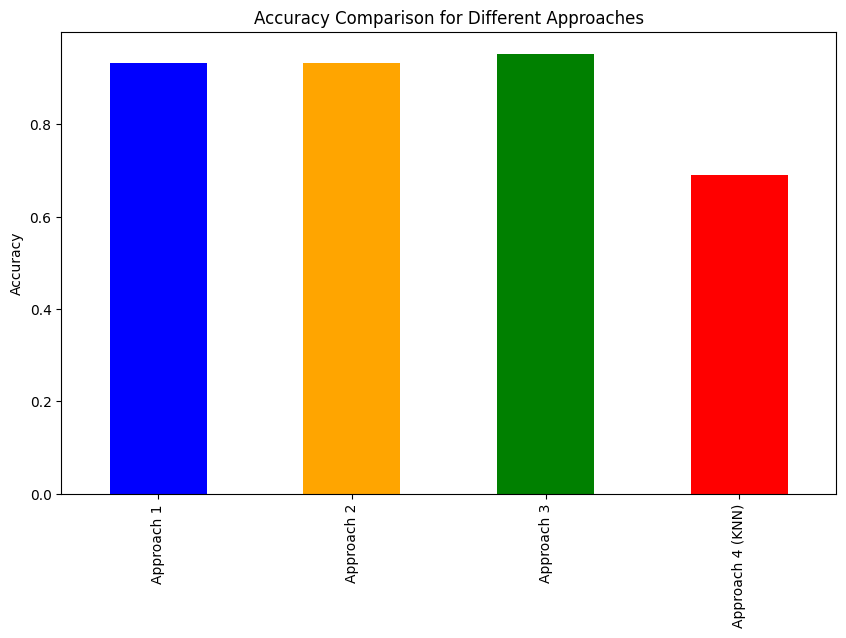

In [60]:
# Plotting accuracy for each approach
plt.figure(figsize=(10, 6))
df_scores.loc['Accuracy'].plot(kind='bar', color=['blue', 'orange', 'green', 'red'])
plt.title('Accuracy Comparison for Different Approaches')
plt.ylabel('Accuracy')
plt.show()

In [64]:
from math import pi

In [75]:
approach_scores = {
    'Approach 1': {
        'Accuracy': 0.9336,
        'Precision (Macro)': 0.859587,
        'Recall (Macro)': 0.818746,
        'F1 (Macro)': 0.830795,
        'Precision (Weighted)': 0.922903,
        'Recall (Weighted)': 0.923830,
        'F1 (Weighted)': 0.923168,
    },
    'Approach 2': {
        'Accuracy': 0.932857,
        'Precision (Macro)': 0.911194,
        'Recall (Macro)': 0.840433,
        'F1 (Macro)': 0.862063,
        'Precision (Weighted)': 0.932857,
        'Recall (Weighted)': 0.932857,
        'F1 (Weighted)': 0.862063,
    },
    'Approach 3': {
        'Accuracy': 0.9523,
        'Precision (Macro)': 0.8937,
        'Recall (Macro)': 0.8485,
        'F1 (Macro)': 0.8625,
        'Precision (Weighted)': 0.9510,
        'Recall (Weighted)': 0.9505,
        'F1 (Weighted)': 0.9502,
    },
    'Approach 4 (KNN)': {
        'Accuracy': 0.6901918690460217,
        'Precision (Macro)': 0.62,
        'Recall (Macro)': 0.43,
        'F1 (Macro)': 0.49,
        'Precision (Weighted)': 0.69,
        'Recall (Weighted)': 0.69,
        'F1 (Weighted)': 0.68
    }
}

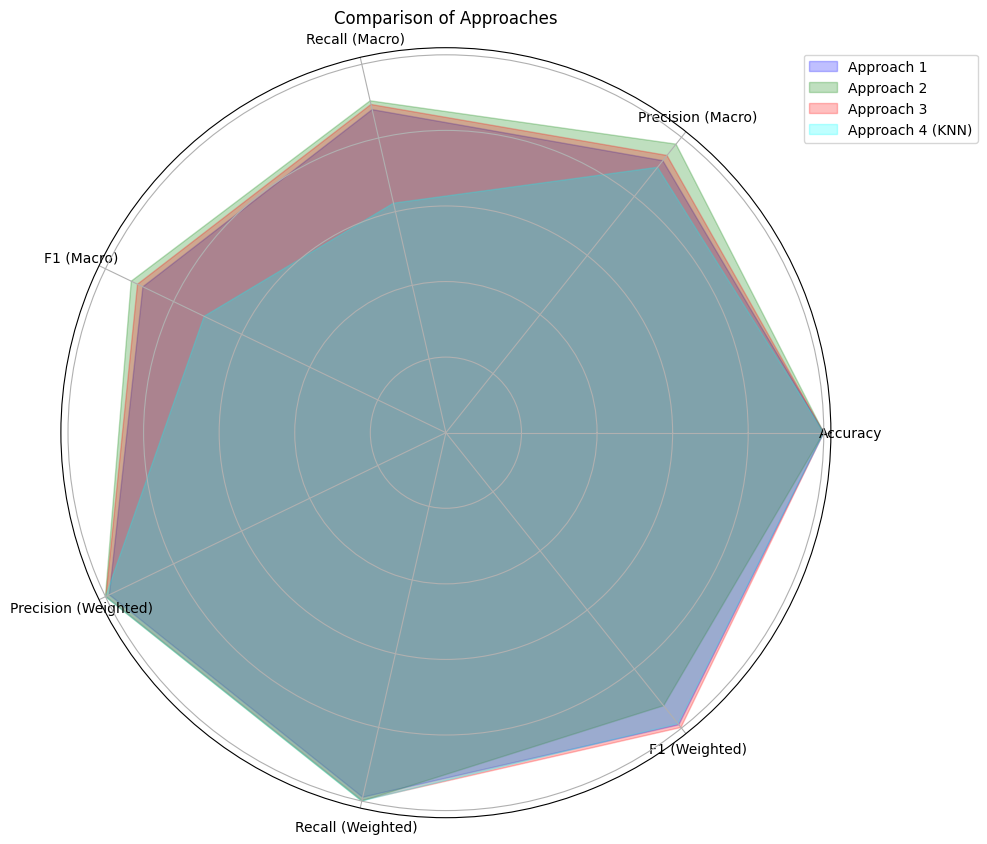

In [79]:
approaches = list(approach_scores.keys())
metrics = list(approach_scores['Approach 1'].keys())

# Define distinct colors
colors = ['blue', 'green', 'red', 'cyan']

# Create a radar plot for all approaches in one plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

for i, approach in enumerate(approaches):
    scores = [approach_scores[approach][metric] for metric in metrics]

    # Normalize the scores to be in the range [0, 1]
    normalized_scores = np.array(scores) / max(scores)

    # Repeat the first score at the end to close the circular graph
    normalized_scores = np.append(normalized_scores, normalized_scores[0])

    # Create angles for each score
    angles = np.linspace(0, 2 * np.pi, len(scores) + 1, endpoint=True)

    # Plot the radar plot for the current approach with a distinct color
    ax.fill(angles, normalized_scores, label=approach, color=colors[i], alpha=0.25)

# Set the legend
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# Set ticks and labels
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)

# Set the title of the plot
plt.title('Comparison of Approaches')

# Show the plot
plt.show()

In [84]:
# Define class names for each of the 65 classes
class_names = [f'Class {i}' for i in range(65)]

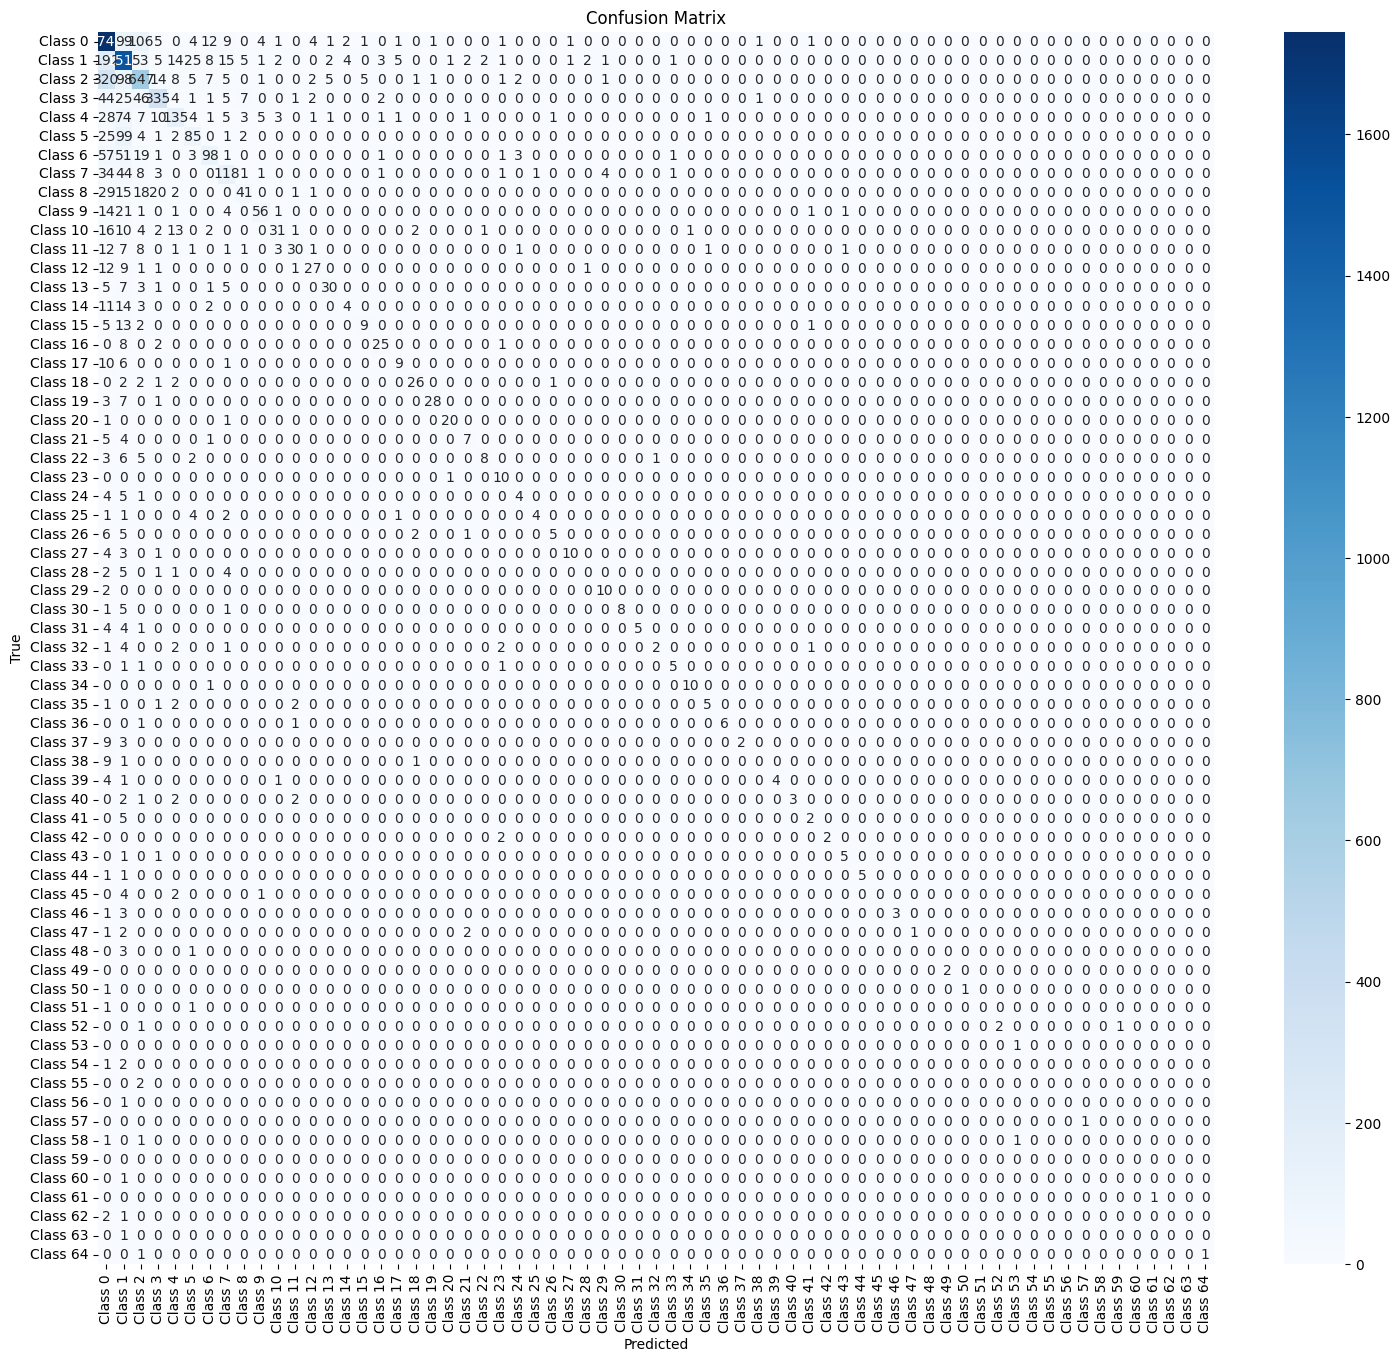

In [87]:
# Plot confusion matrix using seaborn
plt.figure(figsize=(18, 16))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()